<a href="https://colab.research.google.com/github/fmantecam/hmvKp_raman/blob/main/identification_of_hmvKp_by_raman_spectroscopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
import sys
from tqdm import tqdm

# Data processing and analysis
from scipy.linalg import solveh_banded
from scipy.signal import savgol_filter
from scipy.stats import norm, pearsonr
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, Normalizer
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Neural networks and deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution1D
from keras.models import load_model

# Class balancing
from imblearn.over_sampling import RandomOverSampler

# Check and mount for Google Colab
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print(f'Run on {datetime.datetime.now()} in Google Colab')
else:
    print(f'Run on {datetime.datetime.now()} on a local machine')


Mounted at /content/drive
Run on 2024-02-03 11:47:40.817309 in Google Colab


# helper functions

In [ ]:
class WhittakerSmoother(object):
    def __init__(self, signal, smoothness_param, deriv_order=1):
        """
        Whittaker Smoother.
        Input:
            signal: Array-like, the input signal to be smoothed.
            smoothness_param: Float, parameter controlling the smoothness.
            deriv_order: Integer, the order of the derivative used in smoothing.
        """
        self.y = signal
        assert deriv_order > 0, 'deriv_order must be an int > 0'
        # Compute the fixed derivative of identity (D).
        d = np.zeros(deriv_order*2 + 1, dtype=int)
        d[deriv_order] = 1
        d = np.diff(d, n=deriv_order)
        n = self.y.shape[0]
        k = len(d)
        s = float(smoothness_param)
        # Create upper triangular banded matrix for smoothing operation.
        diag_sums = np.vstack([
            np.pad(s*np.cumsum(d[-i:]*d[:i]), ((k-i,0),), 'constant')
            for i in range(1, k+1)])
        upper_bands = np.tile(diag_sums[:,-1:], n)
        upper_bands[:,:k] = diag_sums
        for i, ds in enumerate(diag_sums):
            upper_bands[i, -i-1:] = ds[::-1][:i+1]
        self.upper_bands = upper_bands

    def smooth(self, w):
        """
        Perform the smoothing operation.
        Input:
            w: Array-like, weights for the smoothing process.
        Output:
            Array-like, smoothed signal.
        """
        foo = self.upper_bands.copy()
        foo[-1] += w  # last row is the diagonal
        return solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)


def als_baseline(intensities, asymmetry_param=0.0005, smoothness_param=1e6,
                 max_iters=20, conv_thresh=1e-6, verbose=False):
    """
    Asymmetric least squares baseline correction.
    Input:
        intensities: Array-like, original intensities of the signal.
        asymmetry_param: Float, parameter controlling asymmetry.
        smoothness_param: Float, parameter controlling smoothness.
        max_iters: Integer, maximum number of iterations.
        conv_thresh: Float, convergence threshold.
        verbose: Boolean, flag for verbose output.
    Output:
        Array-like, baseline corrected signal.
    """
    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    p = asymmetry_param  # Rename for concision.
    w = np.ones(intensities.shape[0])  # Initialize weights.
    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p*mask + (1-p)*(~mask)
        conv = np.linalg.norm(new_w - w)
        if verbose:
            print(i+1, conv)
        if conv < conv_thresh:
            break
        w = new_w
    else:
        print('ALS did not converge in %d iterations' % max_iters)
    return z


def find_baseline(df):
    """
    Apply baseline correction to each row in a DataFrame.
    Input:
        df: DataFrame, contains the spectral data.
    Output:
        DataFrame, with baseline corrected for each spectrum.
    """
    D0_BL = df.copy()
    for i in range(len(df)):
        bl = als_baseline(df.iloc[i, :].values)
        D0_BL.iloc[i, :] = bl
    return D0_BL


def preprocess_data(X_filtered):
    """
    Preprocessing of spectral data.
    Input:
        X_filtered: DataFrame, raw spectral data.
    Output:
        DataFrame, preprocessed spectral data.
    """
    X_norm_list = []
    for _, row in X_filtered.iterrows():
        # Normalize each spectrum.
        total = np.sum(row)
        X_norm_list.append(pd.DataFrame([row / total * 2000]))

    X_norm = pd.concat(X_norm_list, ignore_index=True)

    # Apply Savitzky-Golay filter for smoothing.
    X_norm_flt = savgol_filter(X_norm, 21, 2)
    X_norm_flt = pd.DataFrame(X_norm_flt, columns=X_filtered.columns)

    # Baseline correction.
    bl = find_baseline(X_norm_flt)
    X_norm_flt = X_norm_flt - bl

    # Standardize data.
    scaler = StandardScaler()
    z_numpy = X_norm_flt.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_flt_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=X_norm_flt.columns)

    return X_norm_flt_stdz


# 2.2 Data acquisition

In [ ]:
# load CSV file into a DataFrame
X_completa = pd.read_csv("/content/drive/MyDrive/klebsiellas/klebsiellas-todos-02agosto2023.csv")

# remove label columns
X = X_completa.iloc[:,:-9]

# define Raman shifts
ramanshifts = np.arange(600, 1800, 0.5)

# Identify rows where the difference between the maximum and minimum values is less than 75
rows_with_small_range = X[(X.max(axis=1) - X.min(axis=1)) < 75]

# Preprocessing steps
# Copying the complete dataset
filtered_data = X_completa.copy()

# Extracting the phenotype label
label = 'fenotype'
y_total = pd.DataFrame(filtered_data[label], columns=[label])
y_total[label] = pd.Categorical(y_total[label])

# Defining columns to be dropped
columns_to_drop = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number',
                   'intense', 'fenotype', 'number', 'date']

# Dropping the non-spectral columns and preprocessing the spectral data
spectral_data = filtered_data.drop(columns=columns_to_drop)
preprocessed_spectral_data = preprocess_data(spectral_data)

# Merging the preprocessed spectral data with the dropped columns
combined_spectral_data = pd.concat([preprocessed_spectral_data, filtered_data[columns_to_drop]], axis=1)

# Removing spectra with range (max - min) less than 75
spectra_without_small_range = combined_spectral_data.drop(rows_with_small_range.index)

filtered_data = spectra_without_small_range

filtered_data = spectra_without_small_range[spectra_without_small_range['date'] != 270623]
#filtered_data = filtered_data[filtered_data['fenotype'] != 'control']

# Normalize spectra by shifting each to start at 0

# Define the columns that should not be altered as they are not spectral data
columns_to_retain = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number',
                     'intense', 'fenotype', 'number', 'date']

# Extracting only the spectral data (excluding the last 9 columns which are non-spectral)
spectral_data_only = filtered_data.drop(columns=columns_to_retain)

# Shift each spectrum so its minimum value becomes 0
# Using .apply along axis=1 for row-wise operation
normalized_spectral_data = spectral_data_only.apply(lambda row: row - row.min(), axis=1)

# Reattaching the non-spectral data columns to the normalized spectral data
normalized_spectral_data = pd.concat([normalized_spectral_data, filtered_data[columns_to_retain]], axis=1)
#if not
#normalized_spectral_data = pd.concat([spectral_data_only, filtered_data[columns_to_retain]], axis=1)

filtered_data = normalized_spectral_data

### Figure 2

Figure 2: Histogram of Raman spectrum amplitudes of Klebsiella pneumoniae isolates divided into four colour regions (a) and a random Raman spectrum for each region (b).


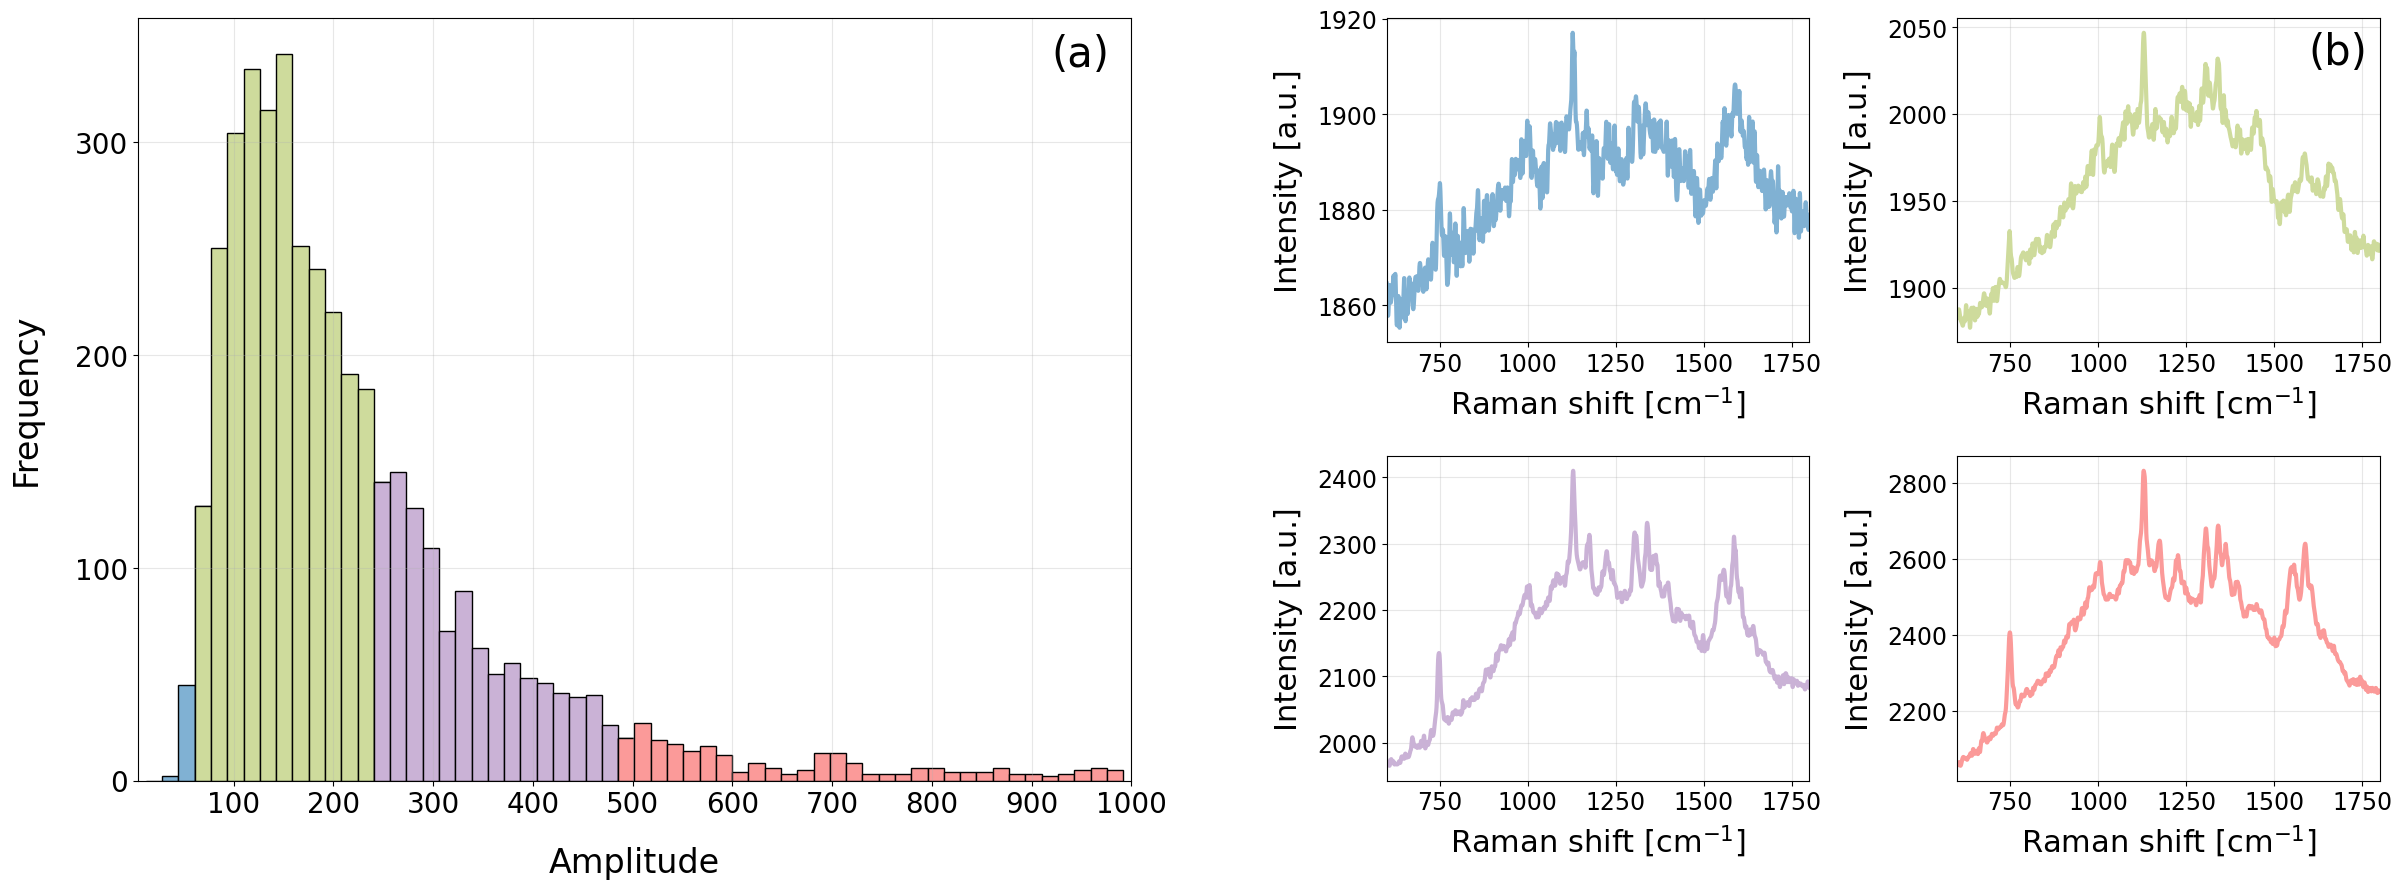

In [ ]:
fig = plt.figure(figsize=(24, 9))
gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 0, 1])

# First subplot (fig2a)
ax2a = fig.add_subplot(gs[0])

# Calculate maximum amplitude
amplitud_maxima = X.max(axis=1) - X.min(axis=1)
amplitud_maxima_filtrada = amplitud_maxima[amplitud_maxima <= 1000]

# Define bin edges for histogram
bin_edges = np.linspace(20, 1000, 61)
hist, _ = np.histogram(amplitud_maxima_filtrada, bins=bin_edges)

# Generate a color palette
colors = sns.color_palette("Paired", n_colors=30)
colors2 = sns.color_palette("Set3", n_colors=30)
colors3 = sns.color_palette("tab20b", n_colors=30)

# Swap colors at index 0 and 1
colors[0], colors[1], colors[2], colors[3] = colors2[4], colors3[7], colors[8], colors[4]


# Define intervals for color assignment
intervalos_colores = [(10, 75), (75, 250), (250, 500), (500, 1000)]

# Plot histogram with color assignment
for i, (bin_start, bin_end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    for intervalo, color in zip(intervalos_colores, colors):
        if intervalo[0] <= bin_start < intervalo[1] or intervalo[0] < bin_end <= intervalo[1]:
            ax2a.bar(bin_start, hist[i], width=np.diff(bin_edges)[i], color=color, edgecolor='black')

# Set properties for ax2a
ax2a.set_xlim(3.9, 1000)
ax2a.set_xlabel('Amplitude', fontsize=24, labelpad=20)
ax2a.set_ylabel('Frequency', fontsize=24, labelpad=23)
ax2a.xaxis.set_major_locator(plt.MultipleLocator(100))
ax2a.yaxis.set_major_locator(plt.MultipleLocator(100))
ax2a.grid(alpha=0.3)
ax2a.tick_params(labelsize=20)
ax2a.text(0.92, 0.98, '(a)', transform=ax2a.transAxes, fontsize=30, verticalalignment='top')

# Second subplot (fig2b)
ax2b = plt.Subplot(fig, gs[2])
fig.add_subplot(ax2b)

# Hide the frame of subplot fig2b
for spine in ax2b.spines.values():
    spine.set_visible(False)
ax2b.set_xticks([])
ax2b.set_yticks([])

# Create a GridSpec for the second subplot
gs2b = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[2], hspace=0.35, wspace=0.35)

# Plotting in the second subplot
for i, (bin_start, bin_end) in enumerate(intervalos_colores):
    espectros_en_rango = X_completa.iloc[:,:-9][(amplitud_maxima >= bin_start) & (amplitud_maxima < bin_end)]
    muestras_aleatorias = espectros_en_rango.sample(1)
    ax = fig.add_subplot(gs2b[i])

    for index, fila in muestras_aleatorias.iterrows():
        ax.plot(ramanshifts, fila, color=colors[i], linewidth=3)
    ax.grid(alpha=0.3)
    ax.set_xlim([600, 1800])
    ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=22, labelpad=6)
    ax.set_ylabel('Intensity [a.u.]', fontsize=22, labelpad=10)
    ax.tick_params(labelsize=17)

    if i == 1:
        ax.text(0.97, 0.96, '(b)', transform=ax.transAxes, fontsize=30,
                verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.savefig('fig2.svg', format='svg', dpi=300)
plt.show()

# 3.1 Class separability and Raman features

### Figure 4

Figure 4: Average Raman spectra for each Klebsiella pneumoniae serotype (K1, K2, 54 and K57) with their respective variance bands (a) and the average spectrum of the whole dataset with the position of the most relevant Raman features(b).

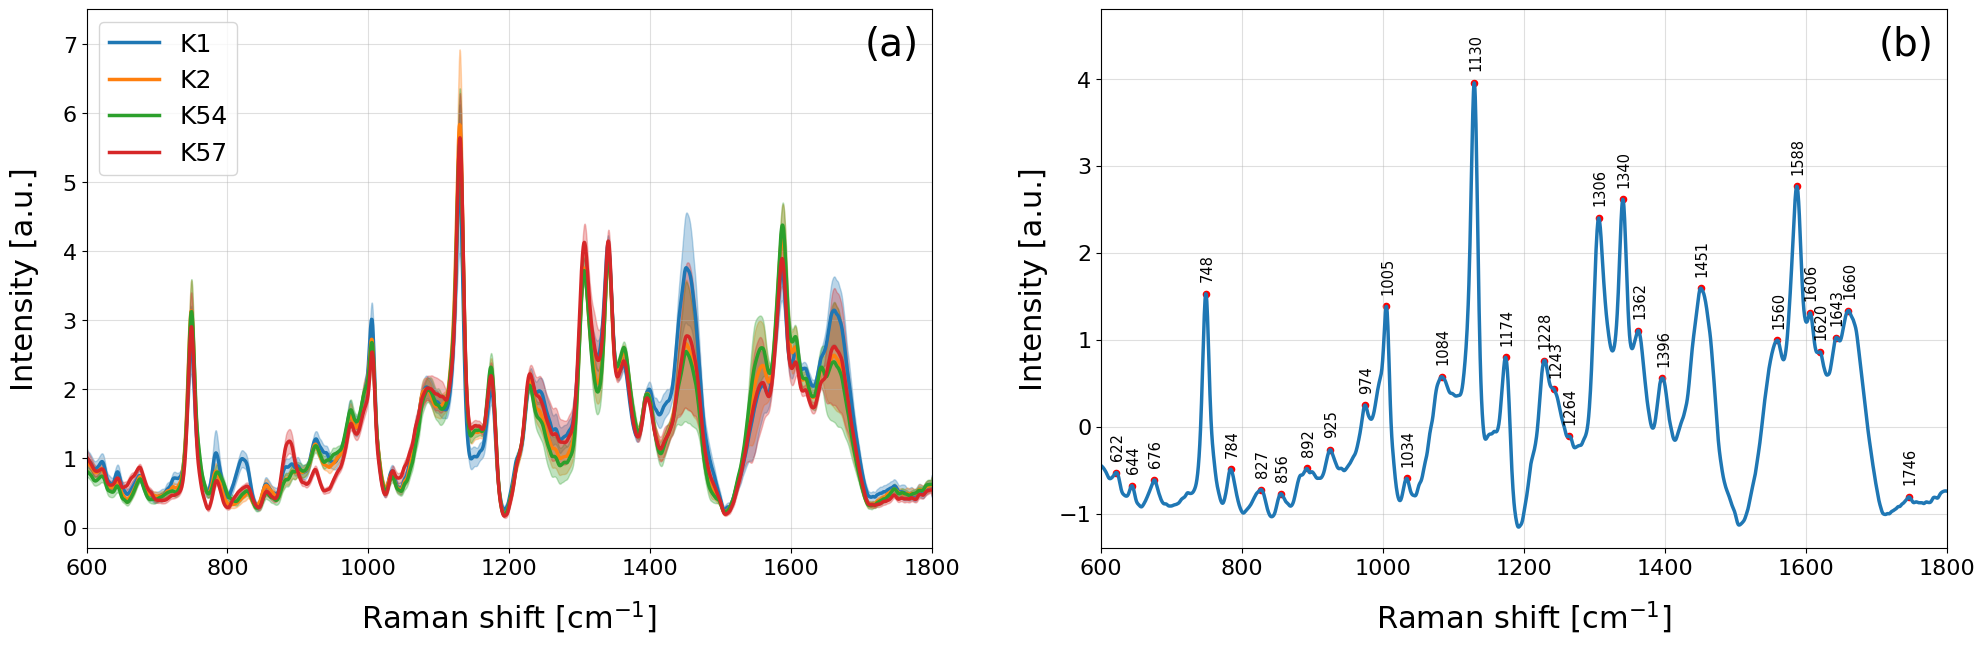

In [ ]:
phenotypes = ['K1', 'K2', 'K54', 'K57']
colors = ['C0', 'C1', 'C2', 'C3']
spectra = {phenotype: np.mean(filtered_data[filtered_data['fenotype'] == phenotype].iloc[:, :-9], axis=0) for phenotype in phenotypes}
variances = {phenotype: filtered_data[filtered_data['fenotype'] == phenotype].iloc[:, :-9].var(axis=0) for phenotype in phenotypes}

# Creating a figure with two subplots
fig4, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(24, 7))
alphaVal = 1
linethick = 2.5

# Plotting the spectra in the first subplot (ax4a)
for phenotype, color in zip(phenotypes, colors):
    ax4a.plot(ramanshifts, spectra[phenotype], lw=linethick, alpha=alphaVal, color=color, label=phenotype)
    # Plotting variance as filled regions
    ax4a.fill_between(ramanshifts, spectra[phenotype] - variances[phenotype], spectra[phenotype] + variances[phenotype], alpha=0.3, color=color)
ax4a.legend(loc='upper left', prop={'size': 18})
ax4a.grid(alpha=0.4)
ax4a.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=22, labelpad=15)
ax4a.set_ylabel(r'Intensity [a.u.]', fontsize=22, labelpad=17)
ax4a.set_xlim([600, 1800])
ax4a.set_ylim([-0.3, 7.5])

# Plotting the average spectrum and peaks in the second subplot (ax4b)
avg_spectrum = np.mean(spectral_data_only, axis=0)
peaks = [43, 87, 151, 297, 368, 454, 511, 584, 650, 749, 810, 867, 967, 1059, 1148, 1257, 1286, 1328, 1413, 1481, 1525, 1593, 1702, 1920, 1975, 2012, 2040, 2086, 2121, 2293]
ax4b.plot(ramanshifts, avg_spectrum, lw=linethick, alpha=alphaVal)
for peak in peaks:
    ax4b.scatter(ramanshifts[peak], avg_spectrum[peak], color='red', marker='o', alpha=1, s=20)
    ax4b.annotate(f'{ramanshifts[peak]:.0f}', (ramanshifts[peak], avg_spectrum[peak]), textcoords="offset points", xytext=(1, 11), ha='center', fontsize=10.5, rotation=90)
ax4b.grid(alpha=0.4)
ax4b.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=22, labelpad=15)
ax4b.set_ylabel(r'Intensity [a.u.]', fontsize=22, labelpad=8)
ax4b.set_xlim([600, 1800])
ax4b.set_ylim(-1.4, 4.8)

# Setting tick font sizes
ax4a.tick_params(axis='both', which='major', labelsize=16)
ax4b.tick_params(axis='both', which='major', labelsize=16)

# Adding text labels for subplots (a) and (b)
ax4a.text(0.92, 0.97, '(a)', transform=ax4a.transAxes, fontsize=28, verticalalignment='top')
ax4b.text(0.92, 0.97, '(b)', transform=ax4b.transAxes, fontsize=28, verticalalignment='top')

fig4.savefig('fig4.svg', format='svg', dpi=300)


### Figure 5

Figure 5: Pearson correlation matrix obtained for all acquired Raman spectra of Klebsiella pneumoniae bacteria (a), the same matrix with a threshold value of 0.8 (b) and a magnification of the highly correlated area (c).

In [ ]:
spectra = combined_spectral_data

In [ ]:
steps = [4]  # List of step sizes for dimensionality reduction

# Iterate over each step size to reduce dimensionality
for idx, step in enumerate(steps):
    # Calculate the number of columns after reduction
    num_reduced_columns = len(spectra.iloc[:, :-9].columns) // step

    # Initialize lists to store averaged columns and corresponding Raman shifts
    reduced_columns = []
    reduced_ramanshifts = []

    # Iterate over columns in steps to average groups of 'step' columns
    for i in range(0, len(spectra.iloc[:, :-9].columns), step):
        # Calculate the mean of each group of 'step' columns
        avg_columns = spectra.iloc[:, :-9].iloc[:, i:i+step].mean(axis=1)
        reduced_columns.append(avg_columns)
        # Calculate the mean Raman shift for each group of 'step' columns
        reduced_ramanshifts.append(np.mean(ramanshifts[i:i+step]))

    # Concatenate the averaged columns into a new DataFrame
    espectros_reduced = pd.concat(reduced_columns, axis=1)
    # Assign the mean Raman shift values as the column names of the new DataFrame
    espectros_reduced.columns = reduced_ramanshifts

In [ ]:
# Calculate the Pearson correlation matrix using pandas
correlation_matrix = espectros_reduced.corr(method='pearson')

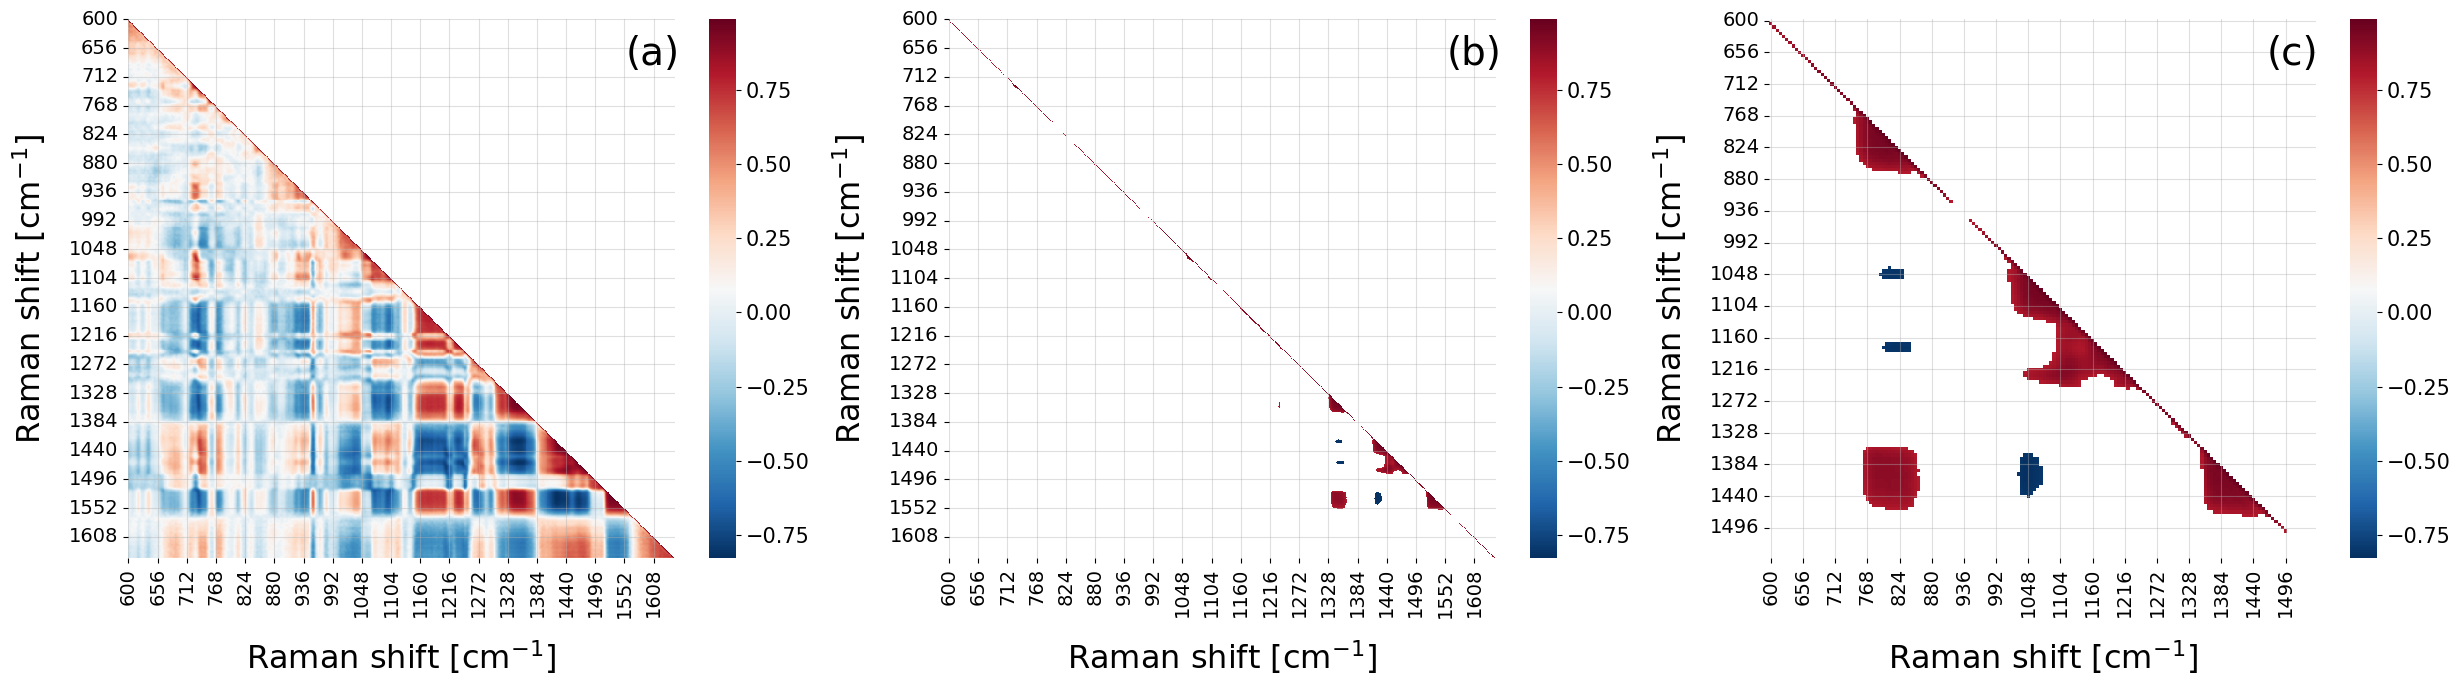

In [ ]:
fig, (ax5a, ax5b, ax5c) = plt.subplots(1, 3, figsize=(30, 7))

intervalo_xticks = 2
etiquetas_personalizadas = ["600", "656", "712", "768", "824", "880", "936", "992", "1048", "1104", "1160", "1216", "1272", "1328", "1384", "1440", "1496", "1552", "1608", "1664", "1720", "1776"]

# Function to adjust ticks, labels, and add grid
def customize_fig5(ax):
    xticks_positions = ax.get_xticks()
    nuevas_posiciones = xticks_positions[::intervalo_xticks]
    ax.set_xticks(nuevas_posiciones)
    ax.set_xticklabels(etiquetas_personalizadas[:len(nuevas_posiciones)], fontsize=14)
    ax.set_yticks(nuevas_posiciones)
    ax.set_yticklabels(etiquetas_personalizadas[:len(nuevas_posiciones)], fontsize=14)
    ax.grid(alpha=0.4)
    ax.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=23, labelpad=15)
    ax.set_ylabel(r'Raman shift [cm$^{-1}$]', fontsize=23, labelpad=15)

# figure 5a: plotting the full correlation matrix
sns.heatmap(correlation_matrix, mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), annot=False, cmap="RdBu_r", cbar=True, ax=ax5a)
cbar_ax5a = ax5a.collections[0].colorbar
cbar_ax5a.ax.tick_params(labelsize=15)
ax5a.text(0.91, 0.97, '(a)', transform=ax5a.transAxes, fontsize=28, verticalalignment='top')
customize_fig5(ax5a)

# figure 5b: thresholded Correlation Matrix
threshold = 0.8
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
filtered_matrix = np.where(np.abs(correlation_matrix) > threshold, correlation_matrix, np.nan)
sns.heatmap(filtered_matrix, mask=mask, annot=False, cmap="RdBu_r", cbar=True, ax=ax5b)
cbar_ax5b = ax5b.collections[0].colorbar
cbar_ax5b.ax.tick_params(labelsize=15)
ax5b.text(0.91, 0.97, '(b)', transform=ax5b.transAxes, fontsize=28, verticalalignment='top')
customize_fig5(ax5b)

# figure 5c: zoomed-in Correlation Matrix
correlation_matrix2 = correlation_matrix.iloc[390:560, 390:560]
filtro_intensos = np.abs(correlation_matrix2) > threshold
mask_intensos = np.triu(np.ones_like(correlation_matrix2, dtype=bool))
sns.heatmap(correlation_matrix2.where(filtro_intensos), mask=mask_intensos, annot=False, cmap="RdBu_r", cbar=True, ax=ax5c)
cbar_ax5c = ax5c.collections[0].colorbar
cbar_ax5c.ax.tick_params(labelsize=15)
customize_fig5(ax5c)
ax5c.text(0.91, 0.97, '(c)', transform=ax5c.transAxes, fontsize=28, verticalalignment='top')

# Display the plot
plt.savefig('fig5.svg', format='svg', dpi=300)
plt.show()


### Figure 6

Figure 6: Histogram of the 1450/1560 ratio (a) and 1660/1560 ratio (b) for all preprocessed Raman spectra of Klebsiella pneumoniae isolates.

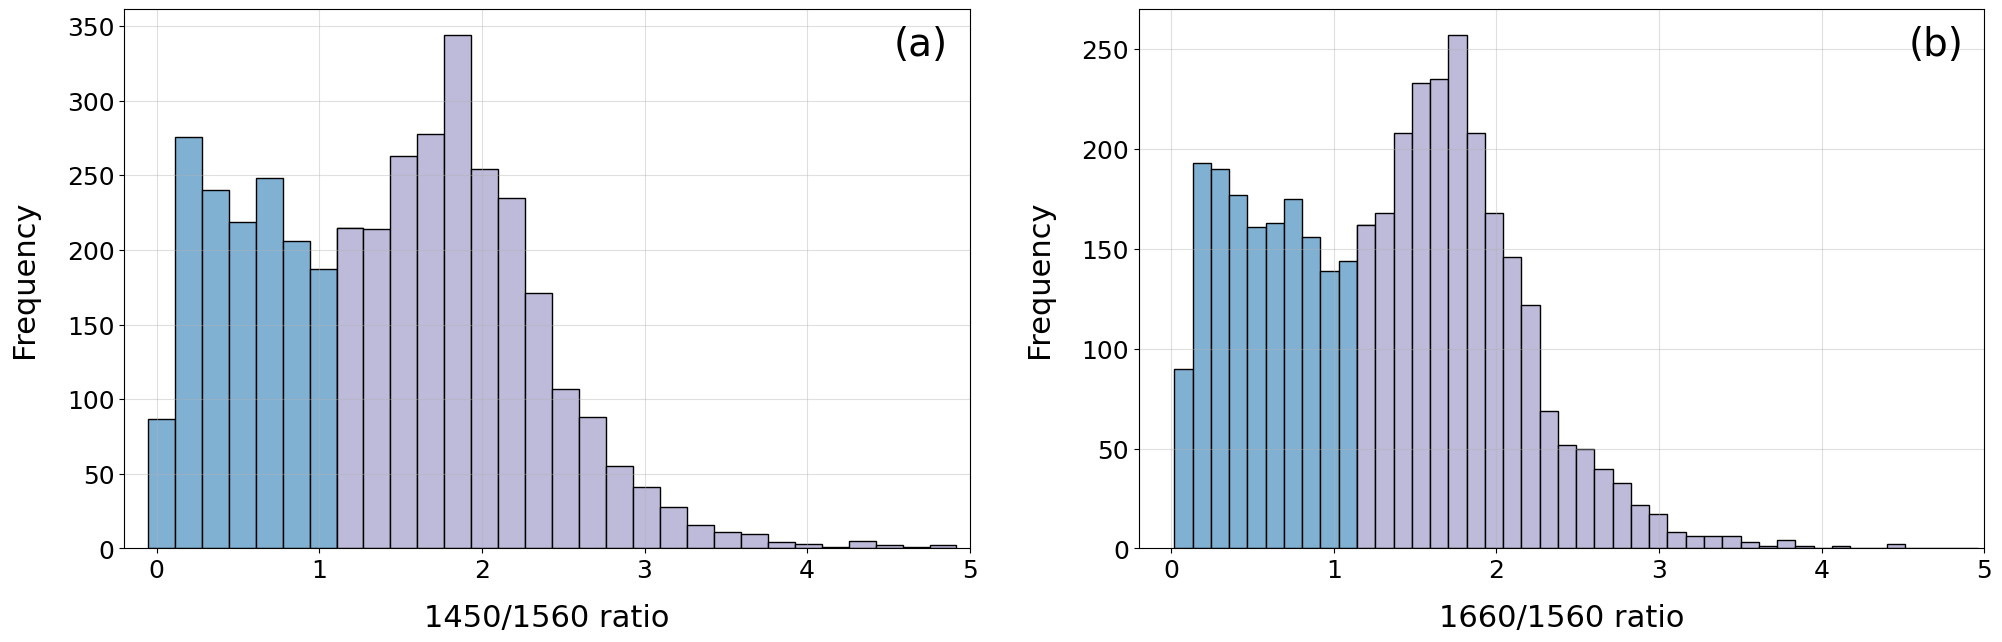

In [ ]:
spectra2 = filtered_data.copy()

# Initial setup for histograms
fig6, (ax6a, ax6b) = plt.subplots(1, 2, figsize=(24, 7))
colors = sns.color_palette("Set3", n_colors=20)
colors[1], colors[0] = colors[2], colors[4]  # Adjusting colors

# Defining the ratios to be calculated
wavelength_1450, wavelength_1560, wavelength_1660 = '1450.0', '1560.0', '1660.0'
spectra2['ratio_1450_1560'] = spectra2[wavelength_1450] / spectra2[wavelength_1560]
spectra2['ratio_1660_1560'] = spectra2[wavelength_1660] / spectra2[wavelength_1560]

# Data for histograms and colors by interval
ratio_data = [
    ('ratio_1450_1560', ax6a, '1450/1560 ratio'), # Data for the first histogram
    ('ratio_1660_1560', ax6b, '1660/1560 ratio')  # Data for the second histogram
]

# Common settings for histogram intervals and colors
interval_colors = [(0, 1.2), (1.2, 5)]

# Loop through each ratio to create histograms
for ratio_name, ax, xlabel in ratio_data:
    hist, bin_edges = np.histogram(spectra2[ratio_name], bins=60)
    for i, (bin_start, bin_end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        for interval, color in zip(interval_colors, colors):
            if interval[0] <= bin_start < interval[1] or interval[0] < bin_end <= interval[1]:
                ax.bar(bin_start, hist[i], width=np.diff(bin_edges)[i], color=color, edgecolor='black')

    # Customizing subplot appearance
    ax.set_xlabel(xlabel, fontsize=22, labelpad=15)
    ax.set_ylabel('Frequency', fontsize=22, labelpad=20)
    ax.set_xlim(-0.2, 5)
    ax.grid(alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.text(0.91, 0.97, f'({chr(97 + ratio_data.index((ratio_name, ax, xlabel)))})', transform=ax.transAxes, fontsize=28, verticalalignment='top')

# Save and show the figure
fig6.savefig('fig6.svg', format='svg', dpi=300)
plt.show()


### Figure 7

Figure 7: Average Raman spectra and variances bands for each spectra type, N1 (blue) and N2 (purple).

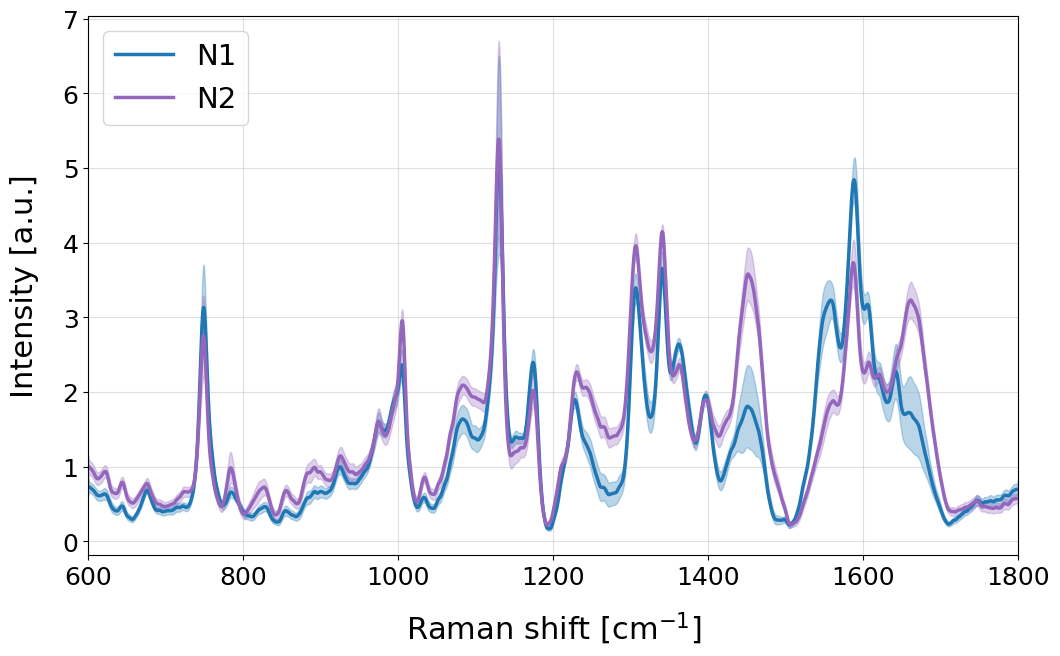

In [ ]:
# Splitting the data into two categories based on the ratio_1450_1560 value
# This categorization is done to analyze spectra with intensity variations at 1450 cm^-1 relative to 1560 cm^-1.
intense_spectra = spectra2[spectra2['ratio_1450_1560'] < 1.1]
normal_spectra = spectra2[spectra2['ratio_1450_1560'] > 1.1]

# Calculating the mean spectra for each category
# The calculation excludes the last 10 columns, which do not contain spectral data.
mean_intense_spectra = intense_spectra.iloc[:, :-10].mean(axis=0, numeric_only=True)
mean_normal_spectra = normal_spectra.iloc[:, :-10].mean(axis=0, numeric_only=True)
# Calculating and plotting the variance for each category to indicate dispersion.
variance_intense_spectra = intense_spectra.iloc[:, :-10].var(axis=0, numeric_only=True)
variance_normal_spectra = normal_spectra.iloc[:, :-10].var(axis=0, numeric_only=True)

# Setting up the plot
fig, ax = plt.subplots(figsize=(12, 7))
alphaVal = 1
linethick = 2.5

# Plotting the mean spectra for both categories.
ax.plot(ramanshifts, mean_intense_spectra, lw=linethick, alpha=alphaVal, color='C0', label='N1')
ax.plot(ramanshifts, mean_normal_spectra, lw=linethick, alpha=alphaVal, color='C4', label='N2')
ax.fill_between(ramanshifts, mean_intense_spectra - variance_intense_spectra, mean_intense_spectra + variance_intense_spectra, alpha=0.3, color='C0')
ax.fill_between(ramanshifts, mean_normal_spectra - variance_normal_spectra, mean_normal_spectra + variance_normal_spectra, alpha=0.3, color='C4')
ax.legend(loc='upper left', prop={'size': 21})
# Enhancing plot aesthetics with grid, labels, and custom tick settings.
ax.grid(alpha=0.4)
ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=22, labelpad=15)
ax.set_ylabel('Intensity [a.u.]', fontsize=22, labelpad=17)
ax.set_xticks(np.arange(600, 2001, 200))  # Ensures the x-axis covers the specified range with proper interval
ax.set_yticks(np.arange(0, 8, 1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim([600, 1800])

# Saving and showing the plot
plt.savefig('fig7.svg', format='svg', dpi=300)
plt.show()



### Figure 8

Figure 8: Average Raman spectra and variance bands for each type of Klebsiella pneumoniae capsular serotype (K1, K2, 54 and K57) for both spectrum types, N1 (a) and N2 (b).

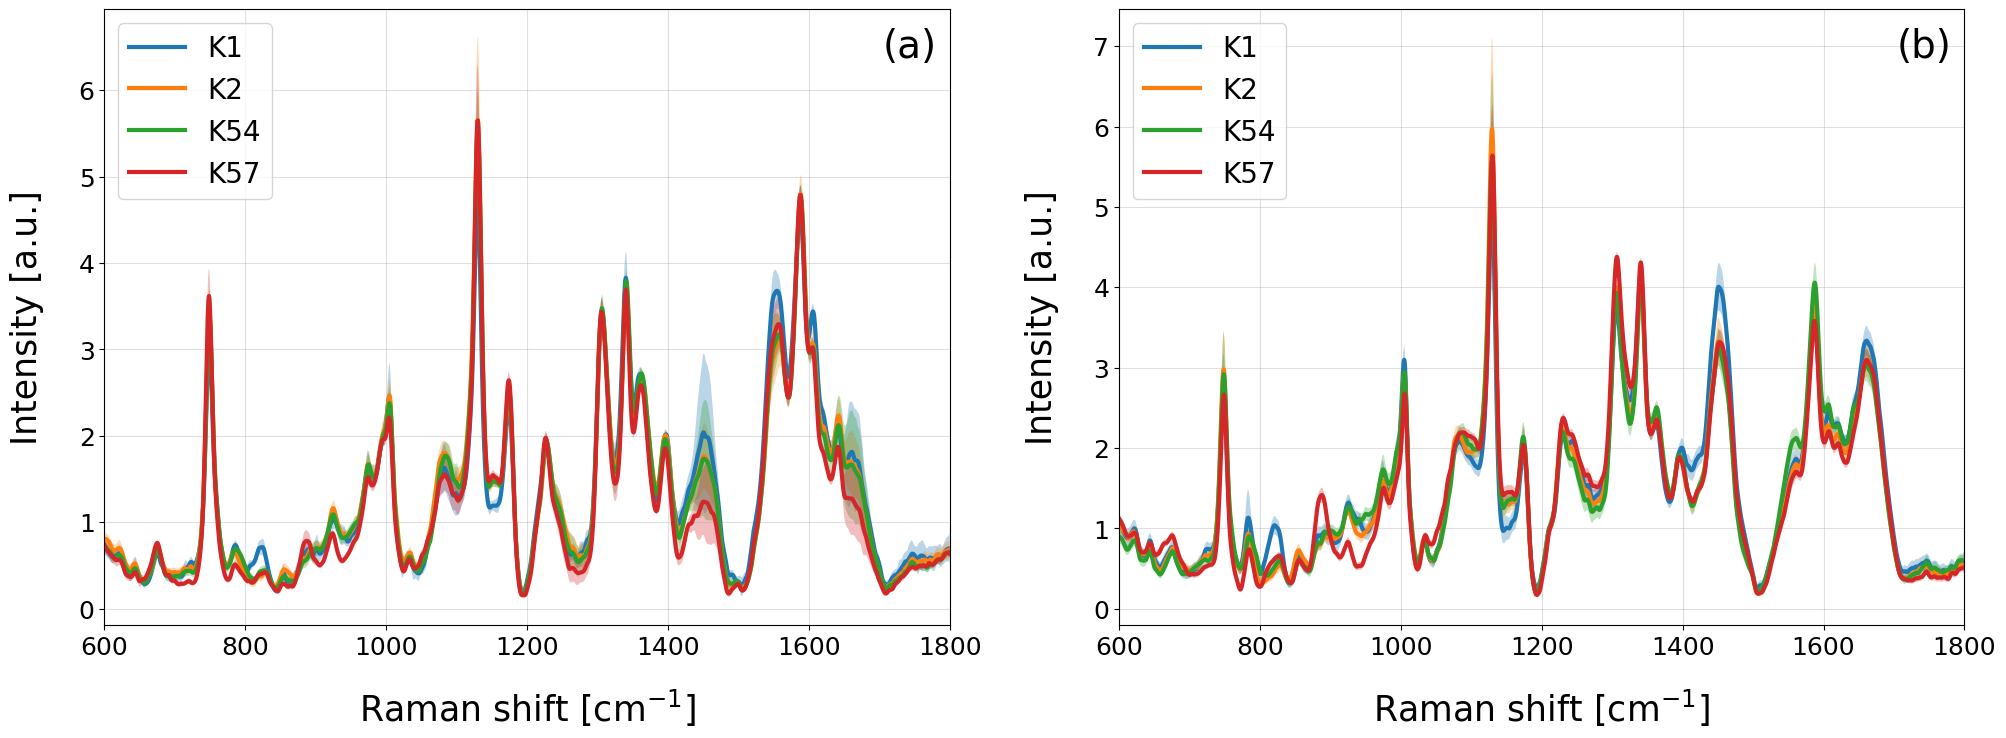

In [ ]:
# Filtering spectra based on specific criteria and separating based on the 'ratio_1450_1560' value.
espectros_intensos = spectra2[(spectra2['ratio_1450_1560'] < 1.1) &
                              (spectra2['date'] != 270623) &
                              (spectra2['fenotype'] != 'control')]
espectros_normales = spectra2[(spectra2['ratio_1450_1560'] > 1.1) &
                              (spectra2['date'] != 270623) &
                              (spectra2['fenotype'] != 'control')]

label = 'fenotype'
unique_labels = ['K1', 'K2', 'K54', 'K57']  # Define unique labels for plotting

# Creating a subplot with 2 axes
fig, (ax8a, ax8b) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

# Plotting for espectros_intensos with each label
for label2 in unique_labels:
    label_data = espectros_intensos[espectros_intensos[label] == label2]
    espectro_promedio = label_data.iloc[:, :-10].mean(axis=0, numeric_only=True)
    varianza = label_data.iloc[:, :-10].var(axis=0, numeric_only=True)
    ax8a.plot(ramanshifts, espectro_promedio, lw=3, alpha=1, label=f'{label2}')
    ax8a.fill_between(ramanshifts, espectro_promedio - varianza, espectro_promedio + varianza, alpha=0.3)

# Plotting for espectros_normales with each label
for label2 in unique_labels:
    label_data = espectros_normales[espectros_normales[label] == label2]
    espectro_promedio = label_data.iloc[:, :-10].mean(axis=0, numeric_only=True)
    varianza = label_data.iloc[:, :-10].var(axis=0, numeric_only=True)
    ax8b.plot(ramanshifts, espectro_promedio, lw=3, alpha=1, label=f'{label2}')
    ax8b.fill_between(ramanshifts, espectro_promedio - varianza, espectro_promedio + varianza, alpha=0.3)

# Setting labels, titles, legends, and formatting for ax8a and ax8b
for ax in [ax8a, ax8b]:
    ax.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=25, labelpad=20)
    ax.set_ylabel(r'Intensity [a.u.]', fontsize=25, labelpad=25)
    ax.grid(alpha=0.4)
    ax.legend(loc='upper left', prop={'size': 20})
    ax.tick_params(axis='both', labelsize=18)
    ax.set_xlim([600, 1800])

# Adding subplot labels
ax8a.text(0.92, 0.97, '(a)', transform=ax8a.transAxes, fontsize=28, verticalalignment='top')
ax8b.text(0.92, 0.97, '(b)', transform=ax8b.transAxes, fontsize=28, verticalalignment='top')

# Save and show plot
plt.savefig('fig8.svg', format='svg', dpi=300)
plt.show()


# 3.2. 1-D CNN classification models

calculo el porcentaje de espectros usados como unseens

In [ ]:
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'KpC3') & (filtered_data['date'] == 310523),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723)
]


final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition

filtered_data = filtered_data[filtered_data['fenotype'] != 'control']
unseens = filtered_data[final_condition]
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']

label = 'fenotype'

# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

calcular = [{'que': 'train', 'X': X_train, 'y': y_train},
            {'que': 'val', 'X': X_val, 'y': y_val},
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}



<ipython-input-34-7fafe0b6e7c7>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unseens = filtered_data[final_condition]
<ipython-input-34-7fafe0b6e7c7>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data2 = filtered_data[~final_condition]


### Figure 9

Figure 9: Confusion matrix for unseen data obtained from training a 1-D CNN model with all preprocessed spectra dataset. The overall accuracy is 86%.

51/51 [==============================] - 2s 44ms/step
train accuracy: 0.896


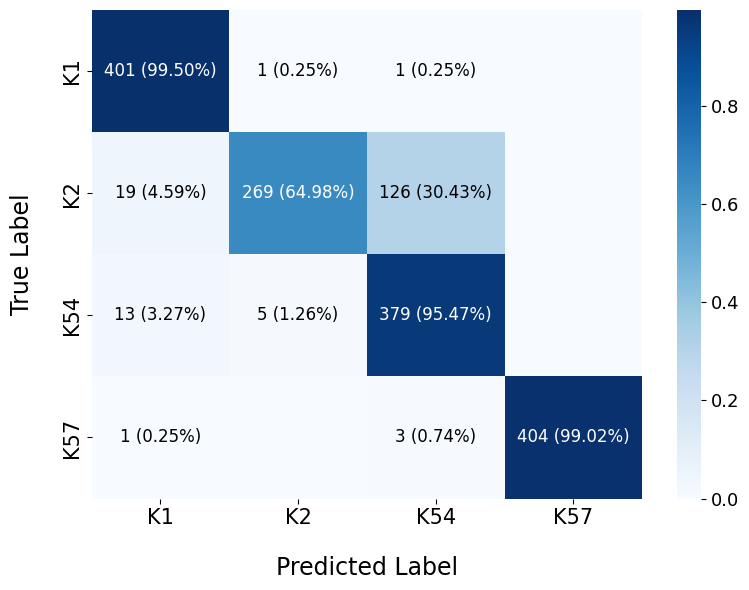

13/13 [==============================] - 1s 48ms/step
val accuracy: 0.897


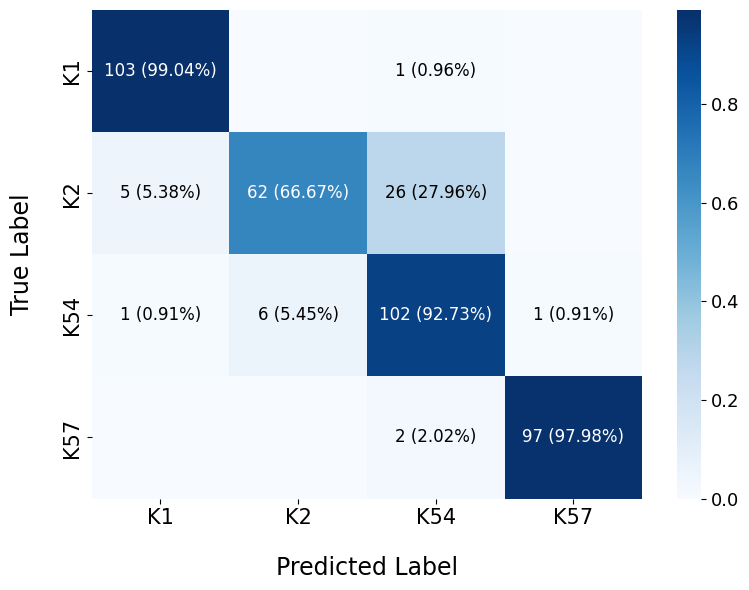

5/5 [==============================] - 0s 54ms/step
test accuracy: 0.863


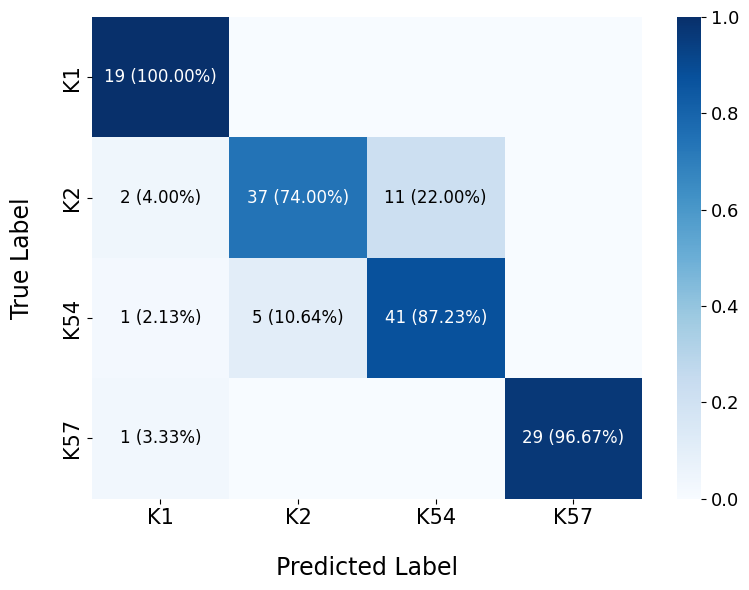

13/13 [==============================] - 1s 65ms/step
Class 0 - Accuracy: 0.97, Recall: 1.00, Precision: 0.83,Specificity: 0.97, F1-Score: 0.90, AUC: 1.0000
Class 1 - Accuracy: 0.88, Recall: 0.74, Precision: 0.88,Specificity: 0.95, F1-Score: 0.80, AUC: 0.9598
Class 2 - Accuracy: 0.88, Recall: 0.87, Precision: 0.79,Specificity: 0.89, F1-Score: 0.83, AUC: 0.9495
Class 3 - Accuracy: 0.99, Recall: 0.97, Precision: 1.00,Specificity: 1.00, F1-Score: 0.98, AUC: 1.0000


In [ ]:
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model1_kleb_allfeatures_allfenotypes.h5')

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    fig9, ax9 = plt.subplots(figsize=(8, 6))
    #plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"

                # Elegir el color del texto basado en el valor de fondo
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)
    ax9.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
    ax9.set_ylabel('True Label', fontsize=17, labelpad=20)
    plt.xticks( fontsize=15)
    plt.yticks(fontsize=15)
    cbar = sns_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)
    plt.tight_layout()
    fig9.savefig('fig9.svg', format='svg', dpi=300)
    plt.show()

y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]


y_pred_int_np = np.argmax(y_pred, axis=1)
y_test_int_np = np.argmax(y_test, axis=1)


class_metrics = []

for i in range(num_classes_grouped):
    tp = cm[i, i]  # True Positive
    fn = cm[i, :].sum() - tp  # False Negative
    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
    fp = cm[:, i].sum() - tp  # False Positive

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

    # Create one-hot encoded y_true_class for the current class
    y_true_class = np.zeros((len(y_test_int_np),))
    y_true_class[y_test_int_np == i] = 1

    # Probability scores for the current class
    y_score_class = y_pred[:, i]

    # Calculate AUC
    auc = roc_auc_score(y_true_class, y_score_class)

    class_metrics.append({
        'Class': i,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'AUC': auc
    })

for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
          f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
          f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
          f"AUC: {metrics['AUC']:.4f}")


In [ ]:
model.save('/content/drive/MyDrive/klebsiellas/modelospaper/model1_kleb_allfeatures_allfenotypes.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


y-randomization

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2400, 64)          576       
                                                                 
 activation_12 (Activation)  (None, 2400, 64)          0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 1200, 64)          0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 1200, 64)          0         
                                                                 
 flatten_4 (Flatten)         (None, 76800)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               9830528   
                                                      

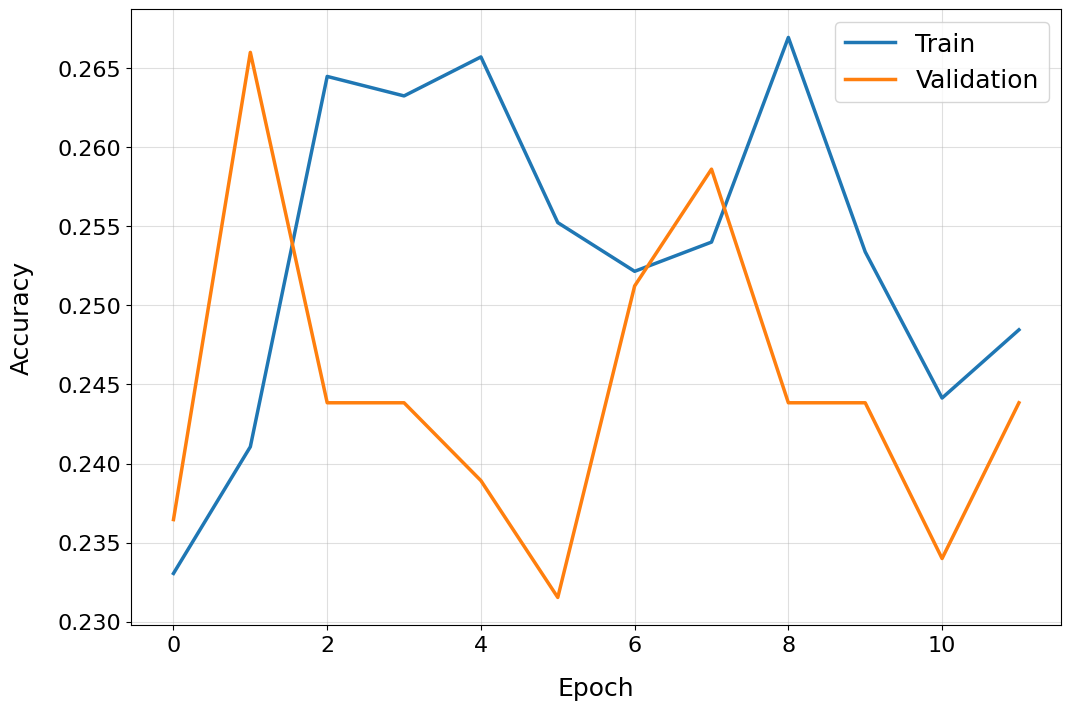

51/51 [==============================] - 2s 34ms/step
train accuracy: 0.251


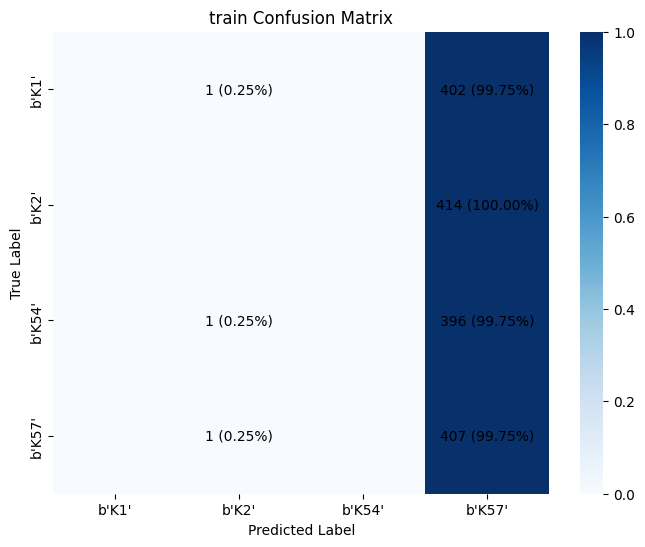

13/13 [==============================] - 0s 36ms/step
val accuracy: 0.244


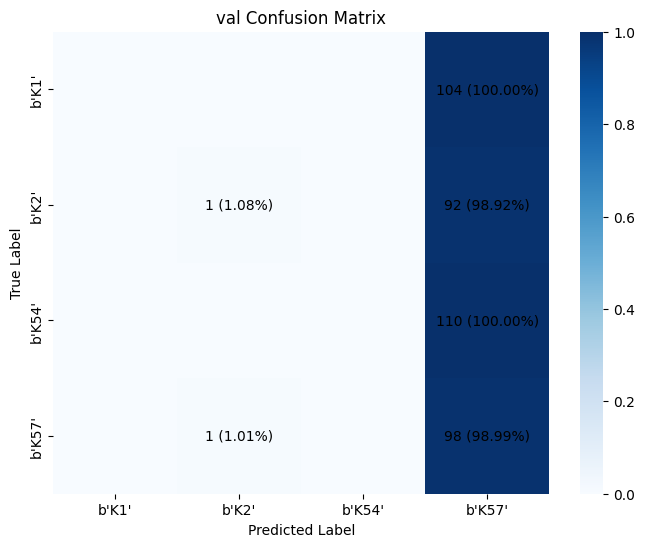

5/5 [==============================] - 0s 30ms/step
test accuracy: 0.205


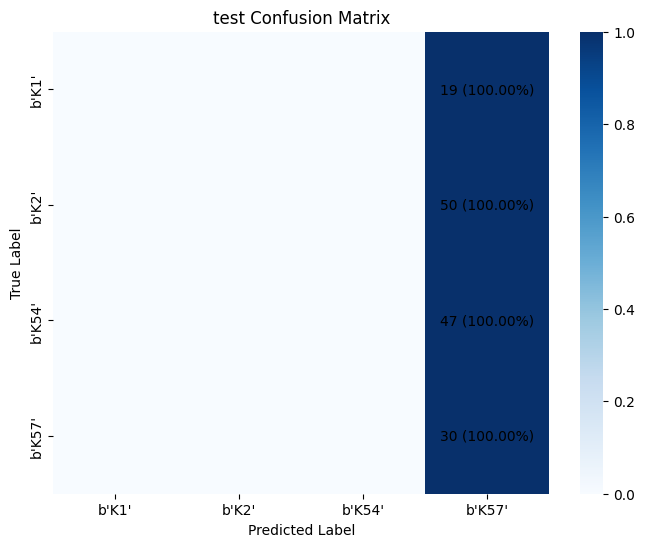

13/13 [==============================] - 1s 48ms/step


In [ ]:


y_perm_train=tf.random.shuffle(y_train)
y_perm_val=tf.random.shuffle(y_val)
y_perm_test=tf.random.shuffle(y_test)


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_perm_train)
y_perm_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_perm_test)
y_perm_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_perm_val)
y_perm_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history2 = model.fit(X_train.to_numpy(), y_perm_train, batch_size=32, epochs=12, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val))

fig, ax = plt.subplots(figsize=(12, 8))

alphaVal = 1
linethick=2.5

plt.plot(history2.history['accuracy'], lw=linethick, alpha=alphaVal)
plt.plot(history2.history['val_accuracy'], lw=linethick, alpha=alphaVal)
plt.grid(alpha=0.4)
#plt.title('Model Accuracy')
plt.ylabel('Accuracy', fontsize=18, labelpad=17)
plt.xlabel('Epoch', fontsize=18, labelpad=15)
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 18})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('fig11a.svg', format='svg', dpi=300)
plt.show()





calcular = [{'que': 'train', 'X': X_train, 'y': y_perm_train},
            {'que': 'val', 'X': X_val, 'y': y_perm_val},
            {'que': 'test', 'X': X_test, 'y': y_perm_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_perm_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_perm_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_perm_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]


results = []

results.append({
    'Nfeatures': len(ramanshifts),
    'train_acc': accuracy_train,
    'val_acc': accuracy_val,
    'unseens_acc': accuracy_test,
    'diagonal_us [K1, K2]': class_accuracies['test']
})


test_accuracy_values_fenotypes = [result['unseens_acc'] for result in results]


### Figure 10

Figure 10: Confusion matrix for unseen data obtained from training a 1-D CNN model with all preprocessed spectra dataset after excluding N1 type spectra from the dataset. The overall accuracy was 81%.

In [ ]:
coincidencias = filtered_data[filtered_data['filename'].isin(espectros_intensos['filename'])]
filtered_spectra_sin_coincidencias = filtered_data[~filtered_data['filename'].isin(coincidencias['filename'])]

<ipython-input-150-05535ad38890>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unseens = filtered_spectra_sin_coincidencias[final_condition]
<ipython-input-150-05535ad38890>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data2 = filtered_spectra_sin_coincidencias[~final_condition]


28/28 [==============================] - 1s 46ms/step
train accuracy: 0.930


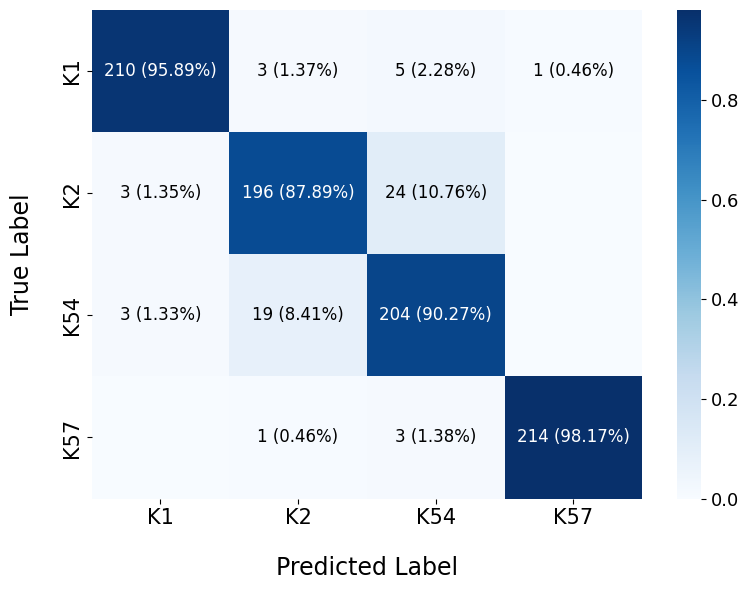

7/7 [==============================] - 0s 53ms/step
val accuracy: 0.905


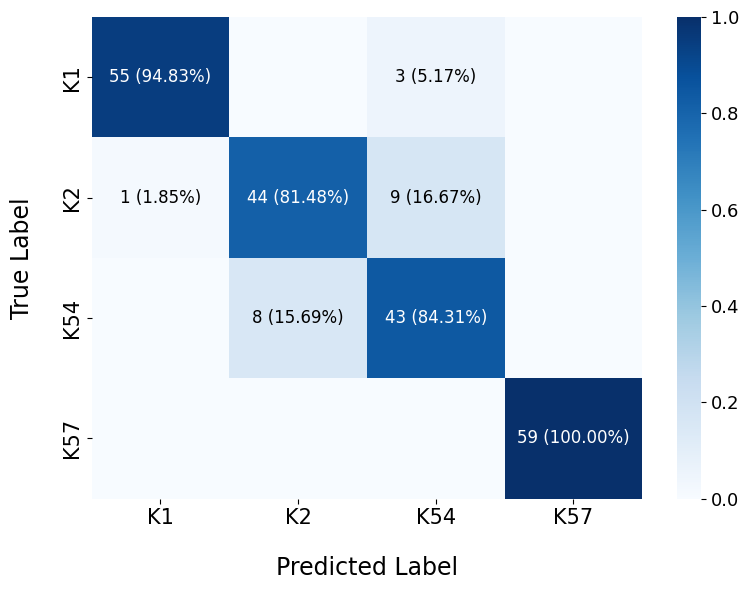

5/5 [==============================] - 0s 47ms/step
test accuracy: 0.807


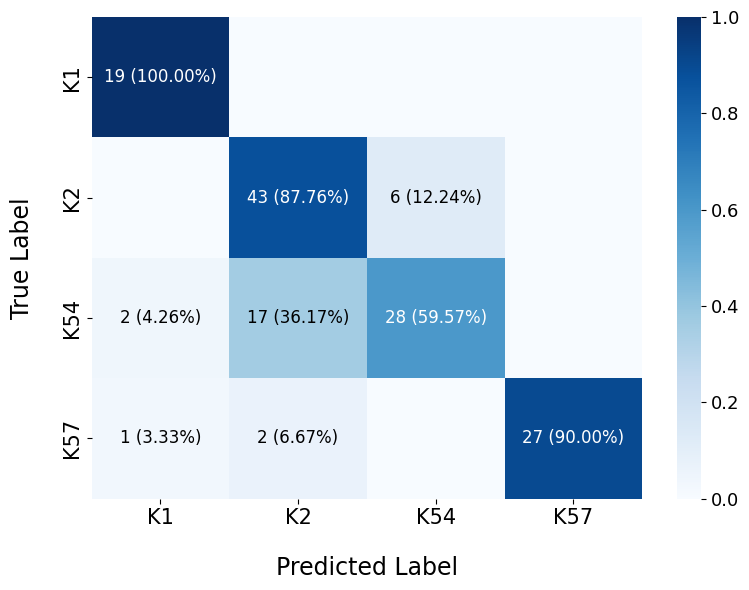

7/7 [==============================] - 0s 62ms/step
Class 0 - Accuracy: 0.98, Recall: 1.00, Precision: 0.86,Specificity: 0.98, F1-Score: 0.93, AUC: 1.0000
Class 1 - Accuracy: 0.83, Recall: 0.88, Precision: 0.69,Specificity: 0.80, F1-Score: 0.77, AUC: 0.9432
Class 2 - Accuracy: 0.83, Recall: 0.60, Precision: 0.82,Specificity: 0.94, F1-Score: 0.69, AUC: 0.9012
Class 3 - Accuracy: 0.98, Recall: 0.90, Precision: 1.00,Specificity: 1.00, F1-Score: 0.95, AUC: 0.9988


In [ ]:

# Load the pre-trained model
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model2_kleb_allfeatures_alfenotypes_quitandointensos.h5')

allspectra = pd.concat([espectros_normales, espectros_intensos], axis=0)

# Segregate unseen spectra without intense samples and filter data accordingly
unseens_withoutintense = filtered_spectra_sin_coincidencias[final_condition]
filtered_data2_withoutintense = filtered_spectra_sin_coincidencias[~final_condition]

# Implementing data balancing to mitigate class imbalance
all_classes = filtered_data2_withoutintense[label].unique()
minority_class_size = filtered_data2_withoutintense[label].value_counts().min()
balanced_trainval_data = pd.DataFrame()

for class_name in all_classes:
    class_samples = filtered_data2_withoutintense[filtered_data2_withoutintense[label] == class_name]
    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval_withoutintense = balanced_trainval_data[label]
balanced_trainval_data_withoutintense = balanced_trainval_data.drop(columns=columns_to_drop).copy()

# Splitting the dataset into training and validation sets
X_train_withoutintense, X_val_withoutintense, y_train_withoutintense, y_val_withoutintense = train_test_split(
    balanced_trainval_data_withoutintense, balanced_y_trainval_withoutintense, test_size=0.20, random_state=1000)

# Assigning the unseen data as the test set
y_test_withoutintense = unseens_withoutintense[label]
X_test_withoutintense = unseens_withoutintense.drop(columns=columns_to_drop).copy()

# Encoding target variables
num_classes_grouped = len(all_classes)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_withoutintense)
y_train_withoutintense = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test_withoutintense)
y_test_withoutintense = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val_withoutintense)
y_val_withoutintense = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

# Define a structure to iterate through different dataset splits for model evaluation
evaluation_data = [{'split': 'train', 'X': X_train_withoutintense, 'y': y_train_withoutintense},
                   {'split': 'validation', 'X': X_val_withoutintense, 'y': y_val_withoutintense},
                   {'split': 'test', 'X': X_test_withoutintense, 'y': y_test_withoutintense}]

class_accuracies = {'train': [], 'validation': [], 'test': []}

# Evaluating the model across different splits and calculating accuracy and confusion matrices
for data in evaluation_data:
    y_predicted = model.predict(data['X'])
    y_predicted_int = tf.argmax(y_predicted, axis=1)
    y_true_int = tf.argmax(data['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_predicted_int)
    print(f"{data['split']} accuracy: {accuracy:.3f}")



y-randomization

<ipython-input-24-4e77e834814e>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unseens = filtered_spectra_sin_coincidencias[final_condition]
<ipython-input-24-4e77e834814e>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data2 = filtered_spectra_sin_coincidencias[~final_condition]


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2400, 64)          576       
                                                                 
 activation_18 (Activation)  (None, 2400, 64)          0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1200, 64)          0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 1200, 64)          0         
                                                                 
 flatten_6 (Flatten)         (None, 76800)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               9830528   
                                                      

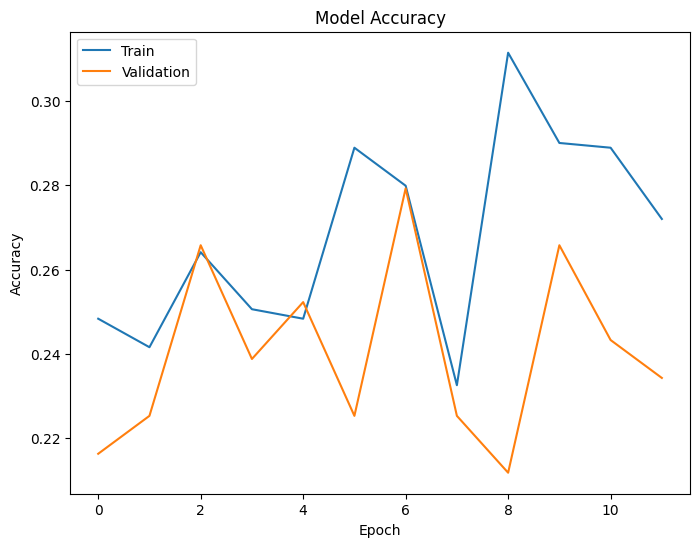

28/28 [==============================] - 1s 35ms/step
train accuracy: 0.296


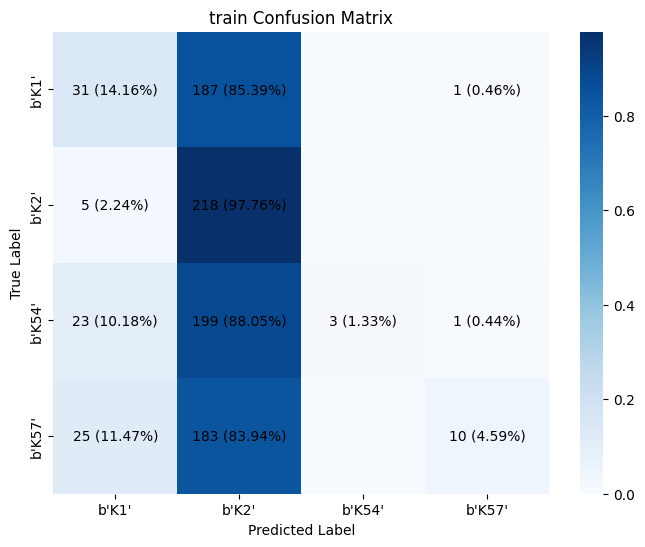

7/7 [==============================] - 0s 33ms/step
val accuracy: 0.234


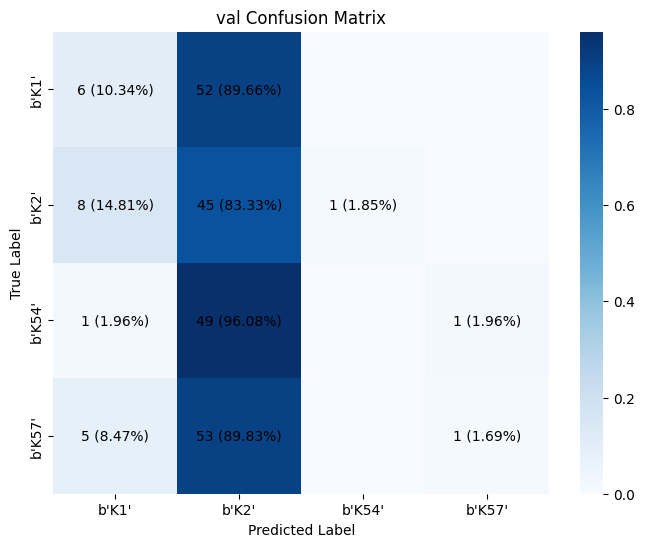

5/5 [==============================] - 0s 30ms/step
test accuracy: 0.324


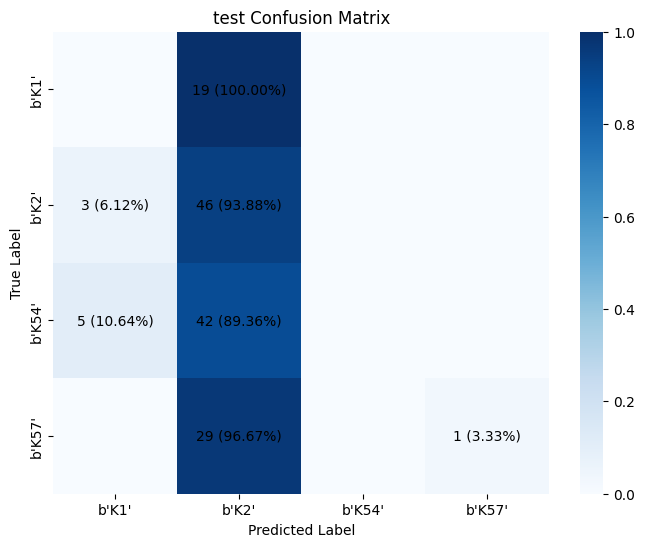

7/7 [==============================] - 0s 36ms/step


In [ ]:
y_perm_train=tf.random.shuffle(y_train)
y_perm_val=tf.random.shuffle(y_val)
y_perm_test=tf.random.shuffle(y_test)


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_perm_train)
y_perm_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_perm_test)
y_perm_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_perm_val)
y_perm_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train.to_numpy(), y_perm_train, batch_size=32, epochs=12, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_perm_train},
            {'que': 'val', 'X': X_val, 'y': y_perm_val},
            {'que': 'test', 'X': X_test, 'y': y_perm_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_perm_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_perm_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_perm_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]


results = []

results.append({
    'Nfeatures': len(ramanshifts),
    'train_acc': accuracy_train,
    'val_acc': accuracy_val,
    'unseens_acc': accuracy_test,
    'diagonal_us [K1, K2]': class_accuracies['test']
})


test_accuracy_values_fenotypes = [result['unseens_acc'] for result in results]

### Figure 11

Figure 11: Y-randomization model training process for a 1-D CNN using the entire preprocessed spectra dataset (a) and Y-randomization model training excluding N1-type spectra from the dataset (b).

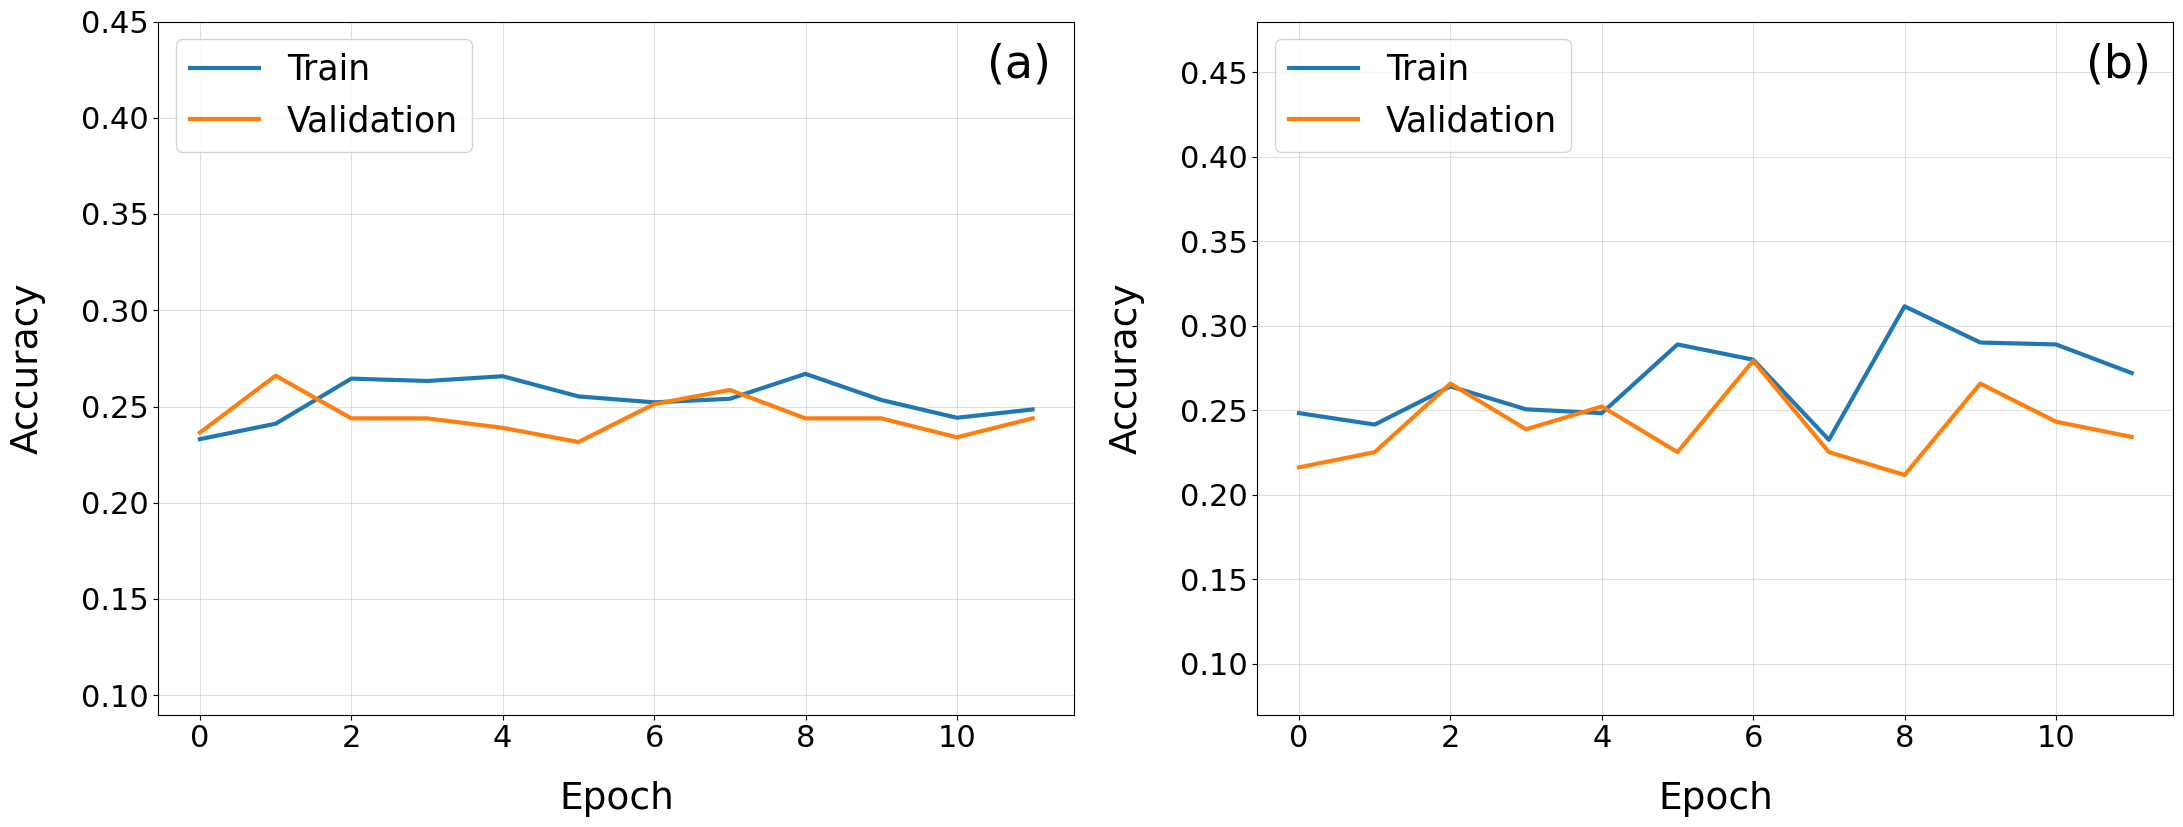

In [ ]:
fig11, (ax11a,ax11b) = plt.subplots(nrows=1, ncols=2, figsize=(26, 9))

alphaVal = 1
linethick = 3

# Plotting in ax14a
ax11a.set_ylim([0.09, 0.45])
ax11a.plot(history2.history['accuracy'], lw=linethick, alpha=alphaVal)
ax11a.plot(history2.history['val_accuracy'], lw=linethick, alpha=alphaVal)
ax11a.grid(alpha=0.4)
ax11a.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax11a.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax11a.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})
ax11a.tick_params(axis='both', which='major', labelsize=22)
ax11a.text(0.905, 0.97, '(a)', transform=ax11a.transAxes, fontsize=33, verticalalignment='top')

# Plotting in ax14b
ax11b.set_ylim([0.07, 0.48])
ax11b.plot(history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax11b.plot(history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
ax11b.grid(alpha=0.4)
ax11b.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax11b.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax11b.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})
ax11b.tick_params(axis='both', which='major', labelsize=22)
ax11b.text(0.905, 0.97, '(b)', transform=ax11b.transAxes, fontsize=33, verticalalignment='top')

# Save the combined figure
fig11.savefig('fig11.svg', format='svg', dpi=300)
plt.show()


### Figure 13

Figure 13: Confusion matrix for the unseen data obtained from training a 1-D CNN model with all preprocessed spectra grouping K2 and K54 serotypes into a single class, ‘K2-K54’, (a) and a confusion matrix obtained from training the same 1-D CNN only with K2 and K54 serotypes (b). The overall accuracies achieved were 99% and 93%, respectively.

In [ ]:
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model3_kleb_allfeatures_3classes.h5')
model_bin = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/model4_kleb_allfeatures_binaryk2k54.h5')

5/5 [==============================] - 0s 70ms/step
test accuracy: 0.993
10/10 [==============================] - 1s 48ms/step
Class 0 - Accuracy: 0.99, Recall: 1.00, Precision: 0.95,Specificity: 0.99, F1-Score: 0.97, AUC: 1.0000
Class 1 - Accuracy: 0.99, Recall: 0.99, Precision: 1.00,Specificity: 1.00, F1-Score: 0.99, AUC: 1.0000
Class 2 - Accuracy: 1.00, Recall: 1.00, Precision: 1.00,Specificity: 1.00, F1-Score: 1.00, AUC: 1.0000
4/4 [==============================] - 0s 42ms/step
test accuracy: 0.928
7/7 [==============================] - 1s 101ms/step
Class 0 - Accuracy: 0.93, Recall: 0.92, Precision: 0.94,Specificity: 0.94, F1-Score: 0.93, AUC: 0.9783
Class 1 - Accuracy: 0.93, Recall: 0.94, Precision: 0.92,Specificity: 0.92, F1-Score: 0.93, AUC: 0.9783


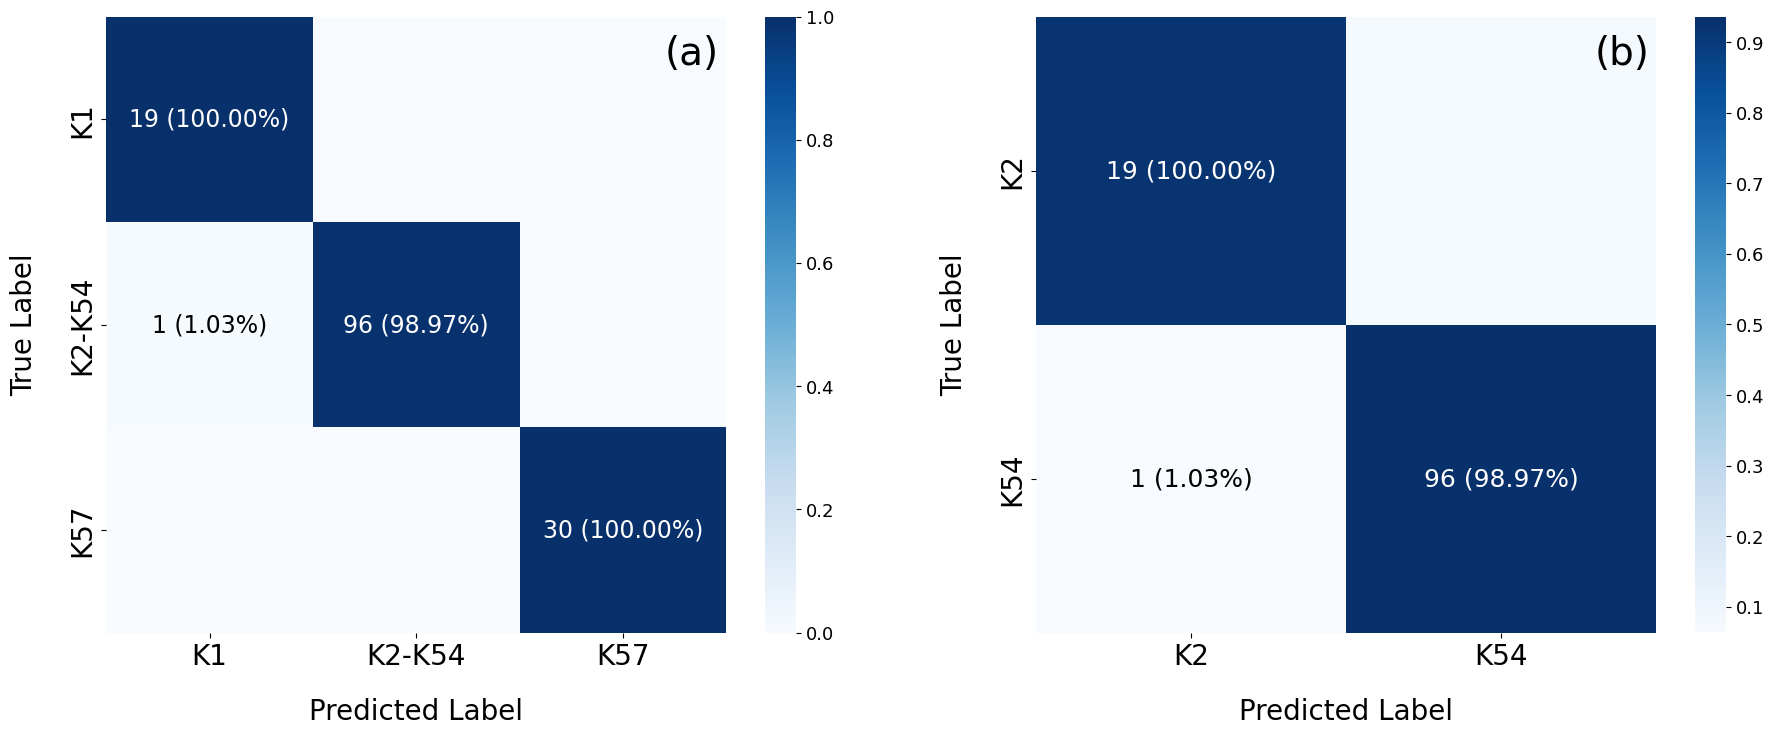

In [ ]:
# Creating a subplot with 2 axes
fig13, (ax13a, ax13b) = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
ax13a.text(0.9, 0.97, '(a)', transform=ax13a.transAxes, fontsize=28, verticalalignment='top')
ax13b.text(0.9, 0.97, '(b)', transform=ax13b.transAxes, fontsize=28, verticalalignment='top')




# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2-K54' if x == 'K2' else ('K2-K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2-K54', 'K54-K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]


label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)


calcular = [
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = { 'test': []}


for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums


    sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', ax=ax13a, xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                ax13a.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color, fontsize=17)

    ax13a.set_xlabel('Predicted Label', fontsize=20, labelpad=20)
    ax13a.set_ylabel('True Label', fontsize=20, labelpad=22)
    plt.xticks( fontsize=15)
    plt.yticks(fontsize=15)
    cbar = sns_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)



y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[0]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]



y_pred_int_np = np.argmax(y_pred, axis=1)
y_test_int_np = np.argmax(y_test, axis=1)

class_metrics = []

for i in range(num_classes_grouped):
    tp = cm[i, i]  # True Positive
    fn = cm[i, :].sum() - tp  # False Negative
    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
    fp = cm[:, i].sum() - tp  # False Positive

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

    # Create one-hot encoded y_true_class for the current class
    y_true_class = np.zeros((len(y_test_int_np),))
    y_true_class[y_test_int_np == i] = 1

    # Probability scores for the current class
    y_score_class = y_pred[:, i]

    # Calculate AUC
    auc = roc_auc_score(y_true_class, y_score_class)

    class_metrics.append({
        'Class': i,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'AUC': auc
    })

for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
          f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
          f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
          f"AUC: {metrics['AUC']:.4f}")



if 'K2-K54' in binary_data['fenotype_grouped'].values or 'K54-K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)


    calcular_bin = [
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = { 'test': []}



    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)


        sns_heatmap = sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', ax= ax13b, xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm[i, j]
                if value != 0 and not np.isnan(cm_normalized[i, j]):
                    text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                    text_color = "white" if cm_normalized_bin[i, j] > 0.5 else "black"
                    ax13b.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color, fontsize=18)
        ax13b.set_xlabel('Predicted Label', fontsize=20, labelpad=20)
        ax13b.set_ylabel('True Label', fontsize=20, labelpad=22)
        plt.xticks( fontsize=15)
        plt.yticks(fontsize=15)
        cbar = sns_heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=13)



    class_accuracies_bin[calcular_bin[0]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

    y_pred_bin = model_bin.predict(X_test_bin)
    y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
    y_test_int_bin = tf.argmax(y_test_bin, axis=1)
    accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

    y_pred_train_bin = model_bin.predict(X_train_bin)
    y_pred_val_bin = model_bin.predict(X_val_bin)

    y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
    y_train_int_bin = tf.argmax(y_train_bin, axis=1)
    accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

    y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
    y_val_int_bin = tf.argmax(y_val_bin, axis=1)
    accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

    class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]


    y_pred_int_bin_np = np.argmax(y_pred_bin, axis=1)
    y_test_int_bin_np = np.argmax(y_test_bin, axis=1)

    cm = cm_bin
    class_metrics = []

    for i in range(all_classes_bin):
        tp = cm[i, i]  # True Positive
        fn = cm[i, :].sum() - tp  # False Negative
        tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
        fp = cm[:, i].sum() - tp  # False Positive

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

        # Create one-hot encoded y_true_class for the current class
        y_true_class = np.zeros((len(y_test_int_bin_np),))
        y_true_class[y_test_int_bin_np == i] = 1

        # Probability scores for the current class
        y_score_class = y_pred_bin[:, i]

        auc = roc_auc_score(y_true_class, y_score_class)

        class_metrics.append({
            'Class': i,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'Specificity': specificity,
            'F1-Score': f1_score,
            'AUC': auc
        })

    for metrics in class_metrics:
        print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
              f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
              f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
              f"AUC: {metrics['AUC']:.4f}")


# Setting labels, titles, legends, and formatting for ax8a and ax8b
for ax in [ax13a, ax13b]:
    ax.tick_params(axis='both', labelsize=20)

fig13.savefig('fig13.svg', format='svg', dpi=300)
plt.show()



### Figure 14

Figure 14: Y-randomization model training process for a 1-D CNN grouping K2 and K54 serotypes into a single class (a), and Y-randomization model training only with K2 and K54 serotypes (b).

y-randomization

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2400, 64)          576       
                                                                 
 activation_9 (Activation)   (None, 2400, 64)          0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1200, 64)          0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 1200, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 76800)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               9830528   
                                                      

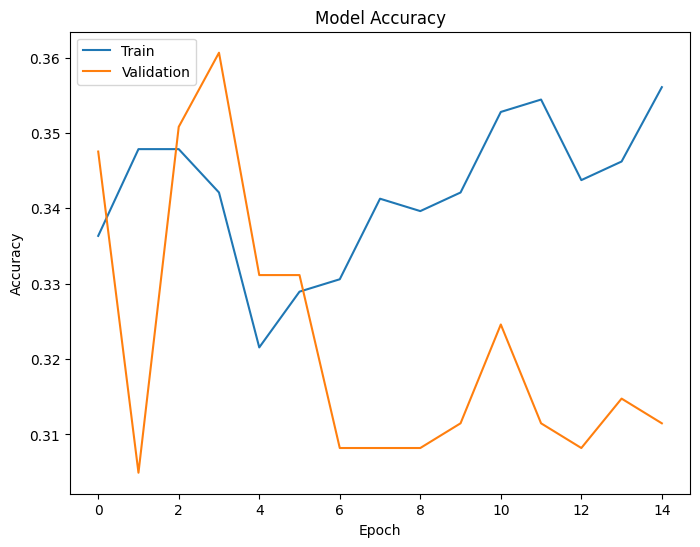

38/38 [==============================] - 1s 36ms/step
train accuracy: 0.361


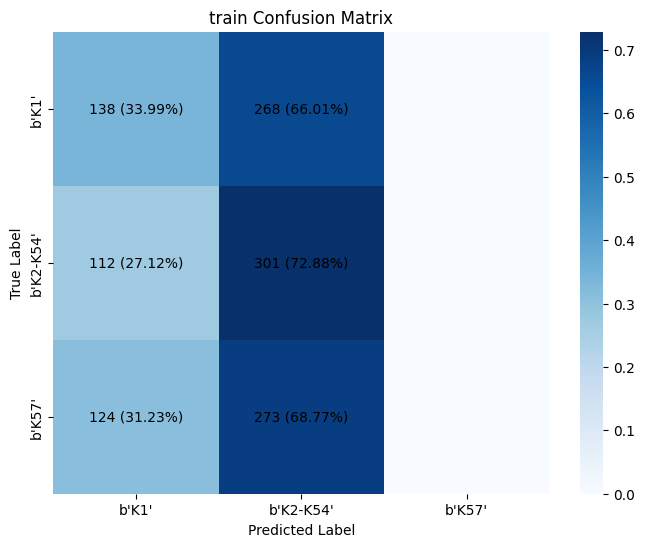

10/10 [==============================] - 1s 44ms/step
val accuracy: 0.311


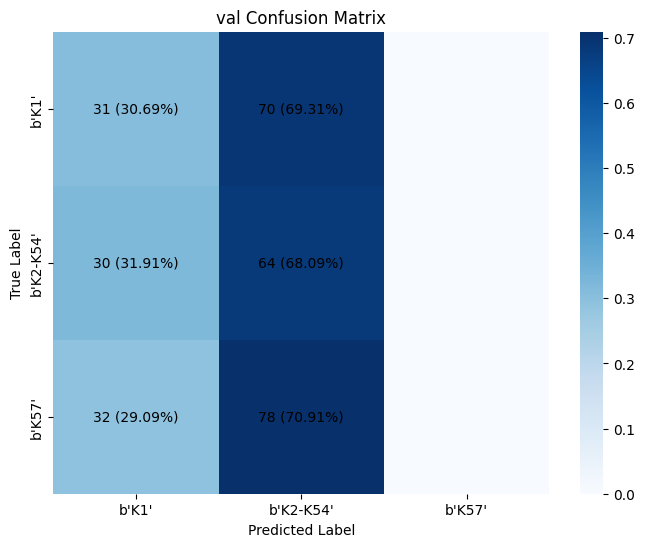

5/5 [==============================] - 0s 50ms/step
test accuracy: 0.651


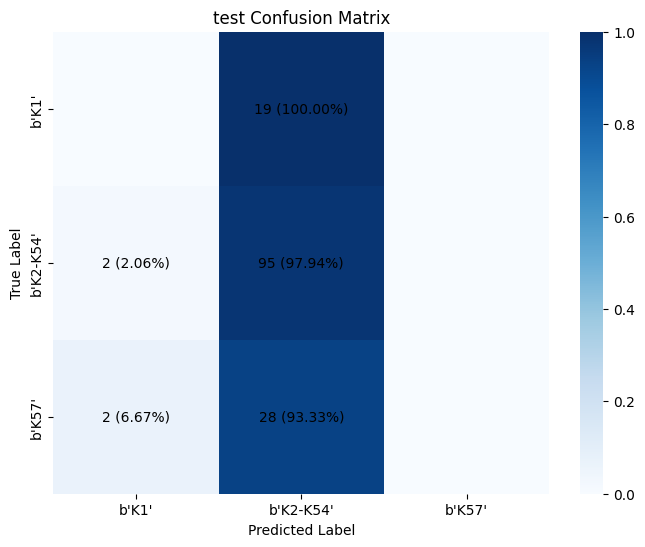

10/10 [==============================] - 0s 28ms/step
Epoch 1/15
28/28 - 8s - loss: 0.6932 - accuracy: 0.5045 - val_loss: 0.6932 - val_accuracy: 0.4732 - 8s/epoch - 302ms/step
Epoch 2/15
28/28 - 8s - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.4866 - 8s/epoch - 274ms/step
Epoch 3/15
28/28 - 8s - loss: 0.6925 - accuracy: 0.5290 - val_loss: 0.6940 - val_accuracy: 0.4777 - 8s/epoch - 280ms/step
Epoch 4/15
28/28 - 7s - loss: 0.6934 - accuracy: 0.4944 - val_loss: 0.6935 - val_accuracy: 0.4911 - 7s/epoch - 257ms/step
Epoch 5/15
28/28 - 8s - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6938 - val_accuracy: 0.4688 - 8s/epoch - 299ms/step
Epoch 6/15
28/28 - 7s - loss: 0.6924 - accuracy: 0.5089 - val_loss: 0.7023 - val_accuracy: 0.4911 - 7s/epoch - 245ms/step
Epoch 7/15
28/28 - 8s - loss: 0.6967 - accuracy: 0.5112 - val_loss: 0.6937 - val_accuracy: 0.4821 - 8s/epoch - 290ms/step
Epoch 8/15
28/28 - 7s - loss: 0.6923 - accuracy: 0.5100 - val_loss: 0.6941 - val_accuracy: 0

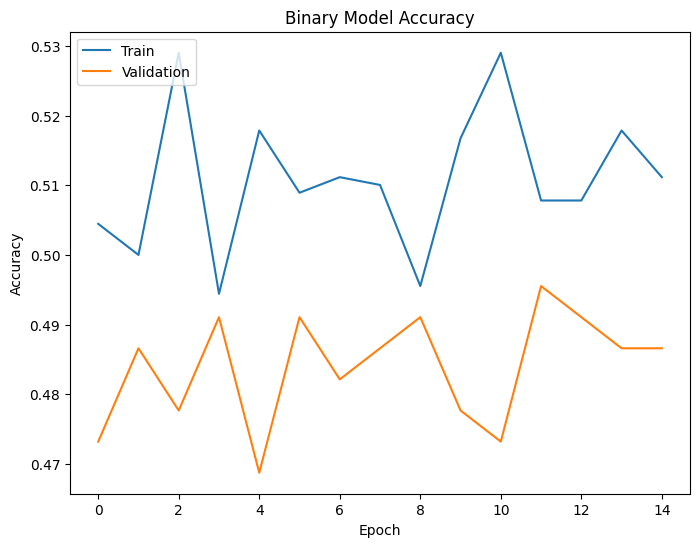

28/28 [==============================] - 1s 48ms/step
train accuracy: 0.509


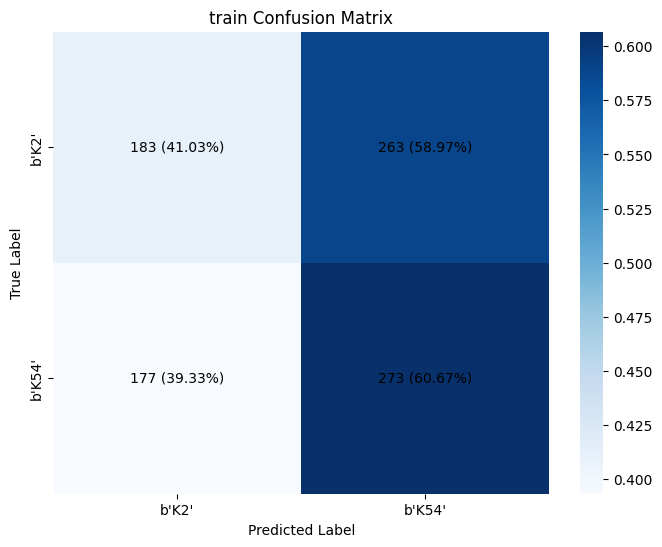

7/7 [==============================] - 0s 45ms/step
val accuracy: 0.487


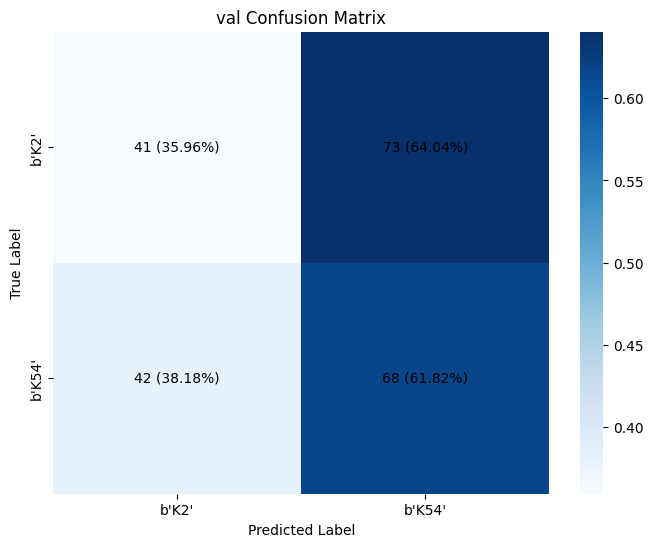

4/4 [==============================] - 0s 24ms/step
test accuracy: 0.515


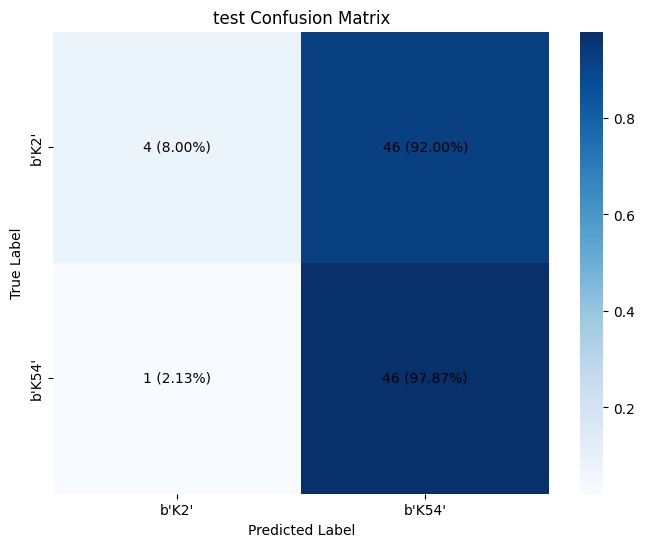

7/7 [==============================] - 0s 31ms/step


In [ ]:

# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2-K54' if x == 'K2' else ('K2-K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2-K54', 'K54-K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# i separate spectra from specific isolates measued on different days as "unseens" (ensuring that an adequate n of spectra remain in the train/val dataset for that isolate)
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition


unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']



label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()




y_perm_train=tf.random.shuffle(y_train,seed=1000)
y_perm_val=tf.random.shuffle(y_val,seed=1000)
y_perm_test=tf.random.shuffle(y_test,seed=1000)


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_perm_train)
y_perm_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_perm_test)
y_perm_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_perm_val)
y_perm_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train.to_numpy(), y_perm_train, batch_size=32, epochs=15, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_perm_train},
            {'que': 'val', 'X': X_val, 'y': y_perm_val},
            {'que': 'test', 'X': X_test, 'y': y_perm_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_perm_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_perm_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_perm_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]


if 'K2-K54' in binary_data['fenotype_grouped'].values or 'K54-K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    y_train_bin=tf.random.shuffle(y_train_bin,seed=1000)
    y_val_bin=tf.random.shuffle(y_val_bin,seed=1000)
    y_test_bin=tf.random.shuffle(y_test_bin,seed=1000)



    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)

    binary_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model_bin = tf.keras.models.Sequential(model.layers[:-1])  # Remove the last layer with 3 units
    model_bin.add(tf.keras.layers.Dense(2, activation='softmax'))  # Add new last layer with 2 units
    model_bin.compile(loss='categorical_crossentropy', optimizer=binary_optimizer, metrics=['accuracy'])

    binary_history = model_bin.fit(X_train_bin.to_numpy(), y_train_bin, batch_size=32, epochs=15, verbose=2, validation_data=(X_val_bin.to_numpy(), y_val_bin))

    plt.figure(figsize=(8, 6))
    plt.plot(binary_history.history['accuracy'])
    plt.plot(binary_history.history['val_accuracy'])
    plt.title('Binary Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    calcular_bin = [{'que': 'train', 'X': X_train_bin, 'y': y_train_bin},
                    {'que': 'val', 'X': X_val_bin, 'y': y_val_bin},
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'train': [], 'val': [], 'test': []}

    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        plt.figure(figsize=(8, 6))
        plt.title(f"{calcular_bin[i]['que']} Confusion Matrix")
        sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm_bin[i, j]
                if value != 0 and not np.isnan(cm_normalized_bin[i, j]):
                    text = f"{value} ({cm_normalized_bin[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    class_accuracies_bin[calcular_bin[2]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

    y_pred_bin = model_bin.predict(X_test_bin)
    y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
    y_test_int_bin = tf.argmax(y_test_bin, axis=1)
    accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

    y_pred_train_bin = model_bin.predict(X_train_bin)
    y_pred_val_bin = model_bin.predict(X_val_bin)

    y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
    y_train_int_bin = tf.argmax(y_train_bin, axis=1)
    accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

    y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
    y_val_int_bin = tf.argmax(y_val_bin, axis=1)
    accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

    class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]




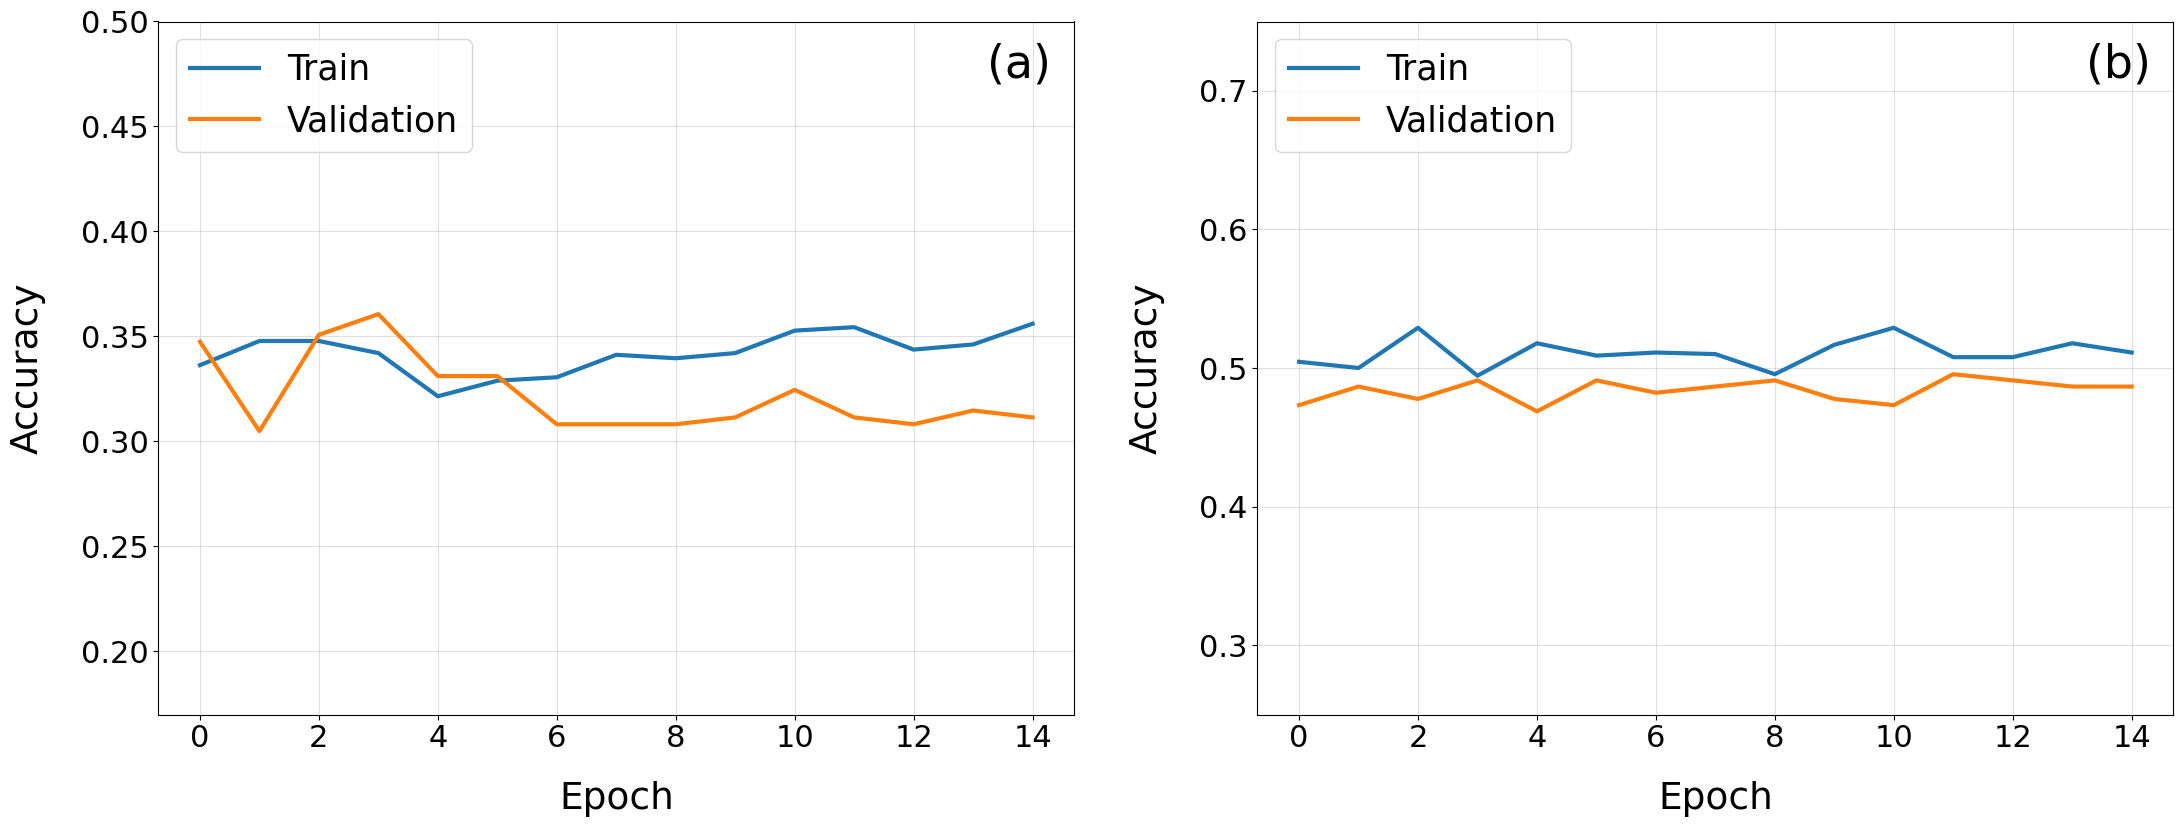

In [ ]:
fig14, (ax14a,ax14b) = plt.subplots(nrows=1, ncols=2, figsize=(26, 9))

alphaVal = 1
linethick = 3

# Plotting in ax14a
ax14a.set_ylim([0.17, 0.50])
ax14a.plot(history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax14a.plot(history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
ax14a.grid(alpha=0.4)
ax14a.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax14a.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax14a.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})
ax14a.tick_params(axis='both', which='major', labelsize=22)
ax14a.text(0.905, 0.97, '(a)', transform=ax14a.transAxes, fontsize=33, verticalalignment='top')

# Plotting in ax14b
ax14b.set_ylim([0.25, 0.75])
ax14b.plot(binary_history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax14b.plot(binary_history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
ax14b.grid(alpha=0.4)
ax14b.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax14b.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax14b.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})
ax14b.tick_params(axis='both', which='major', labelsize=22)
ax14b.text(0.905, 0.97, '(b)', transform=ax14b.transAxes, fontsize=33, verticalalignment='top')

# Save the combined figure
fig14.savefig('fig14.svg', format='svg', dpi=300)
plt.show()

# 3.3. Dimensionality reduction

### Figure 15

Figure 15: Dimensionality reduction of Raman spectra by averaging consecutive features.

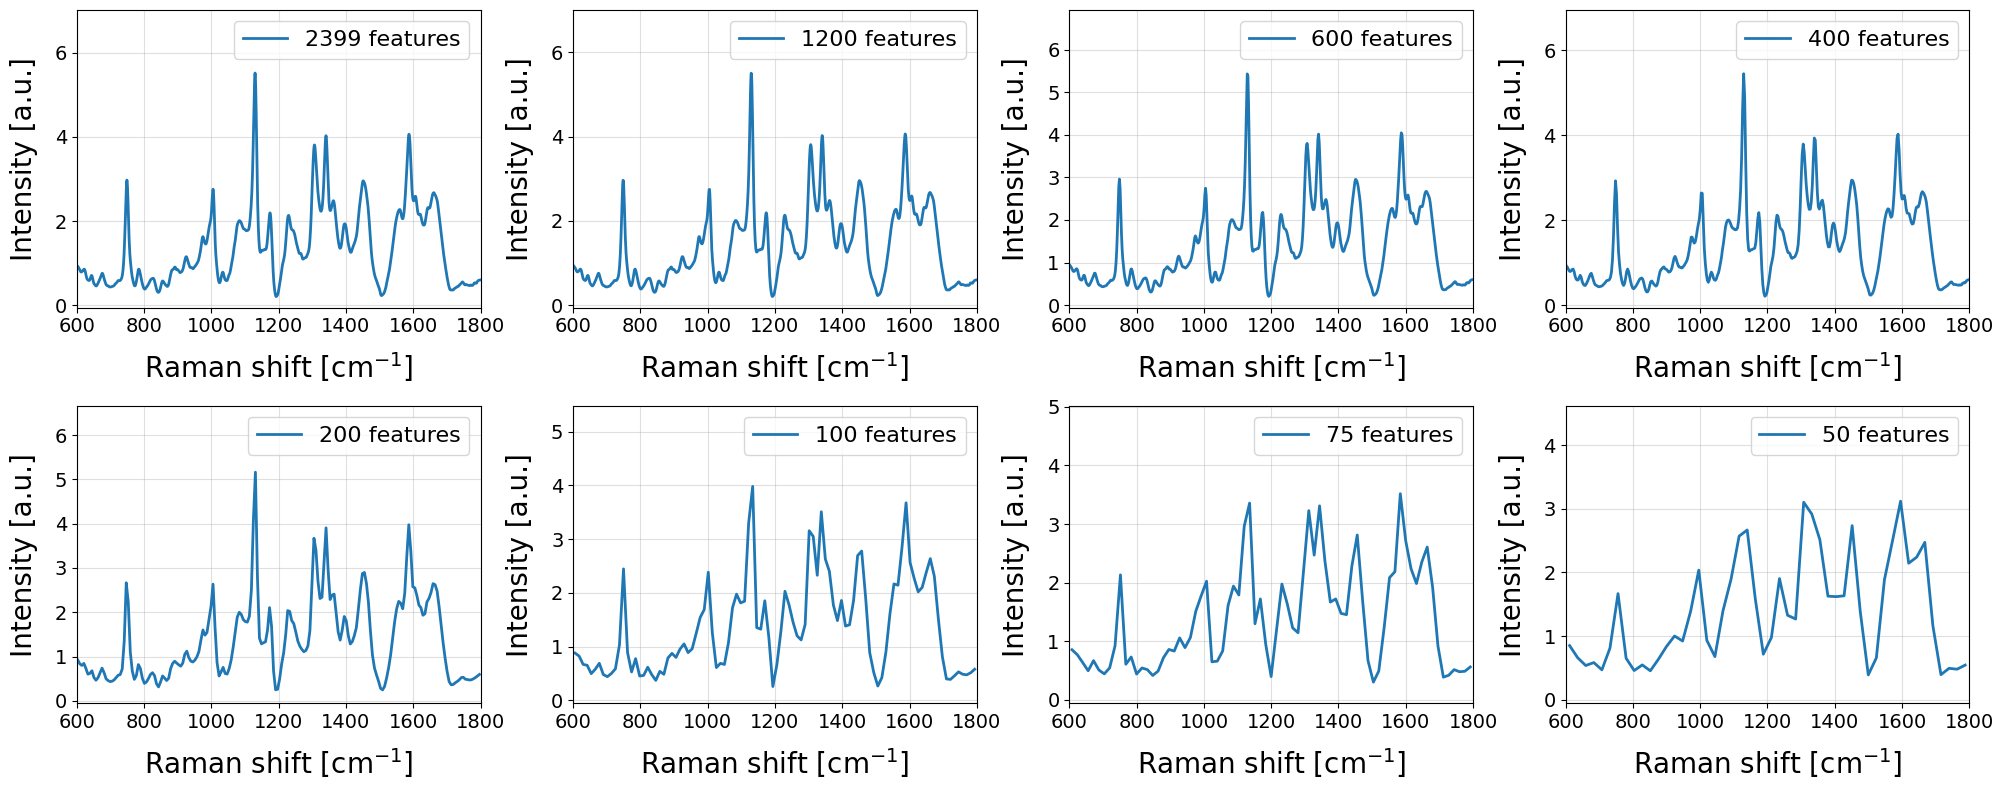

In [47]:
# Define the step sizes for dimensionality reduction
steps = [1, 2, 4, 6, 12, 24, 32, 48]

# Initialize a figure with subplots arranged in a 2x4 grid
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.ravel()

# Pre-processing to exclude non-feature columns
spectral_data = filtered_data.iloc[:, :-10]

for idx, step in enumerate(steps):
    # Calculate the reduced number of features
    num_reduced_features = np.ceil(len(spectral_data.columns) / step).astype(int)

    # Initialize lists to store reduced data
    reduced_spectra = []
    reduced_ramanshifts = []

    # Perform averaging over the specified step size
    for i in range(0, len(spectral_data.columns), step):
        averaged_spectrum = spectral_data.iloc[:, i:i+step].mean(axis=1)
        reduced_spectra.append(averaged_spectrum)
        reduced_ramanshifts.append(np.mean(ramanshifts[i:i+step]))

    # Combine reduced spectra into a DataFrame
    reduced_df = pd.concat(reduced_spectra, axis=1)
    reduced_df.columns = reduced_ramanshifts

    # Plotting the mean spectrum for the current step size
    axs[idx].plot(reduced_ramanshifts, reduced_df.mean(axis=0), label=f'{num_reduced_features} features', lw=2)
    axs[idx].legend(loc='upper right', fontsize=16)
    axs[idx].grid(alpha=0.4)
    axs[idx].set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=20, labelpad=10)
    axs[idx].set_ylabel(r'Intensity [a.u.]', fontsize=20, labelpad=12)
    axs[idx].set_xlim([600, 1800])
    axs[idx].tick_params(axis='both', which='major', labelsize=14)
    axs[idx].set_ylim([ax.get_ylim()[0], reduced_df.mean(axis=0).max() + 1.5])

plt.tight_layout()
plt.savefig('dimensionality_reduction.svg', format='svg', dpi=300)
plt.show()

In [38]:
# Set the step size for reducing the number of features
steps = [4]

# Loop through each step size (though there is only one in this case)
for idx, step in enumerate(steps):
    # Calculate the number of columns after reduction
    num_reduced_columns = len(filtered_data.iloc[:, :-9].columns) // step

    # Initialize lists to store the reduced columns and Raman shifts
    reduced_columns = []
    reduced_ramanshifts = []

    # Iterate over the columns in steps and average the data within each step
    for i in range(0, len(filtered_data.iloc[:, :-9].columns), step):
        # Average columns in the range [i, i+step)
        avg_columns = filtered_data.iloc[:, :-9].iloc[:, i:i + step].mean(axis=1)
        reduced_columns.append(avg_columns)

        # Calculate the average Raman shift for the current range
        reduced_ramanshifts.append(np.mean(ramanshifts[i:i + step]))

    # Concatenate the reduced columns to form a new DataFrame
    filtered_data_reduced = pd.concat(reduced_columns, axis=1)

    # Set the new column names to be the averaged Raman shifts
    filtered_data_reduced.columns = reduced_ramanshifts

# Add additional columns to the reduced data from the original dataset
filtered_data_reduced[columns_to_drop] = filtered_data[columns_to_drop]

In [ ]:
import statistics

k1-k2k54-k57, y k2-k54

### Figure 16

Figure 16: Accuracy variations in 1-D CNN models as Raman spectra dimensionality decreases. Three cases are considered, color-coded as follows: classifying into 4 serotypes (K1, K2, K54, K57) in blue, grouping K2 and K54 (K1, K2-54, K7) in orange, and binary classification (K2 vs. K54) in green.

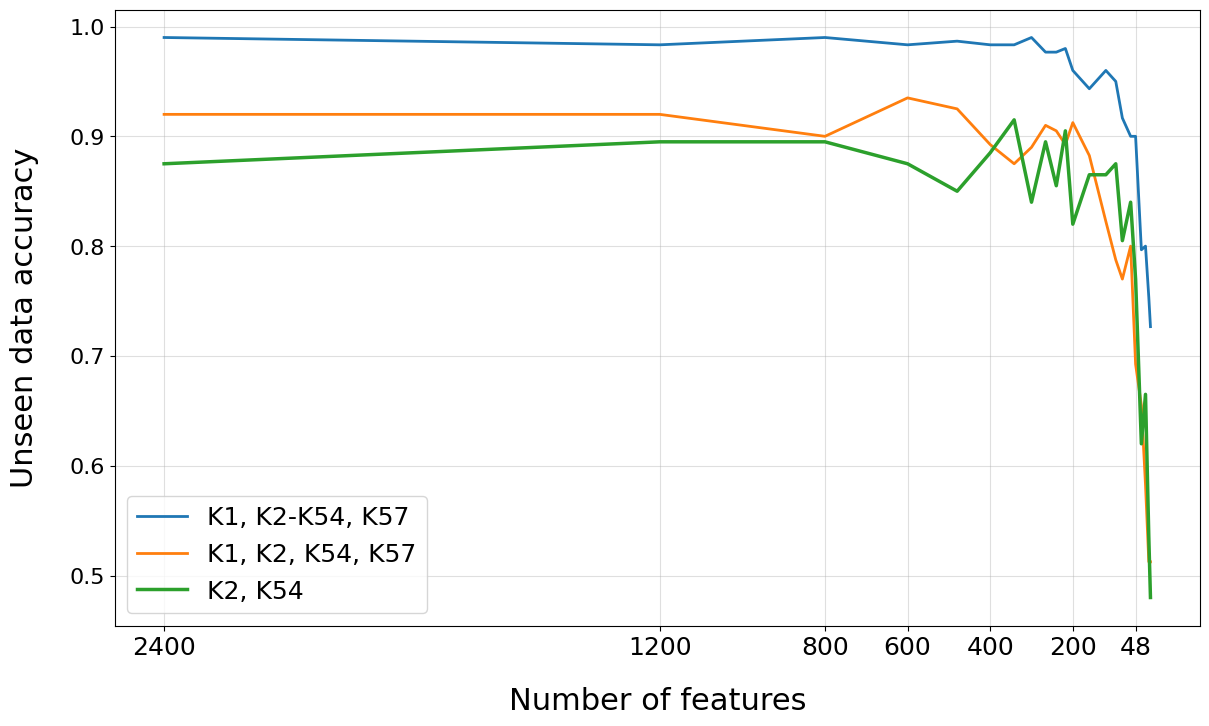

In [71]:
# Loading test accuracy values
test_accuracy_values = pd.read_csv('/content/drive/MyDrive/klebsiellas/test_accuracy_values.csv')

# Defining the initial number of features and calculating the number of features
# for different reduction steps based on division
features_step_1 = 2400
steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30, 40, 50, 70, 100, 150, 200]
num_features_list = [features_step_1 // step for step in steps]
feature_steps_list2 = [(1800 - 600) / x for x in feature_steps_list]

fig, ax = plt.subplots(figsize=(14, 8))
# Plotting test accuracy values for different configurations against the number of features
plt.plot(num_features_list, test_accuracy_values['K1_K2K54_K57'][0:22], label='K1, K2-K54, K57', linewidth=2)
plt.plot(num_features_list, test_accuracy_values['K1_K2_K54_K57'][0:22], label='K1, K2, K54, K57', linewidth=2)
plt.plot(num_features_list, test_accuracy_values['onlyK2K54'][0:22], label='K2, K54', linewidth=2.5)
plt.xlabel('Number of features', fontsize=22, labelpad=20)
plt.ylabel('Unseen data accuracy', fontsize=22, labelpad=22)
plt.yticks(fontsize=16)
plt.grid(alpha=0.4)
plt.legend(loc='lower left', fontsize=18)
plt.xticks(num_features_list2, fontsize=18)
plt.gca().invert_xaxis()
plt.savefig('fig16.svg', format='svg', dpi=300)
plt.show()

In [ ]:
filtered_data_reduced[columns_to_drop] = filtered_data[columns_to_drop]

### Figure 17

Figure 17: Saliency plots correspond to all possible pairs of serotypes.

In [ ]:
output_diff_df_k1k2 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k1k2.csv')
output_diff_df_k1k54 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k1k54.csv')
output_diff_df_k1k57 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k1k57.csv')
output_diff_df_k2k54 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k2k54.csv')
output_diff_df_k2k57 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k57k2.csv')
output_diff_df_k54k57 = pd.read_csv('/content/drive/MyDrive/klebsiellas/resultadossaliencias/output_diff_df_k57k54.csv')

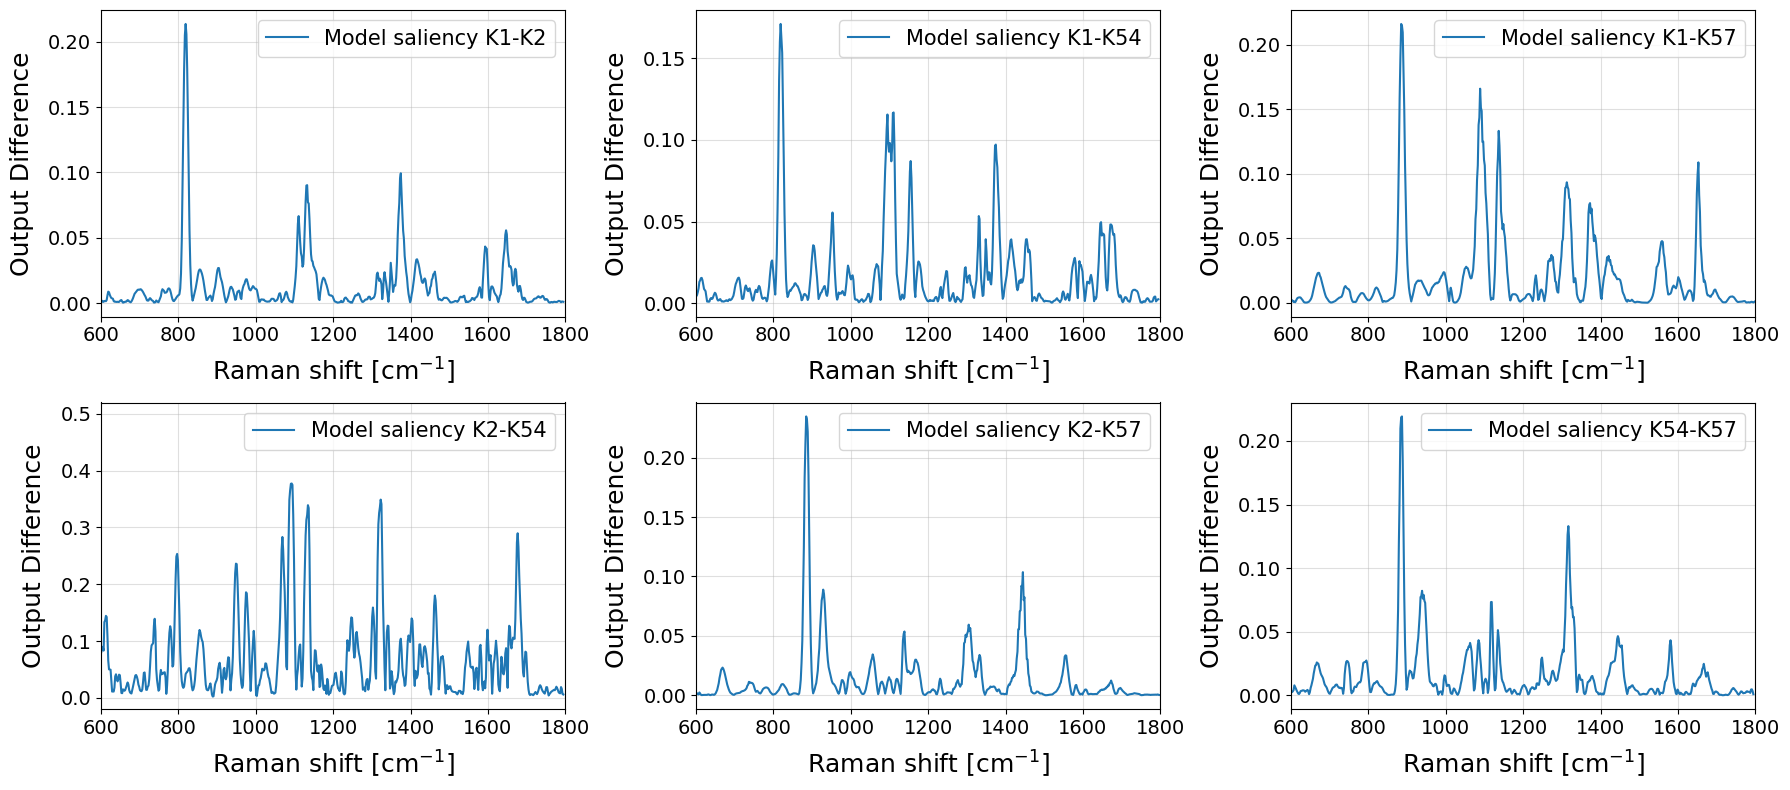

In [ ]:

fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Data and labels for each subplot
data = [
    (output_diff_df_k1k2.iloc[:, 0], output_diff_df_k1k2.iloc[:, 1], 'Model saliency K1-K2'),
    (output_diff_df_k1k54.iloc[:, 0], output_diff_df_k1k54.iloc[:, 1], 'Model saliency K1-K54'),
    (output_diff_df_k1k57.iloc[:, 0], output_diff_df_k1k57.iloc[:, 1], 'Model saliency K1-K57'),
    (output_diff_df_k2k54.iloc[:, 0], output_diff_df_k2k54.iloc[:, 1], 'Model saliency K2-K54'),
    (output_diff_df_k2k57.iloc[:, 0], output_diff_df_k2k57.iloc[:, 1], 'Model saliency K2-K57'),
    (output_diff_df_k54k57.iloc[:, 0], output_diff_df_k54k57.iloc[:, 1], 'Model saliency K54-K57')
]

# Iterate over the grid and populate with data
for ax, (x, y, label) in zip(axs.flatten(), data):
    ax.plot(x, y, color='C0', label=label, lw=1.5)
    ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=18, labelpad=8)
    ax.set_ylabel('Output Difference', fontsize=18, labelpad=10)
    ax.legend(loc='upper right', prop={'size': 15})
    ax.grid(True, alpha=0.4)
    ax.set_xlim([600, 1800])
    ax.tick_params(axis='both', which='major', labelsize=14)

axs[1, 0].set_ylim([-0.02, 0.52])
plt.tight_layout()
plt.savefig('fig17.svg', format='svg', dpi=300)
plt.show()


### Figure 18

Figure 18: Average contribution of each capsular serotype to the saliency: K1 (a), K2 (b), K54 (c) and K57 (d).

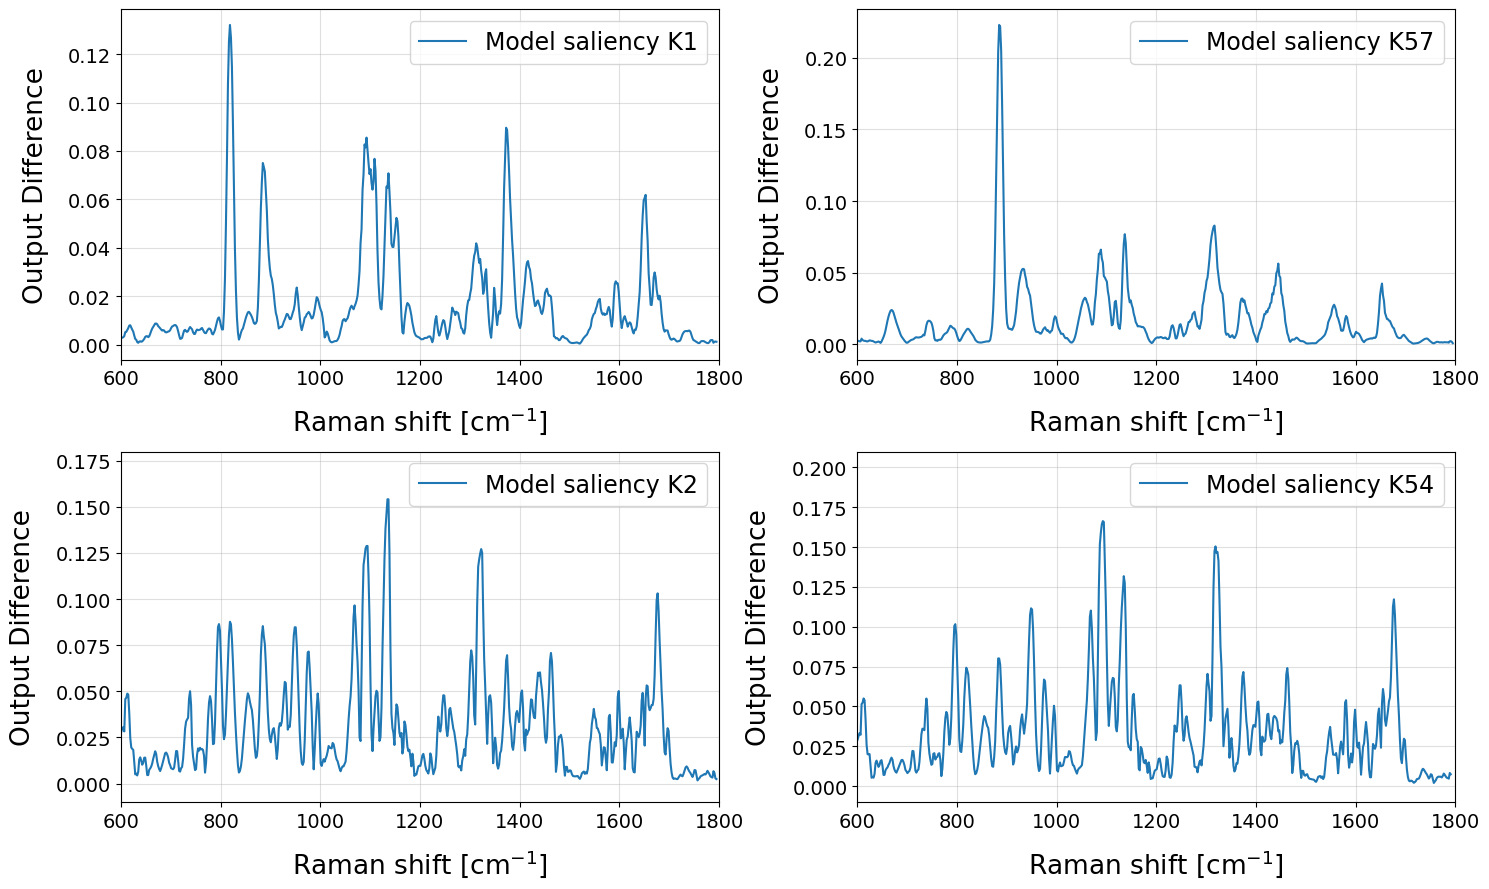

In [ ]:


fig, axs = plt.subplots(2, 2, figsize=(15, 9))

# Data processing and plotting for each subplot
# For K1 average
avg_k1 = pd.DataFrame((output_diff_df_k1k2.iloc[:, 1] + output_diff_df_k1k54.iloc[:, 1] + output_diff_df_k1k57.iloc[:-2, 1]) / 3)
axs[0, 0].plot(output_diff_df_k1k2.iloc[:, 0], avg_k1, color='C0', label='Model saliency K1', lw=1.5)

# For K2 average
avg_k2 = pd.DataFrame((output_diff_df_k1k2.iloc[:, 1] + output_diff_df_k2k54.iloc[:, 1] + output_diff_df_k2k57.iloc[:-2, 1]) / 3)
axs[1, 0].plot(output_diff_df_k2k54.iloc[:, 0], avg_k2, color='C0', label='Model saliency K2', lw=1.5)

# For K57 average
avg_k57 = pd.DataFrame((output_diff_df_k1k57.iloc[:-2, 1] + output_diff_df_k54k57.iloc[:, 1] + output_diff_df_k2k57.iloc[:-2, 1]) / 3)
axs[0, 1].plot(output_diff_df_k54k57.iloc[:, 0], avg_k57, color='C0', label='Model saliency K57', lw=1.5)

# For K54 average
avg_k54 = pd.DataFrame((output_diff_df_k1k54.iloc[:-2, 1] + output_diff_df_k54k57.iloc[:, 1] + output_diff_df_k2k54.iloc[:-2, 1]) / 3)
axs[1, 1].plot(output_diff_df_k54k57.iloc[:, 0], avg_k54, color='C0', label='Model saliency K54', lw=1.5)

# Set common properties for all subplots
for ax in axs.flat:
    ax.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=19, labelpad=12)
    ax.set_ylabel('Output Difference', fontsize=19, labelpad=14)
    ax.grid(True, alpha=0.4)
    ax.set_xlim([600, 1800])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(loc='upper right', prop={'size': 17})



# Adjust y-limits for specific subplots if necessary
axs[1, 0].set_ylim([-0.01, 0.18])
axs[1, 1].set_ylim([-0.01, 0.21])

plt.tight_layout()
plt.savefig('fig18.svg', format='svg', dpi=300)
plt.show()



In [ ]:
def calculate_peaks_and_valleys_with_ranges(spectrum, threshold=0.04, prominence=0.025, range_width=3):
    peaks, _ = find_peaks(spectrum, height=threshold, prominence=prominence)
    peak_heights = _['peak_heights']  # Obtener las alturas de los picos

    sorted_peak_indices = sorted(range(len(peak_heights)), key=lambda k: peak_heights[k], reverse=True)
    sorted_peaks = [peaks[i] for i in sorted_peak_indices]

    peak_ranges = [(reduced_ramanshifts[peak] - range_width, reduced_ramanshifts[peak] + range_width) for peak in sorted_peaks]
    return peak_ranges


salienciask1 = (output_diff_df_k1k2.iloc[:, 1] + output_diff_df_k1k54.iloc[:, 1] + output_diff_df_k1k57.iloc[:-2, 1])/3
salienciask2 = (output_diff_df_k1k2.iloc[:, 1] + output_diff_df_k2k54.iloc[:, 1] + output_diff_df_k2k57.iloc[:-2, 1])/3

salienciask54 = (output_diff_df_k2k54.iloc[:, 1] + output_diff_df_k54k57.iloc[:, 1] + output_diff_df_k1k54.iloc[:, 1])/3

salienciask57 = (output_diff_df_k1k57.iloc[:-2, 1] + output_diff_df_k54k57.iloc[:, 1] + output_diff_df_k2k57.iloc[:-2, 1])/3


print(calculate_peaks_and_valleys_with_ranges(salienciask1.to_numpy()))
print(calculate_peaks_and_valleys_with_ranges(salienciask2.to_numpy()))
print(calculate_peaks_and_valleys_with_ranges(salienciask54.to_numpy()))
print(calculate_peaks_and_valleys_with_ranges(salienciask57.to_numpy()))


[(815.75, 821.75), (1369.75, 1375.75), (1089.75, 1095.75), (881.75, 887.75), (1133.75, 1139.75), (1649.75, 1655.75), (1309.75, 1315.75)]
[(1131.75, 1137.75), (1091.75, 1097.75), (1319.75, 1325.75), (1673.75, 1679.75), (1065.75, 1071.75), (815.75, 821.75), (793.75, 799.75), (881.75, 887.75), (945.75, 951.75), (1299.75, 1305.75), (973.75, 979.75), (1459.75, 1465.75), (1371.75, 1377.75), (1437.75, 1443.75), (925.75, 931.75), (1401.75, 1407.75), (1109.75, 1115.75), (1595.75, 1601.75), (735.75, 741.75), (1643.75, 1649.75), (851.75, 857.75), (991.75, 997.75), (1243.75, 1249.75), (1337.75, 1343.75), (775.75, 781.75), (1545.75, 1551.75)]
[(1089.75, 1095.75), (1315.75, 1321.75), (1131.75, 1137.75), (1673.75, 1679.75), (945.75, 951.75), (1065.75, 1071.75), (793.75, 799.75), (879.75, 885.75), (815.75, 821.75), (1459.75, 1465.75), (1371.75, 1377.75), (1299.75, 1305.75), (1109.75, 1115.75), (971.75, 977.75), (1243.75, 1249.75), (1151.75, 1157.75), (609.75, 615.75), (735.75, 741.75), (1577.75, 1583.

In [ ]:
reduced_ramanshifts = reduced_ramanshifts[:-2]

In [ ]:
def calculate_peaks_and_valleys_with_ranges(spectrum, threshold=0.04, prominence=0.025, range_width=3):
    peaks, _ = find_peaks(spectrum, height=threshold, prominence=prominence)
    peak_heights = _['peak_heights']  # Obtener las alturas de los picos

    sorted_peak_indices = sorted(range(len(peak_heights)), key=lambda k: peak_heights[k], reverse=True)
    sorted_peaks = [peaks[i] for i in sorted_peak_indices]

    peak_ranges = [(reduced_ramanshifts[peak] - range_width, reduced_ramanshifts[peak] + range_width) for peak in sorted_peaks]
    return peak_ranges

peaks_and_ranges = calculate_peaks_and_valleys_with_ranges(output_diff_df_k54k57.iloc[:, 1].to_numpy())
print(peaks_and_ranges)

[(883.75, 889.75), (1313.75, 1319.75), (935.75, 941.75), (1115.75, 1121.75), (1131.75, 1137.75), (1441.75, 1447.75), (1081.75, 1087.75), (1577.75, 1583.75), (1059.75, 1065.75)]


In [ ]:
peaks_and_ranges = calculate_peaks_and_valleys_with_ranges(promedio.iloc[:,0].to_numpy())
print(peaks_and_ranges)

[(881.75, 887.75), (1089.75, 1095.75), (1133.75, 1139.75), (1313.75, 1319.75), (815.75, 821.75), (1371.75, 1377.75), (1673.75, 1679.75), (945.75, 951.75), (1065.75, 1071.75), (793.75, 799.75), (973.75, 979.75)]


### Figure 19

Figure 19: Average spectrum of the entire dataset with the 28 most significant features highlighted in red, based on the saliency plots of the trained 1-D CNN models.



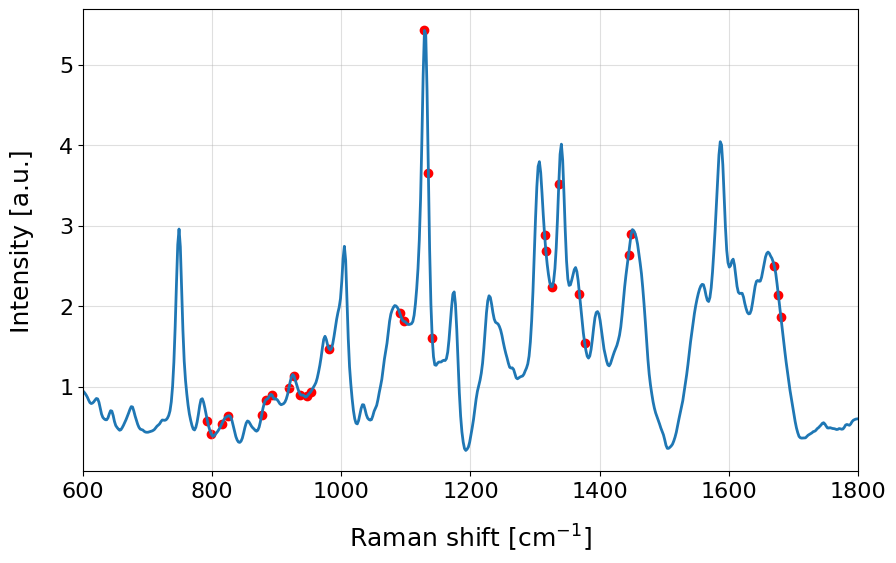

In [ ]:
columns_to_keep = [1134.75, 1132.75, 1314.75, 936.75, 938.75, 940.75, 1316.75, 884.75, 886.75, 1094.75, 1096.75, 818.75, 820.75, 1374.75, 1376.75, 948.75, 950.75, 952.75, 950.75, 1068.75, 796.75,  798.75,  794.75,1440.75, 1444.75, 974.75, 1674.75,1676.75, 1678.75]

columns_to_keep = [792.75, 798.75 , 814.75, 824.75, 876.75, 882.75, 892.75,918.75, 926.75, 936.75,946.75,952.75, 980.75,1090.75,1096.75, 1128.75, 1134.75, 1140.75, 1314.75,1336.75, 1316.75, 1326.75,1368.75, 1376.75, 1444.75, 1448.75,1670.75, 1676.75,1680.75]


filtered_data_reduced2 = filtered_data_reduced[columns_to_keep]

columns=  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']



fig, ax = plt.subplots(figsize=(10, 6))
alphaVal = 1
linethick=2

plt.plot(reduced_ramanshifts, filtered_data_reduced.mean(axis=0),lw=linethick, alpha=alphaVal)
plt.scatter(pd.DataFrame(columns_to_keep), filtered_data_reduced[columns_to_keep].mean(axis=0), color = 'red', s=25,lw=linethick, alpha=alphaVal)
plt.grid(alpha=0.4)
ax.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=18, labelpad=15)
ax.set_ylabel(r'Intensity [a.u.]', fontsize=18, labelpad=18)
plt.xticks(range(600, 2000, 200), fontsize=16)
plt.xlim([600, 1800])
plt.yticks(range(1, 6, 1), fontsize=16)
plt.savefig('fig19.svg', format='svg', dpi=300)
plt.show()


In [ ]:
filtered_data_reduced2 = filtered_data_reduced[columns_to_keep]


filtered_data_reduced2[columns_to_keep] = filtered_data_reduced[columns_to_keep]

NameError: name 'columns_to_keep' is not defined

### Figure 20

Figure 20: Confusion matrix for the unseen data obtained from training a 1-D CNN model with the 28 most significant features trained by grouping K2 and K54 serotypes into a single class, ‘K2-K54’ (a), and only with K2 and K54 serotypes (b). The overall accuracies achieved were 97% and 91%, respectively.

In [ ]:
filtered_data_reduced2

792.75    798.75    814.75    824.75    876.75    882.75    892.75  \
0     0.402304  0.357679  0.713839  0.322906  0.680273  0.284730  0.724813   
1     0.368861  0.428162  0.498903  0.788304  0.615378  0.624001  0.718848   
2     0.542316  0.366613  0.683174  0.689765  0.391882  0.679358  0.841821   
3     0.765880  0.803384  1.425288  1.350668  0.988424  1.287805  1.106705   
4     0.539132  0.394320  0.620804  0.899051  0.723007  0.543482  0.962921   
...        ...       ...       ...       ...       ...       ...       ...   
4221  0.315935  0.178670  0.229918  0.502728  0.555667  0.502771  0.756932   
4222  0.327637  0.335406  0.232538  0.267993  0.381350  0.719703  0.744982   
4223  0.738702  0.438594  0.402980  0.733371  0.772610  0.972893  1.271729   
4224  0.769912  0.182216  0.533777  0.627771  1.017361  0.781970  0.984730   
4225  0.123971  0.177232  0.317602  0.247547  0.630496  0.947646  0.769259   

        918.75    926.75    936.75  ...   1680.75                  filename  \
0     1.118885  1.587865  1.293421  ...  1.672400   130723_1_kp_K1_M-11.txt   
1     0.857262  1.079187  1.146011  ...  1.400602   130723_1_kp_K1_M-12.txt   
2     0.781993  0.782021  0.932156  ...  1.381811   130723_1_kp_K1_M-13.txt   
3     0.931790  1.135239  1.601709  ...  1.781801   130723_1_kp_K1_M-14.txt   
4     0.922210  1.129696  0.819145  ...  1.203215   130723_1_kp_K1_M-19.txt   
...        ...       ...       ...  ...       ...                       ...   
4221  0.793292  0.973189  0.835399  ...  1.934444  130723_26_kp_K2_M-95.txt   
4222  0.715922  0.928893  0.443511  ...  2.115925  130723_26_kp_K2_M-96.txt   
4223  0.532622  1.231806  0.739448  ...  2.652520  130723_26_kp_K2_M-97.txt   
4224  1.102573  1.542678  1.278929  ...  2.370659  130723_26_kp_K2_M-98.txt   
4225  1.316184  0.785147  1.042122  ...  2.334887  130723_26_kp_K2_M-99.txt   

      isolate      specie  mucoide  spectrum_number  intense  fenotype  \
0      Kp 428  Klebsiella        M               11        N        K1   
1      Kp 428  Klebsiella        M               12        N        K1   
2      Kp 428  Klebsiella        M               13        N        K1   
3      Kp 428  Klebsiella        M               14        N        K1   
4      Kp 428  Klebsiella        M               19        N        K1   
...       ...         ...      ...              ...      ...       ...   
4221    kp108  Klebsiella        M               95        N        K2   
4222    kp108  Klebsiella        M               96        N        K2   
4223    kp108  Klebsiella        M               97        N        K2   
4224    kp108  Klebsiella        M               98        N        K2   
4225    kp108  Klebsiella        M               99        N        K2   

      number    date  
0          1  130723  
1          1  130723  
2          1  130723  
3          1  130723  
4          1  130723  
...      ...     ...  
4221      26  130723  
4222      26  130723  
4223      26  130723  
4224      26  130723  
4225      26  130723  

[2881 rows x 38 columns]

In [ ]:
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_3classes_model.h5')
model_bin = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_2classes_model.h5')

5/5 [==============================] - 0s 5ms/step


<ipython-input-64-18dec4dd9c05>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_reduced2[columns] = filtered_data_reduced[columns]
<ipython-input-64-18dec4dd9c05>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_reduced2[columns] = filtered_data_reduced[columns]
<ipython-input-64-18dec4dd9c05>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

test accuracy: 0.966
10/10 [==============================] - 0s 3ms/step
Class 0 - Accuracy: 0.98, Recall: 1.00, Precision: 0.86,Specificity: 0.98, F1-Score: 0.93, AUC: 0.9988
Class 1 - Accuracy: 0.97, Recall: 0.95, Precision: 1.00,Specificity: 1.00, F1-Score: 0.97, AUC: 0.9989
Class 2 - Accuracy: 0.99, Recall: 1.00, Precision: 0.94,Specificity: 0.98, F1-Score: 0.97, AUC: 1.0000
4/4 [==============================] - 0s 5ms/step
test accuracy: 0.907
7/7 [==============================] - 0s 4ms/step
Class 0 - Accuracy: 0.91, Recall: 0.88, Precision: 0.94,Specificity: 0.94, F1-Score: 0.91, AUC: 0.9319
Class 1 - Accuracy: 0.91, Recall: 0.94, Precision: 0.88,Specificity: 0.88, F1-Score: 0.91, AUC: 0.9319


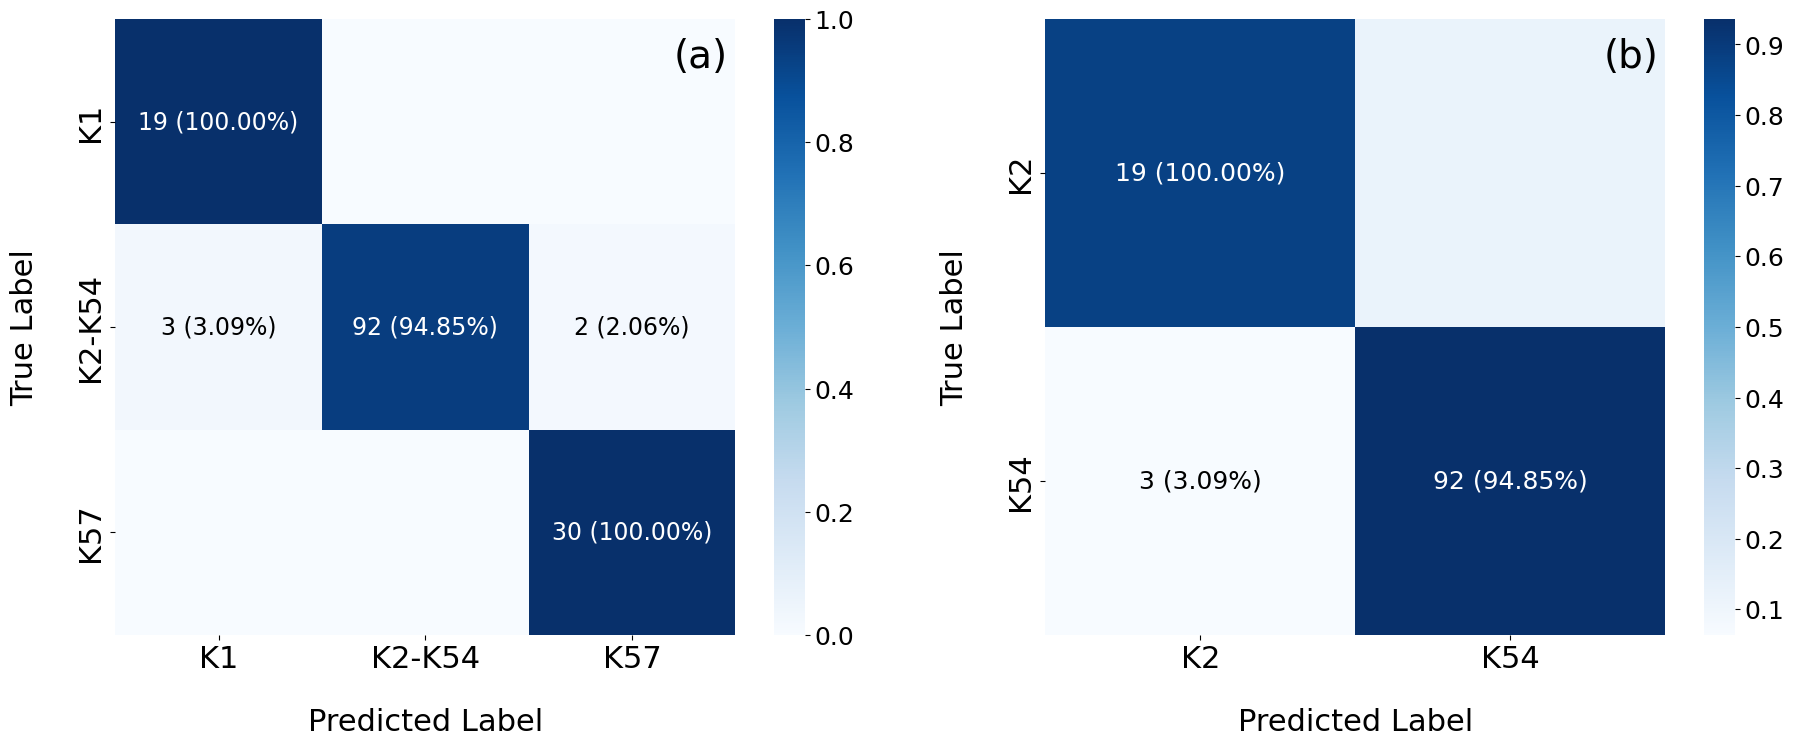

In [ ]:
#columns_to_keep = [1134.75, 1132.75, 1314.75, 936.75, 938.75, 940.75, 1316.75, 884.75, 886.75, 1094.75, 1096.75, 818.75, 820.75, 1374.75, 1376.75, 948.75, 950.75, 952.75, 950.75, 1068.75, 796.75,  798.75,  794.75,1440.75, 1444.75, 974.75, 1674.75,1676.75, 1678.75]

# Creating a subplot with 2 axes
fig20, (ax20a, ax20b) = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
ax20a.text(0.9, 0.97, '(a)', transform=ax20a.transAxes, fontsize=28, verticalalignment='top')
ax20b.text(0.9, 0.97, '(b)', transform=ax20b.transAxes, fontsize=28, verticalalignment='top')




filtered_data_reduced2 = filtered_data_reduced[columns_to_keep]

columns=  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']

filtered_data_reduced2[columns] = filtered_data_reduced[columns]


'''fig, ax = plt.subplots(figsize=(10, 6))
alphaVal = 1
linethick=1.5

plt.plot(reduced_ramanshifts, filtered_data_reduced.iloc[:,:-9].mean(axis=0),lw=linethick, alpha=alphaVal)
plt.scatter(pd.DataFrame(columns_to_keep), filtered_data_reduced[columns_to_keep].mean(axis=0), color = 'red', s=17,lw=linethick, alpha=alphaVal)
plt.grid(alpha=0.4)
ax.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=15, labelpad=13)
ax.set_ylabel(r'Intensity [a.u.]', fontsize=15, labelpad=13)
plt.xticks(range(600, 2000, 200), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([600, 1800])
plt.yticks(range(1, 6, 1), fontsize=12)
plt.yticks(fontsize=14)
plt.savefig('fig19.svg', format='svg', dpi=300)
plt.show()
'''


filtered_data = filtered_data_reduced2
ramanshifts = columns_to_keep


feature_steps_list = []
results = []


columns = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']

# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2-K54' if x == 'K2' else ('K2-K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2-K54', 'K54-K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# i separate spectra from specific isolates measued on different days as "unseens" (ensuring that an adequate n of spectra remain in the train/val dataset for that isolate)
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition


unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']



label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)


calcular = [
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = {'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    #plt.title(f"{calcular[i]['que']} Confusion Matrix")

    sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', ax=ax20a, xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                ax20a.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color, fontsize=17)

    ax20a.set_xlabel('Predicted Label', fontsize=20, labelpad=20)
    ax20a.set_ylabel('True Label', fontsize=20, labelpad=22)
    plt.xticks( fontsize=15)
    plt.yticks(fontsize=15)
    cbar = sns_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)





y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[0]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]

y_pred_int_np = np.argmax(y_pred, axis=1)
y_test_int_np = np.argmax(y_test, axis=1)


class_metrics = []

for i in range(num_classes_grouped):
    tp = cm[i, i]  # True Positive
    fn = cm[i, :].sum() - tp  # False Negative
    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
    fp = cm[:, i].sum() - tp  # False Positive

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

    # Create one-hot encoded y_true_class for the current class
    y_true_class = np.zeros((len(y_test_int_np),))
    y_true_class[y_test_int_np == i] = 1

    # Probability scores for the current class
    y_score_class = y_pred[:, i]

    # Calculate AUC
    auc = roc_auc_score(y_true_class, y_score_class)

    class_metrics.append({
        'Class': i,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'AUC': auc
    })

for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
          f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
          f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
          f"AUC: {metrics['AUC']:.4f}")


if 'K2-K54' in binary_data['fenotype_grouped'].values or 'K54-K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)



    calcular_bin = [
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'test': []}

    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        sns_heatmap = sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', ax= ax20b, xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm[i, j]
                if value != 0 and not np.isnan(cm_normalized[i, j]):
                    text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                    text_color = "white" if cm_normalized_bin[i, j] > 0.5 else "black"
                    ax20b.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color, fontsize=18)
        ax20b.set_xlabel('Predicted Label', fontsize=20, labelpad=20)
        ax20b.set_ylabel('True Label', fontsize=20, labelpad=22)
        plt.xticks( fontsize=15)
        plt.yticks(fontsize=15)
        cbar = sns_heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=18)


        class_accuracies_bin[calcular_bin[0]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

        y_pred_bin = model_bin.predict(X_test_bin)
        y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
        y_test_int_bin = tf.argmax(y_test_bin, axis=1)
        accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

        y_pred_train_bin = model_bin.predict(X_train_bin)
        y_pred_val_bin = model_bin.predict(X_val_bin)

        y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
        y_train_int_bin = tf.argmax(y_train_bin, axis=1)
        accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

        y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
        y_val_int_bin = tf.argmax(y_val_bin, axis=1)
        accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

        class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]


        y_pred_int_bin_np = np.argmax(y_pred_bin, axis=1)
        y_test_int_bin_np = np.argmax(y_test_bin, axis=1)

        cm = cm_bin
        class_metrics = []

        for i in range(all_classes_bin):
            tp = cm[i, i]  # True Positive
            fn = cm[i, :].sum() - tp  # False Negative
            tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
            fp = cm[:, i].sum() - tp  # False Positive

            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
            recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

            # Create one-hot encoded y_true_class for the current class
            y_true_class = np.zeros((len(y_test_int_bin_np),))
            y_true_class[y_test_int_bin_np == i] = 1

            # Probability scores for the current class
            y_score_class = y_pred_bin[:, i]

            auc = roc_auc_score(y_true_class, y_score_class)

            class_metrics.append({
                'Class': i,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'Specificity': specificity,
                'F1-Score': f1_score,
                'AUC': auc
            })

        for metrics in class_metrics:
            print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
                  f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
                  f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
                  f"AUC: {metrics['AUC']:.4f}")

for ax in [ax20a, ax20b]:
    ax.tick_params(axis='both', labelsize=22)
    ax.set_xlabel('Predicted Label', fontsize=22, labelpad=24)
    ax.set_ylabel('True Label', fontsize=22, labelpad=27)
fig20.savefig('fig20.svg', format='svg', dpi=300)
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_3classes_model.h5')
#model_bin.save('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_2classes_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_3classes_model.h5')
model_bin = load_model('/content/drive/MyDrive/klebsiellas/modelospaper/featureimportance_2classes_model.h5')

In [ ]:
filtered_data_reduced2

1134.75   1132.75   1314.75    936.75    938.75    940.75   1316.75  \
0     3.521638  4.616394  2.801491  1.293421  1.289489  1.142255  2.600468   
1     3.414590  4.532736  2.320873  1.146011  1.083403  1.067547  2.097901   
2     3.216956  3.828657  2.888676  0.932156  0.880295  0.727159  2.605518   
3     3.669166  4.825440  2.746289  1.601709  1.379113  1.092756  2.673262   
4     3.846433  5.077843  2.357470  0.819145  0.838042  0.928765  2.221872   
...        ...       ...       ...       ...       ...       ...       ...   
4221  4.047748  5.369647  3.089028  0.835399  0.784139  0.655018  2.832267   
4222  3.724351  4.770360  2.904528  0.443511  0.341554  0.449401  2.768899   
4223  3.662638  4.545855  3.285095  0.739448  1.022239  1.028449  2.971180   
4224  3.282418  4.239522  3.200737  1.278929  1.105598  0.928156  3.027972   
4225  3.179629  4.103294  3.235620  1.042122  0.918662  0.826913  2.824779   

        884.75    886.75   1094.75  ...                  filename  isolate  \
0     0.508065  0.930301  1.636170  ...   130723_1_kp_K1_M-11.txt   Kp 428   
1     0.632465  0.723999  1.566203  ...   130723_1_kp_K1_M-12.txt   Kp 428   
2     0.696621  0.777503  1.392592  ...   130723_1_kp_K1_M-13.txt   Kp 428   
3     1.158723  0.910891  1.930166  ...   130723_1_kp_K1_M-14.txt   Kp 428   
4     0.611548  0.642609  1.440725  ...   130723_1_kp_K1_M-19.txt   Kp 428   
...        ...       ...       ...  ...                       ...      ...   
4221  0.644541  0.722428  2.072517  ...  130723_26_kp_K2_M-95.txt    kp108   
4222  0.572151  0.540004  2.143393  ...  130723_26_kp_K2_M-96.txt    kp108   
4223  0.965918  0.959826  2.081806  ...  130723_26_kp_K2_M-97.txt    kp108   
4224  0.628741  0.699831  1.900776  ...  130723_26_kp_K2_M-98.txt    kp108   
4225  1.000415  0.856909  1.961490  ...  130723_26_kp_K2_M-99.txt    kp108   

          specie  mucoide  spectrum_number  intense  fenotype  number    date  \
0     Klebsiella        M               11        N        K1       1  130723   
1     Klebsiella        M               12        N        K1       1  130723   
2     Klebsiella        M               13        N        K1       1  130723   
3     Klebsiella        M               14        N        K1       1  130723   
4     Klebsiella        M               19        N        K1       1  130723   
...          ...      ...              ...      ...       ...     ...     ...   
4221  Klebsiella        M               95        N        K2      26  130723   
4222  Klebsiella        M               96        N        K2      26  130723   
4223  Klebsiella        M               97        N        K2      26  130723   
4224  Klebsiella        M               98        N        K2      26  130723   
4225  Klebsiella        M               99        N        K2      26  130723   

      fenotype_grouped  
0                   K1  
1                   K1  
2                   K1  
3                   K1  
4                   K1  
...                ...  
4221            K2-K54  
4222            K2-K54  
4223            K2-K54  
4224            K2-K54  
4225            K2-K54  

[2881 rows x 39 columns]

y-randomization

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 29, 64)            576       
                                                                 
 activation_21 (Activation)  (None, 29, 64)            0         
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 14, 64)            0         


<ipython-input-86-d8d045d6d65b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2-K54' if x == 'K2' else ('K2-K54' if x == 'K54' else x))


 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 14, 64)            0         
                                                                 
 flatten_7 (Flatten)         (None, 896)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               114816    
                                                                 
 activation_22 (Activation)  (None, 128)               0         
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 3)                 387       
                                                                 
 activation_23 (Activation)  (None, 3)                 0         
          

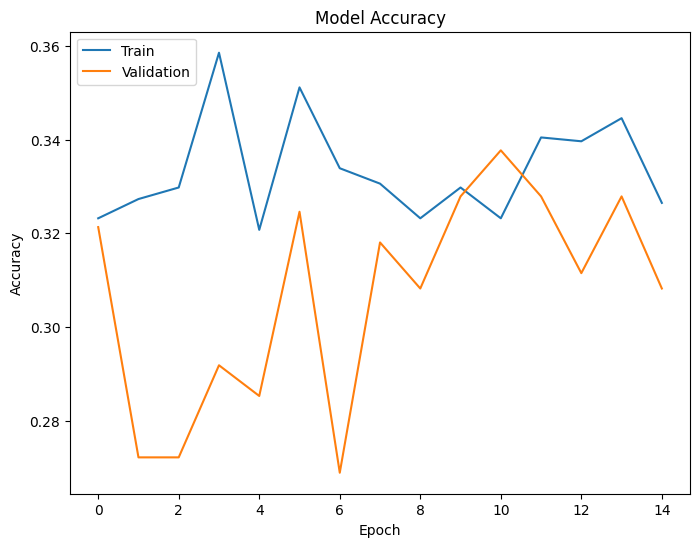

38/38 [==============================] - 1s 7ms/step
train accuracy: 0.363


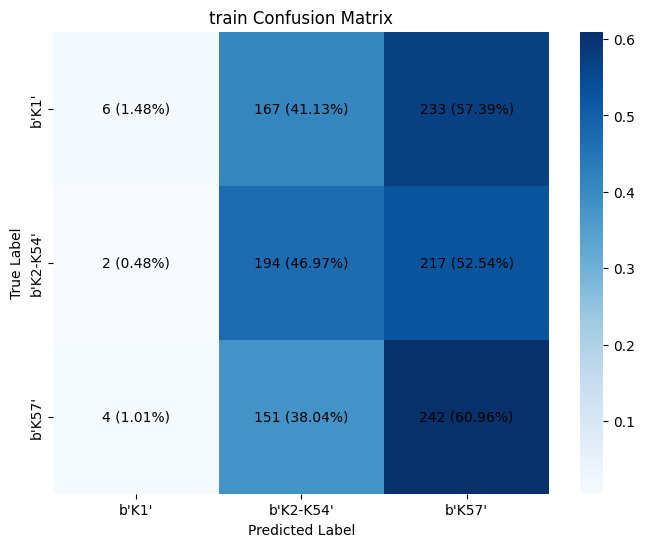

10/10 [==============================] - 0s 4ms/step
val accuracy: 0.308


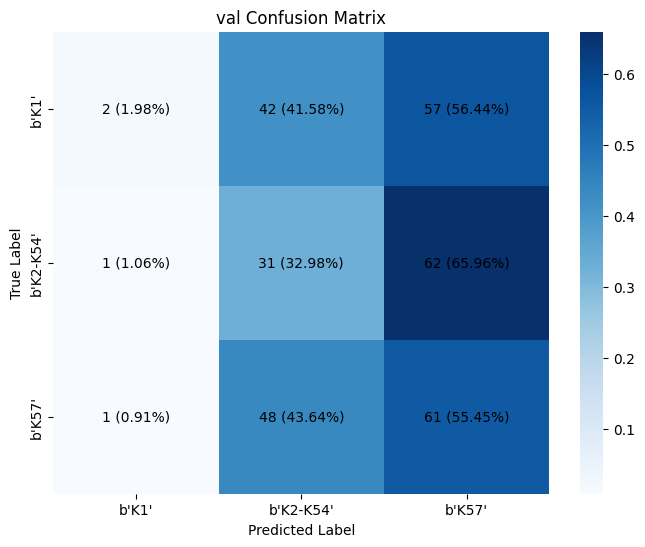

5/5 [==============================] - 0s 5ms/step
test accuracy: 0.384


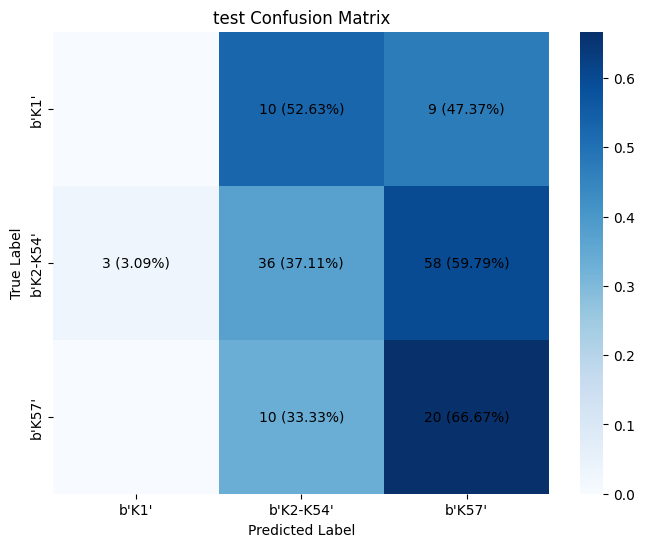

10/10 [==============================] - 0s 4ms/step
Epoch 1/15
28/28 - 3s - loss: 0.7328 - accuracy: 0.5067 - val_loss: 0.6983 - val_accuracy: 0.5223 - 3s/epoch - 103ms/step
Epoch 2/15
28/28 - 0s - loss: 0.7121 - accuracy: 0.5279 - val_loss: 0.6928 - val_accuracy: 0.5045 - 289ms/epoch - 10ms/step
Epoch 3/15
28/28 - 0s - loss: 0.7269 - accuracy: 0.4821 - val_loss: 0.7004 - val_accuracy: 0.5089 - 326ms/epoch - 12ms/step
Epoch 4/15
28/28 - 0s - loss: 0.7312 - accuracy: 0.4754 - val_loss: 0.6923 - val_accuracy: 0.5268 - 354ms/epoch - 13ms/step
Epoch 5/15
28/28 - 0s - loss: 0.7380 - accuracy: 0.4721 - val_loss: 0.6946 - val_accuracy: 0.5268 - 350ms/epoch - 12ms/step
Epoch 6/15
28/28 - 0s - loss: 0.7133 - accuracy: 0.5156 - val_loss: 0.6942 - val_accuracy: 0.5134 - 295ms/epoch - 11ms/step
Epoch 7/15
28/28 - 0s - loss: 0.7034 - accuracy: 0.5067 - val_loss: 0.6929 - val_accuracy: 0.5223 - 312ms/epoch - 11ms/step
Epoch 8/15
28/28 - 0s - loss: 0.7149 - accuracy: 0.4989 - val_loss: 0.6921 - val_

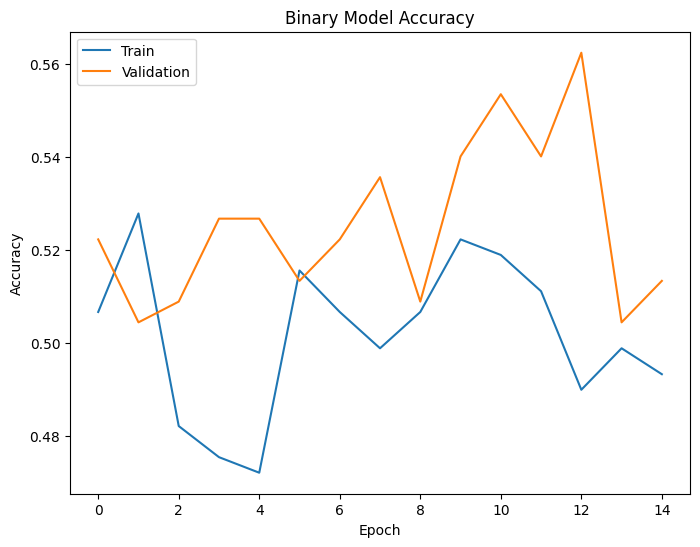

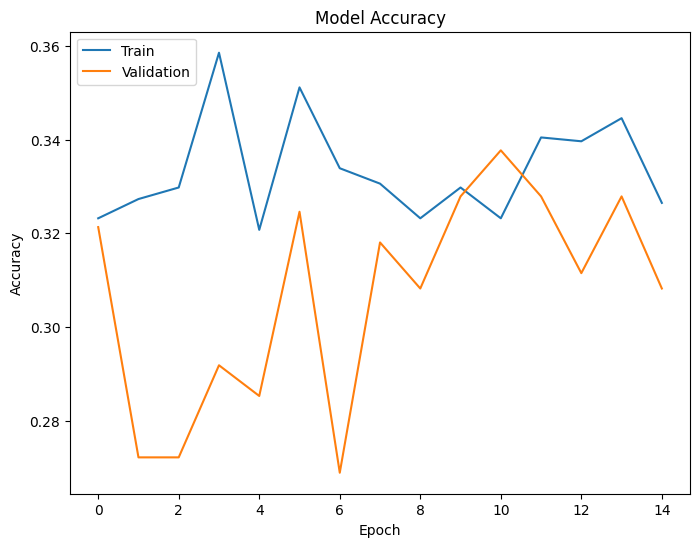

28/28 [==============================] - 0s 4ms/step
train accuracy: 0.504


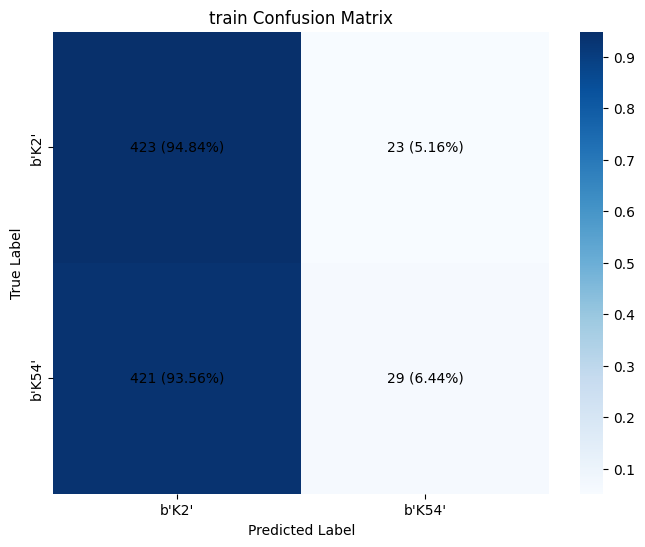

7/7 [==============================] - 0s 5ms/step
val accuracy: 0.513


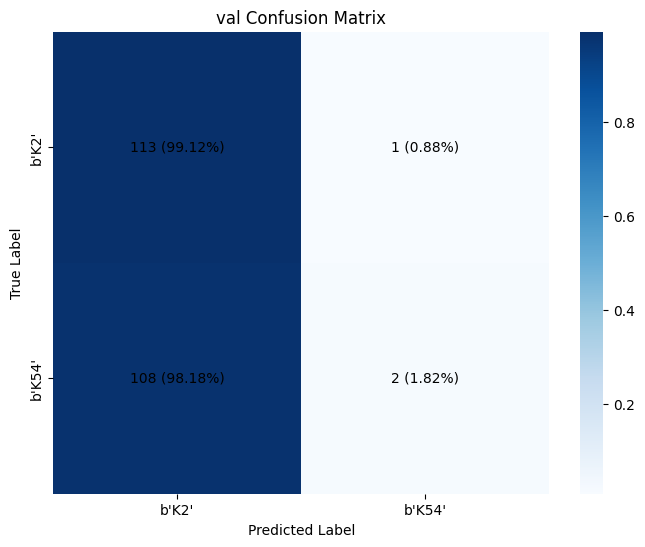

4/4 [==============================] - 0s 10ms/step
test accuracy: 0.536


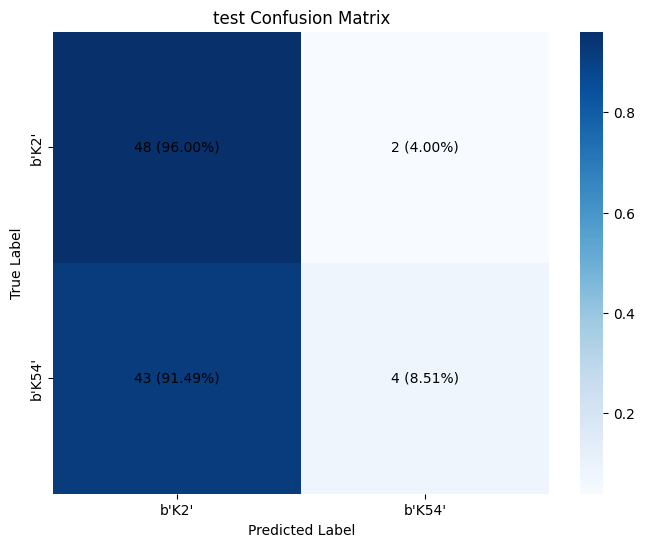

7/7 [==============================] - 0s 5ms/step


In [ ]:
filtered_data = filtered_data_reduced2
ramanshifts = columns_to_keep


feature_steps_list = []
results = []


columns = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']

# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2-K54' if x == 'K2' else ('K2-K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2-K54', 'K54-K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# i separate spectra from specific isolates measued on different days as "unseens" (ensuring that an adequate n of spectra remain in the train/val dataset for that isolate)
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition


unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']



label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()




y_perm_train=tf.random.shuffle(y_train,seed=1000)
y_perm_val=tf.random.shuffle(y_val,seed=1000)
y_perm_test=tf.random.shuffle(y_test,seed=1000)


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_perm_train)
y_perm_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_perm_test)
y_perm_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_perm_val)
y_perm_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train.to_numpy(), y_perm_train, batch_size=32, epochs=15, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_perm_train},
            {'que': 'val', 'X': X_val, 'y': y_perm_val},
            {'que': 'test', 'X': X_test, 'y': y_perm_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_perm_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_perm_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_perm_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]




if 'K2-K54' in binary_data['fenotype_grouped'].values or 'K54-K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    y_train_bin=tf.random.shuffle(y_train_bin,seed=1000)
    y_val_bin=tf.random.shuffle(y_val_bin,seed=1000)
    y_test_bin=tf.random.shuffle(y_test_bin,seed=1000)


    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)

    binary_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model_bin = tf.keras.models.Sequential(model.layers[:-1])  # Remove the last layer with 3 units
    model_bin.add(tf.keras.layers.Dense(2, activation='softmax'))  # Add new last layer with 2 units
    model_bin.compile(loss='categorical_crossentropy', optimizer=binary_optimizer, metrics=['accuracy'])

    binary_history = model_bin.fit(X_train_bin.to_numpy(), y_train_bin, batch_size=32, epochs=15, verbose=2, validation_data=(X_val_bin.to_numpy(), y_val_bin))

    plt.figure(figsize=(8, 6))
    plt.plot(binary_history.history['accuracy'])
    plt.plot(binary_history.history['val_accuracy'])
    plt.title('Binary Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    calcular_bin = [{'que': 'train', 'X': X_train_bin, 'y': y_train_bin},
                    {'que': 'val', 'X': X_val_bin, 'y': y_val_bin},
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'train': [], 'val': [], 'test': []}

    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        plt.figure(figsize=(8, 6))
        plt.title(f"{calcular_bin[i]['que']} Confusion Matrix")
        sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm_bin[i, j]
                if value != 0 and not np.isnan(cm_normalized_bin[i, j]):
                    text = f"{value} ({cm_normalized_bin[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    class_accuracies_bin[calcular_bin[2]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

    y_pred_bin = model_bin.predict(X_test_bin)
    y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
    y_test_int_bin = tf.argmax(y_test_bin, axis=1)
    accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

    y_pred_train_bin = model_bin.predict(X_train_bin)
    y_pred_val_bin = model_bin.predict(X_val_bin)

    y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
    y_train_int_bin = tf.argmax(y_train_bin, axis=1)
    accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

    y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
    y_val_int_bin = tf.argmax(y_val_bin, axis=1)
    accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

    class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]



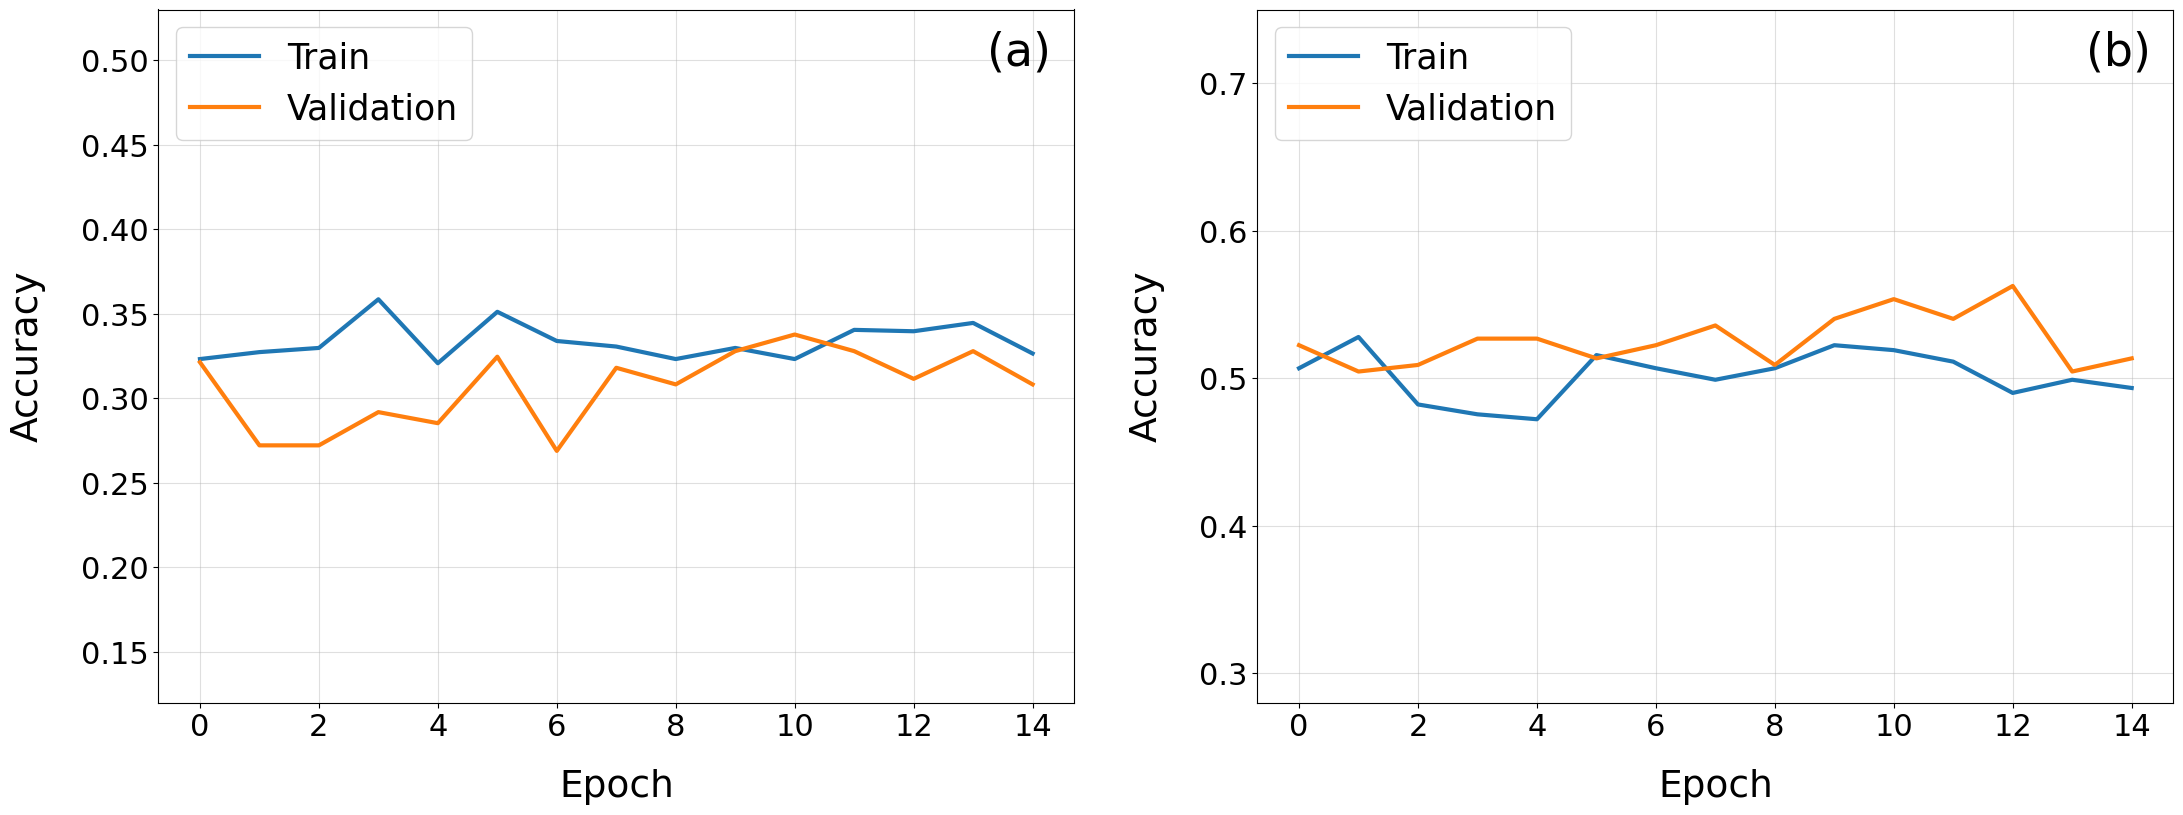

In [ ]:
fig21, (ax21a,ax21b) = plt.subplots(nrows=1, ncols=2, figsize=(26, 9))

alphaVal = 1
linethick = 3

# Plotting in ax14a
ax21a.set_ylim([0.12, 0.53])
ax21a.plot(history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax21a.plot(history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
ax21a.grid(alpha=0.4)
ax21a.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax21a.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax21a.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})
ax21a.tick_params(axis='both', which='major', labelsize=22)
ax21a.text(0.905, 0.97, '(a)', transform=ax21a.transAxes, fontsize=33, verticalalignment='top')

# Plotting in ax14b
ax21b.set_ylim([0.28, 0.75])
ax21b.plot(binary_history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax21b.plot(binary_history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
ax21b.grid(alpha=0.4)
ax21b.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax21b.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax21b.legend(['Train', 'Validation'], loc='upper left', prop={'size': 25})
ax21b.tick_params(axis='both', which='major', labelsize=22)
ax21b.text(0.905, 0.97, '(b)', transform=ax21b.transAxes, fontsize=33, verticalalignment='top')

# Save the combined figure
fig21.savefig('fig21.svg', format='svg', dpi=300)
plt.show()






### Figure 21

Figure 21: Y-randomization model training process for a 1-D CNN trained with 28 features, grouping K2 and K54 serotypes into a single class (a) and training only with K2 and K54 serotypes (b).

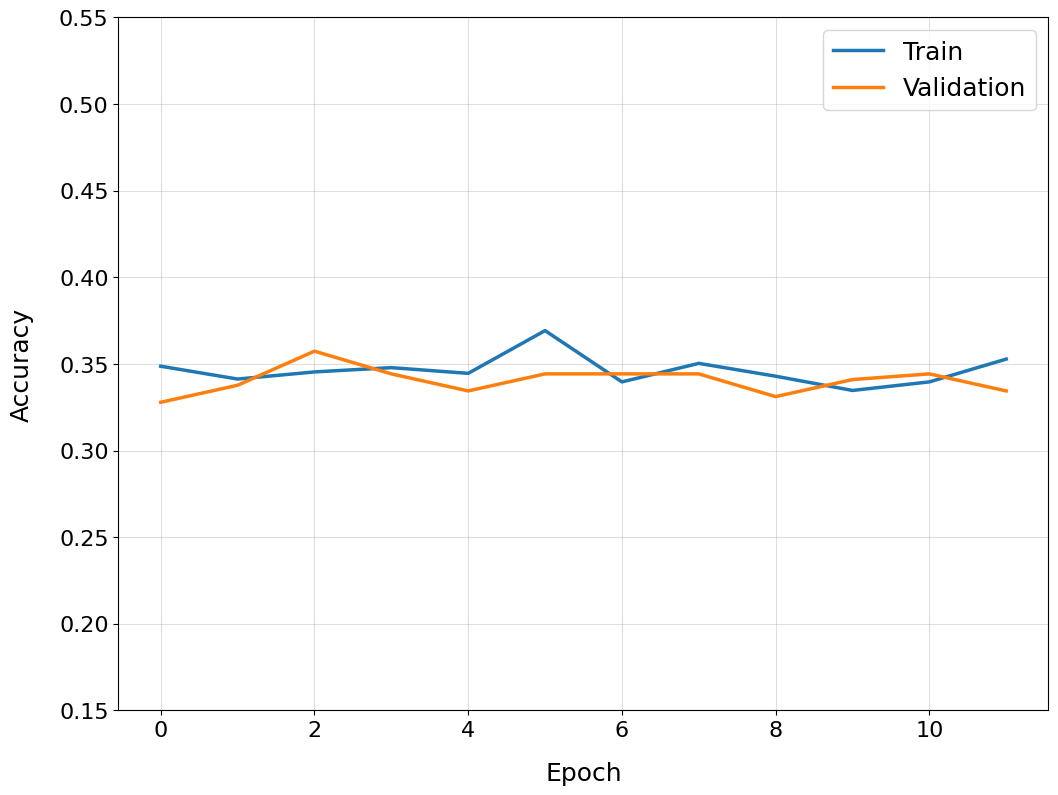

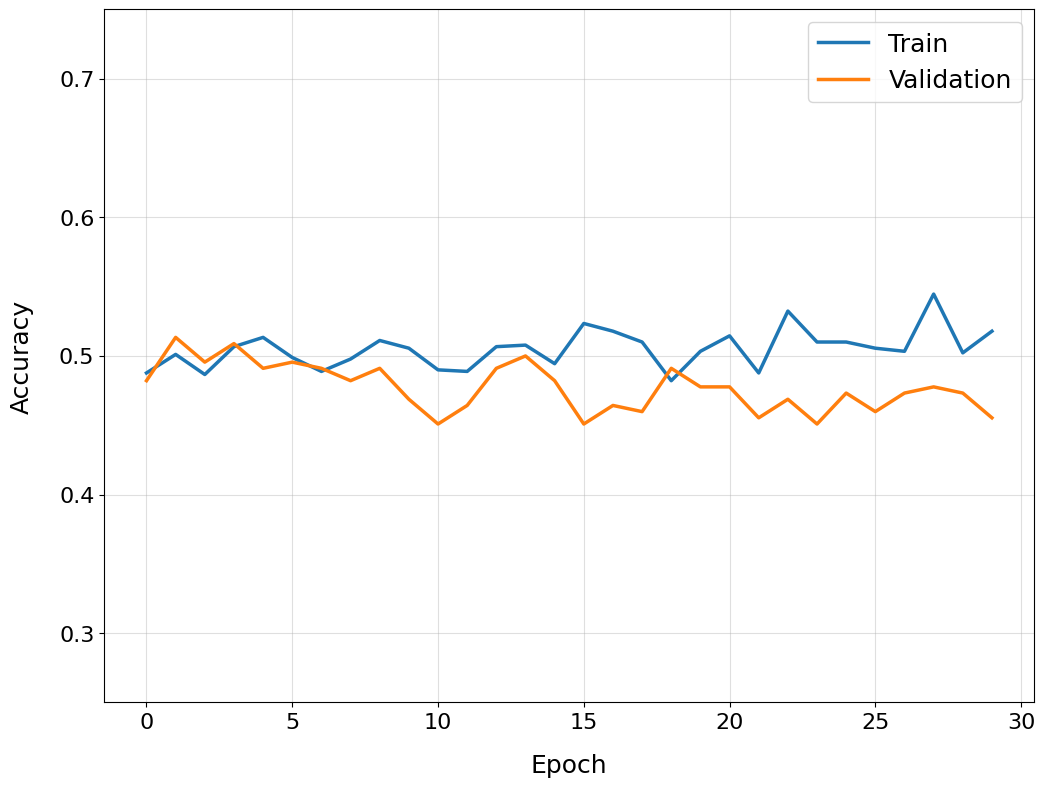

In [ ]:
alphaVal = 1
linethick=2.5

fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax.plot(history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
#ax.set_title('Model Accuracy')
plt.grid(alpha=0.4)
ax.set_ylabel('Accuracy', fontsize=27, labelpad=18)
ax.set_xlabel('Epoch', fontsize=27, labelpad=15)
ax.set_ylim([0.15, 0.55])
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 18})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('fig21a.svg', format='svg', dpi=300)
plt.show()


fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(binary_history.history['accuracy'], lw=linethick, alpha=alphaVal)
ax.plot(binary_history.history['val_accuracy'], lw=linethick, alpha=alphaVal)
#ax.set_title('Model Accuracy')
plt.grid(alpha=0.4)
ax.set_ylabel('Accuracy', fontsize=27, labelpad=25)
ax.set_xlabel('Epoch', fontsize=27, labelpad=20)
ax.set_ylim([0.25, 0.75])
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 18})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('fig21b.svg', format='svg', dpi=300)
plt.show()



## juntos

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 29, 64)            576       
                                                                 
 activation_72 (Activation)  (None, 29, 64)            0         
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 14, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 896)               0         
                                                                 
 dense_59 (Dense)            (None, 128)               114816    
                                                                 
 activation_73 (Activation)  (None, 128)               0         
                                                     

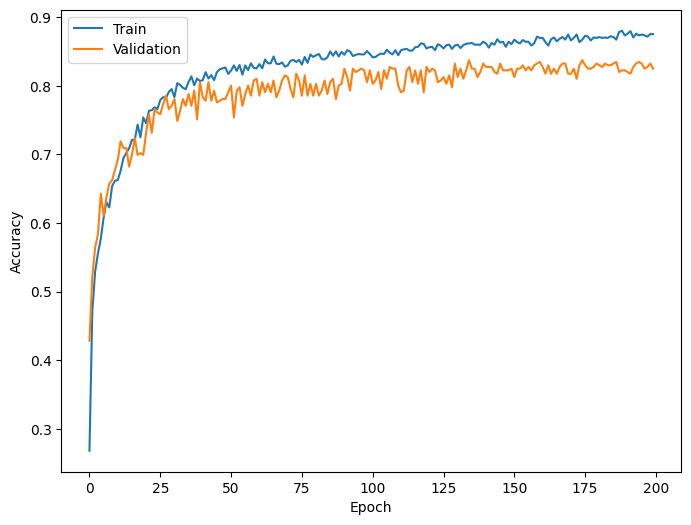

51/51 [==============================] - 1s 11ms/step
train accuracy: 0.878


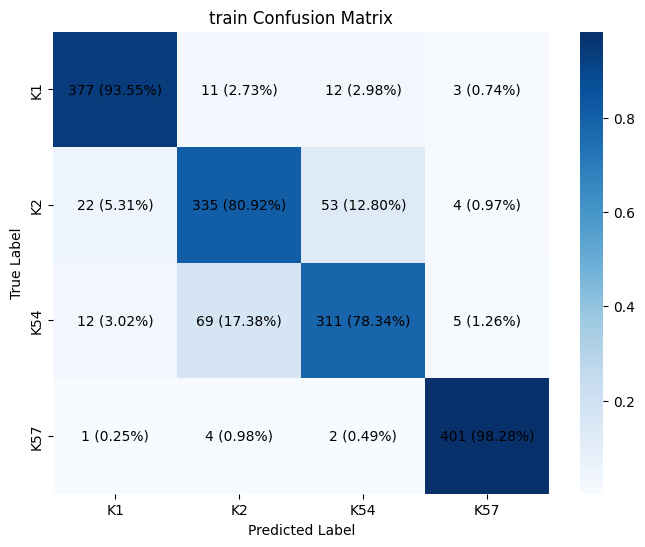

13/13 [==============================] - 0s 11ms/step
val accuracy: 0.825


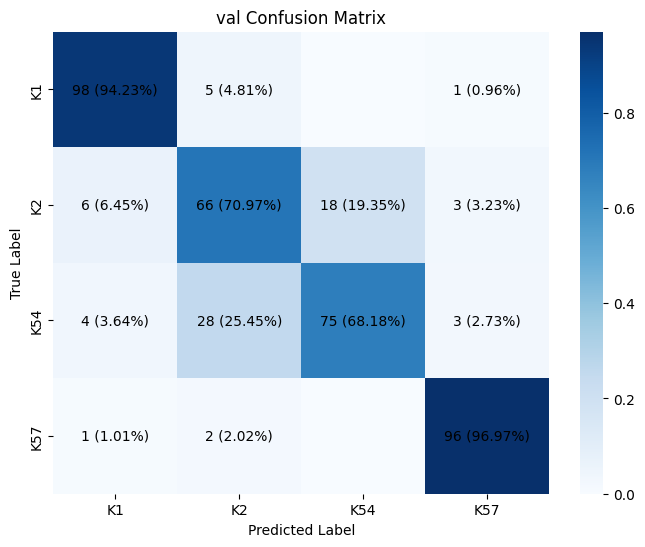

5/5 [==============================] - 0s 8ms/step
test accuracy: 0.908


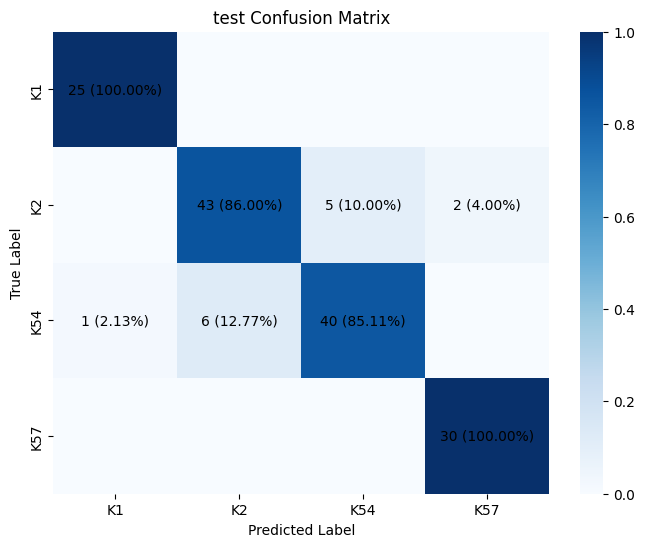

13/13 [==============================] - 0s 8ms/step


In [ ]:
label = 'fenotype'

columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']

filtered_data = filtered_data_reduced2
ramanshifts = columns_to_keep


conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
(filtered_data['isolate'] == 'KpC3') & (filtered_data['date'] == 310523),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723)
]


final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition

unseens = filtered_data[final_condition]
filtered_data2 = filtered_data[~final_condition]


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
#model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)
history = model.fit(X_train.to_numpy(), y_train, batch_size=32, epochs=200, verbose=2, validation_data=(X_val.to_numpy(), y_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_train},
            {'que': 'val', 'X': X_val, 'y': y_val},
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()




y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]



## 28 random features

In [ ]:
import random

inicio_rango = 600.75
fin_rango = 800.75
cantidad_valores = 28
random_values = [round(random.uniform(inicio_rango, fin_rango) // 2 * 2 + 0.75, 2) for _ in range(cantidad_valores)]
print(random_values)


[762.75, 684.75, 788.75, 640.75, 726.75, 766.75, 670.75, 762.75, 788.75, 786.75, 712.75, 666.75, 778.75, 756.75, 758.75, 736.75, 624.75, 734.75, 728.75, 600.75, 718.75, 720.75, 778.75, 642.75, 690.75, 616.75, 654.75, 708.75]


In [ ]:
filtered_data_reduced2 = filtered_data_reduced[random_values]

filtered_data_reduced2[columns_to_drop] = filtered_data_reduced[columns_to_drop]

<ipython-input-201-5a3726ee6ab8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_reduced2[columns] = filtered_data_reduced[columns]
<ipython-input-201-5a3726ee6ab8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_reduced2[columns] = filtered_data_reduced[columns]
<ipython-input-201-5a3726ee6ab8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 28, 64)            576       
                                                                 
 activation_90 (Activation)  (None, 28, 64)            0         
                                                                 
 max_pooling1d_30 (MaxPooli  (None, 14, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_60 (Dropout)        (None, 14, 64)            0         
                                                                 
 flatten_30 (Flatten)        (None, 896)               0         
                                                                 
 dense_78 (Dense)            (None, 128)               114816    
                                                     

<ipython-input-202-6dd5e89aa461>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2_K54' if x == 'K2' else ('K2_K54' if x == 'K54' else x))


Epoch 1/50
38/38 - 1s - loss: 1.0927 - accuracy: 0.3561 - val_loss: 1.0823 - val_accuracy: 0.3836 - 1s/epoch - 30ms/step
Epoch 2/50
38/38 - 0s - loss: 1.0771 - accuracy: 0.3947 - val_loss: 1.0663 - val_accuracy: 0.4918 - 204ms/epoch - 5ms/step
Epoch 3/50
38/38 - 0s - loss: 1.0587 - accuracy: 0.4630 - val_loss: 1.0502 - val_accuracy: 0.5311 - 197ms/epoch - 5ms/step
Epoch 4/50
38/38 - 0s - loss: 1.0495 - accuracy: 0.4942 - val_loss: 1.0333 - val_accuracy: 0.5705 - 208ms/epoch - 5ms/step
Epoch 5/50
38/38 - 0s - loss: 1.0330 - accuracy: 0.5230 - val_loss: 1.0152 - val_accuracy: 0.6033 - 195ms/epoch - 5ms/step
Epoch 6/50
38/38 - 0s - loss: 1.0167 - accuracy: 0.5469 - val_loss: 0.9951 - val_accuracy: 0.6098 - 192ms/epoch - 5ms/step
Epoch 7/50
38/38 - 0s - loss: 1.0056 - accuracy: 0.5485 - val_loss: 0.9752 - val_accuracy: 0.6164 - 334ms/epoch - 9ms/step
Epoch 8/50
38/38 - 0s - loss: 0.9806 - accuracy: 0.6077 - val_loss: 0.9551 - val_accuracy: 0.6164 - 395ms/epoch - 10ms/step
Epoch 9/50
38/38 

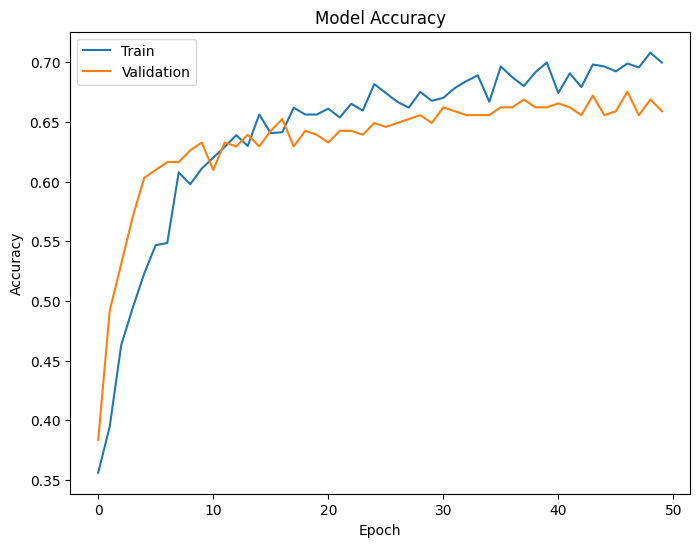

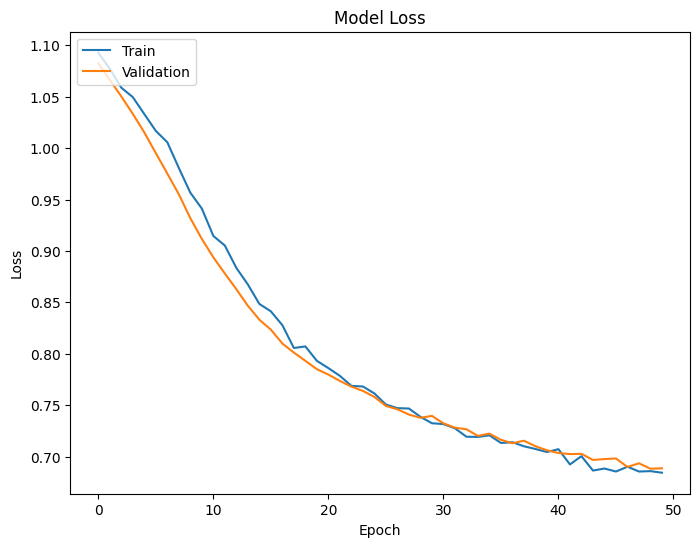

38/38 [==============================] - 0s 2ms/step
train accuracy: 0.718


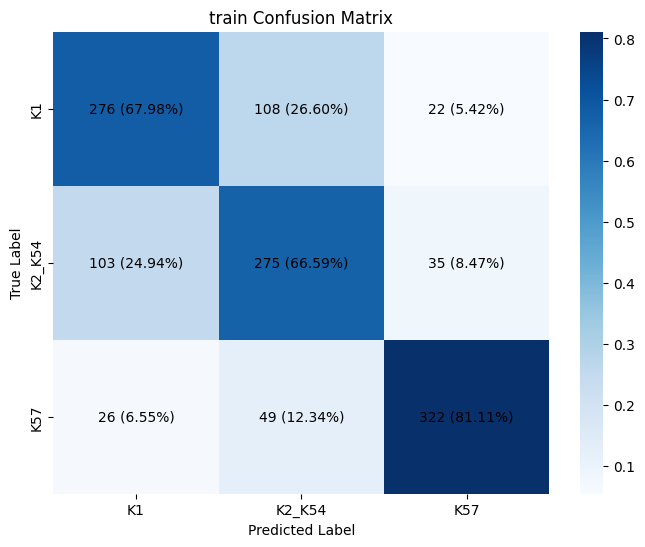

10/10 [==============================] - 0s 2ms/step
val accuracy: 0.659


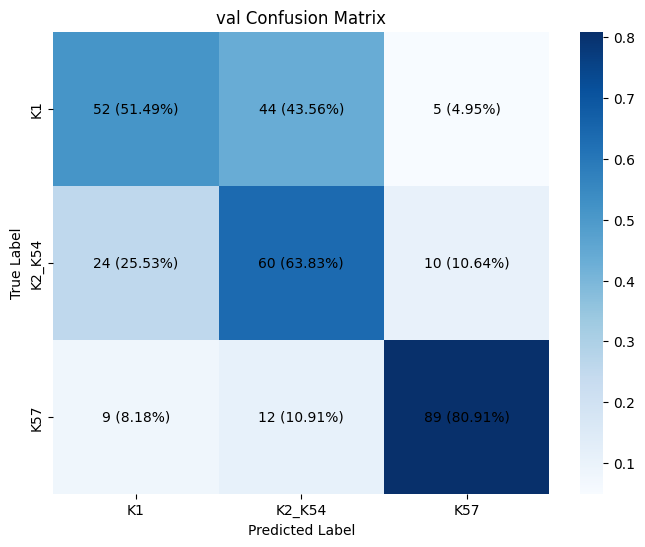

5/5 [==============================] - 0s 3ms/step
test accuracy: 0.541


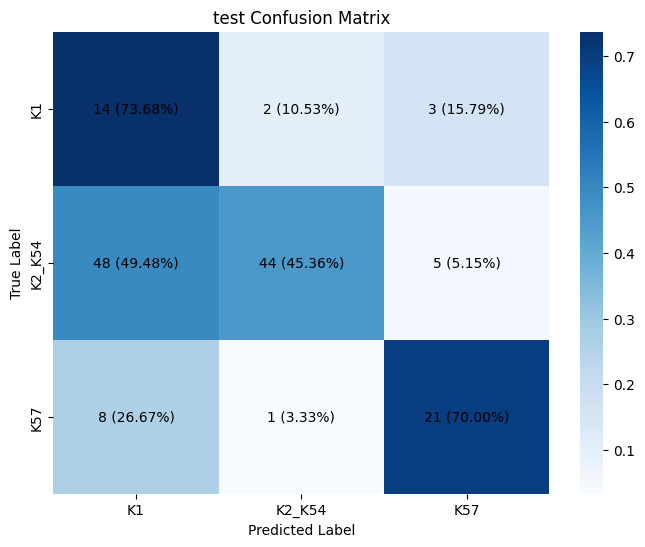

10/10 [==============================] - 0s 2ms/step
Class 0 - Accuracy: 0.58, Recall: 0.74, Precision: 0.20,Specificity: 0.56, F1-Score: 0.31, AUC: 0.6432
Class 1 - Accuracy: 0.62, Recall: 0.45, Precision: 0.94,Specificity: 0.94, F1-Score: 0.61, AUC: 0.8698
Class 2 - Accuracy: 0.88, Recall: 0.70, Precision: 0.72,Specificity: 0.93, F1-Score: 0.71, AUC: 0.9397
Epoch 1/50
28/28 - 1s - loss: 0.7468 - accuracy: 0.5279 - val_loss: 0.7000 - val_accuracy: 0.5893 - 1s/epoch - 43ms/step
Epoch 2/50
28/28 - 0s - loss: 0.7293 - accuracy: 0.5324 - val_loss: 0.6896 - val_accuracy: 0.5714 - 176ms/epoch - 6ms/step
Epoch 3/50
28/28 - 0s - loss: 0.7345 - accuracy: 0.5179 - val_loss: 0.6852 - val_accuracy: 0.5848 - 154ms/epoch - 6ms/step
Epoch 4/50
28/28 - 0s - loss: 0.7068 - accuracy: 0.5424 - val_loss: 0.6814 - val_accuracy: 0.6027 - 160ms/epoch - 6ms/step
Epoch 5/50
28/28 - 0s - loss: 0.7023 - accuracy: 0.5547 - val_loss: 0.6759 - val_accuracy: 0.5804 - 155ms/epoch - 6ms/step
Epoch 6/50
28/28 - 0s - l

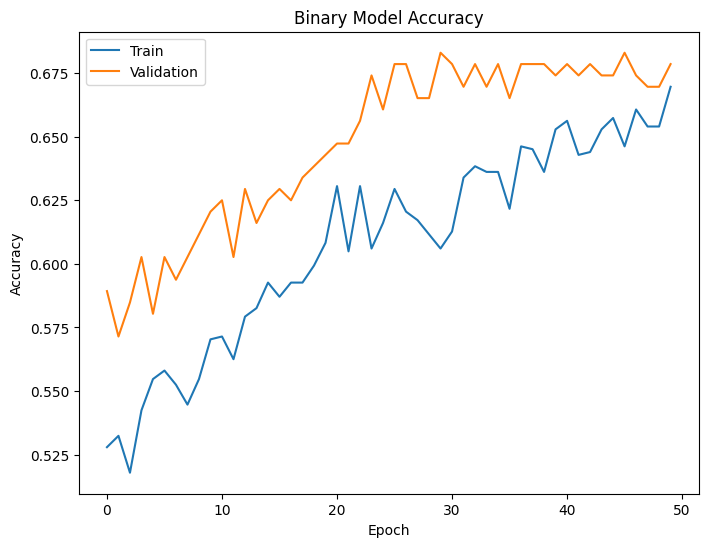

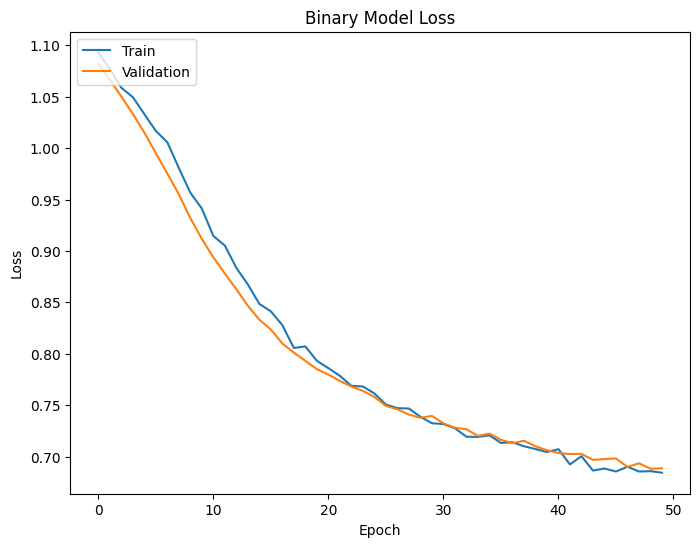

28/28 [==============================] - 0s 3ms/step
train accuracy: 0.662


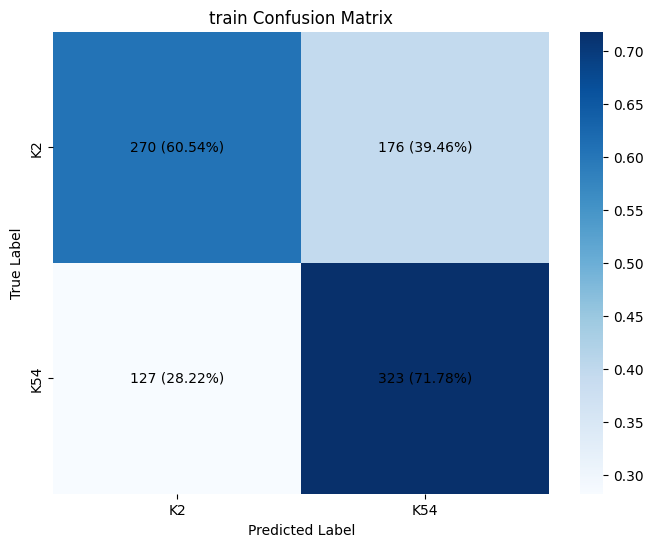

7/7 [==============================] - 0s 3ms/step
Class 0 - Accuracy: 0.66, Recall: 0.61, Precision: 0.68,Specificity: 0.72, F1-Score: 0.64, AUC: 0.7094
Class 1 - Accuracy: 0.66, Recall: 0.72, Precision: 0.65,Specificity: 0.61, F1-Score: 0.68, AUC: 0.7094
7/7 [==============================] - 0s 4ms/step
val accuracy: 0.679


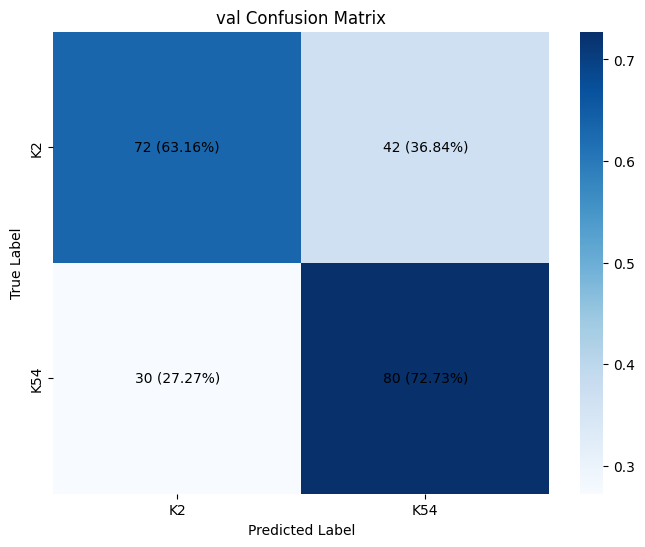

7/7 [==============================] - 0s 4ms/step
Class 0 - Accuracy: 0.68, Recall: 0.63, Precision: 0.71,Specificity: 0.73, F1-Score: 0.67, AUC: 0.7094
Class 1 - Accuracy: 0.68, Recall: 0.73, Precision: 0.66,Specificity: 0.63, F1-Score: 0.69, AUC: 0.7094
4/4 [==============================] - 0s 6ms/step
test accuracy: 0.608


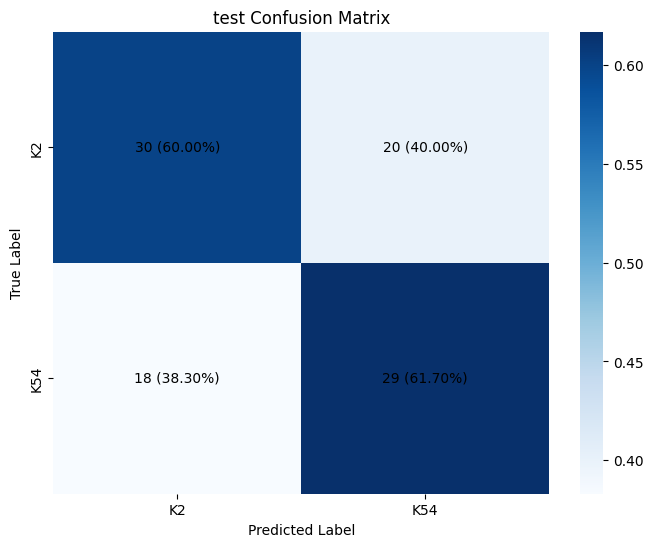

7/7 [==============================] - 0s 3ms/step
Class 0 - Accuracy: 0.61, Recall: 0.60, Precision: 0.62,Specificity: 0.62, F1-Score: 0.61, AUC: 0.7094
Class 1 - Accuracy: 0.61, Recall: 0.62, Precision: 0.59,Specificity: 0.60, F1-Score: 0.60, AUC: 0.7094


In [ ]:
filtered_data = filtered_data_reduced2
ramanshifts = random_values


feature_steps_list = []

# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2_K54' if x == 'K2' else ('K2_K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2_K54', 'K54_K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# i separate spectra from specific isolates measued on different days as "unseens" (ensuring that an adequate n of spectra remain in the train/val dataset for that isolate)
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition


unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']



label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train.to_numpy(), y_train, batch_size=32, epochs=50, verbose=2, validation_data=(X_val.to_numpy(), y_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_train},
            {'que': 'val', 'X': X_val, 'y': y_val},
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]

y_pred_int_np = np.argmax(y_pred, axis=1)
y_test_int_np = np.argmax(y_test, axis=1)


class_metrics = []

for i in range(num_classes_grouped):
    tp = cm[i, i]  # True Positive
    fn = cm[i, :].sum() - tp  # False Negative
    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
    fp = cm[:, i].sum() - tp  # False Positive

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

    # Create one-hot encoded y_true_class for the current class
    y_true_class = np.zeros((len(y_test_int_np),))
    y_true_class[y_test_int_np == i] = 1

    # Probability scores for the current class
    y_score_class = y_pred[:, i]

    # Calculate AUC
    auc = roc_auc_score(y_true_class, y_score_class)

    class_metrics.append({
        'Class': i,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'AUC': auc
    })

for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
          f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
          f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
          f"AUC: {metrics['AUC']:.4f}")


if 'K2_K54' in binary_data['fenotype_grouped'].values or 'K54_K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)

    binary_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model_bin = tf.keras.models.Sequential(model.layers[:-1])  # Remove the last layer with 3 units
    model_bin.add(tf.keras.layers.Dense(2, activation='softmax'))  # Add new last layer with 2 units
    model_bin.compile(loss='categorical_crossentropy', optimizer=binary_optimizer, metrics=['accuracy'])

    binary_history = model_bin.fit(X_train_bin.to_numpy(), y_train_bin, batch_size=32, epochs=50, verbose=2, validation_data=(X_val_bin.to_numpy(), y_val_bin))

    plt.figure(figsize=(8, 6))
    plt.plot(binary_history.history['accuracy'])
    plt.plot(binary_history.history['val_accuracy'])
    plt.title('Binary Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Binary Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    calcular_bin = [{'que': 'train', 'X': X_train_bin, 'y': y_train_bin},
                    {'que': 'val', 'X': X_val_bin, 'y': y_val_bin},
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'train': [], 'val': [], 'test': []}

    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        plt.figure(figsize=(8, 6))
        plt.title(f"{calcular_bin[i]['que']} Confusion Matrix")
        sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm_bin[i, j]
                if value != 0 and not np.isnan(cm_normalized_bin[i, j]):
                    text = f"{value} ({cm_normalized_bin[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        class_accuracies_bin[calcular_bin[2]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

        y_pred_bin = model_bin.predict(X_test_bin)
        y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
        y_test_int_bin = tf.argmax(y_test_bin, axis=1)
        accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

        y_pred_train_bin = model_bin.predict(X_train_bin)
        y_pred_val_bin = model_bin.predict(X_val_bin)

        y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
        y_train_int_bin = tf.argmax(y_train_bin, axis=1)
        accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

        y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
        y_val_int_bin = tf.argmax(y_val_bin, axis=1)
        accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

        class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]


        y_pred_int_bin_np = np.argmax(y_pred_bin, axis=1)
        y_test_int_bin_np = np.argmax(y_test_bin, axis=1)

        cm = cm_bin
        class_metrics = []

        for i in range(all_classes_bin):
            tp = cm[i, i]  # True Positive
            fn = cm[i, :].sum() - tp  # False Negative
            tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp  # True Negative
            fp = cm[:, i].sum() - tp  # False Positive

            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Handle division by zero
            recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle division by zero
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle division by zero
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle division by zero

            # Create one-hot encoded y_true_class for the current class
            y_true_class = np.zeros((len(y_test_int_bin_np),))
            y_true_class[y_test_int_bin_np == i] = 1

            # Probability scores for the current class
            y_score_class = y_pred_bin[:, i]

            auc = roc_auc_score(y_true_class, y_score_class)

            class_metrics.append({
                'Class': i,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'Specificity': specificity,
                'F1-Score': f1_score,
                'AUC': auc
            })

        for metrics in class_metrics:
            print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
                  f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
                  f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
                  f"AUC: {metrics['AUC']:.4f}")

y-randomization

<ipython-input-65-f31bfadfa15e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2_K54' if x == 'K2' else ('K2_K54' if x == 'K54' else x))


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 28, 64)            576       
                                                                 
 activation_21 (Activation)  (None, 28, 64)            0         
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 14, 64)            0         
                                                                 
 flatten_7 (Flatten)         (None, 896)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               114816    
                                                     

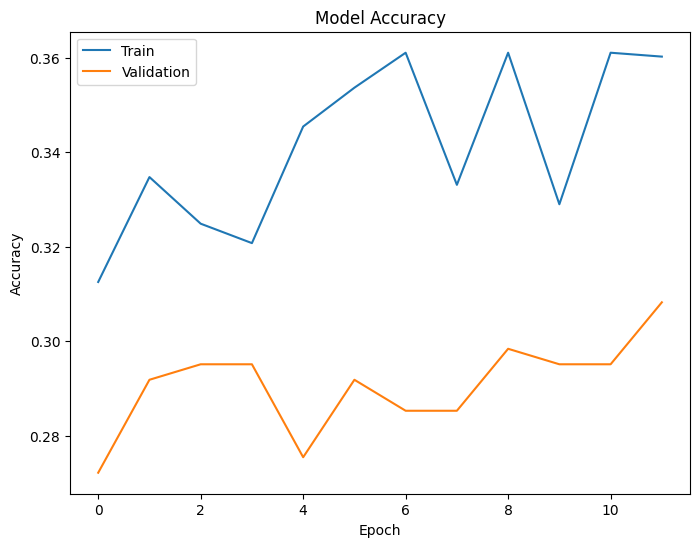

38/38 [==============================] - 0s 4ms/step
train accuracy: 0.378


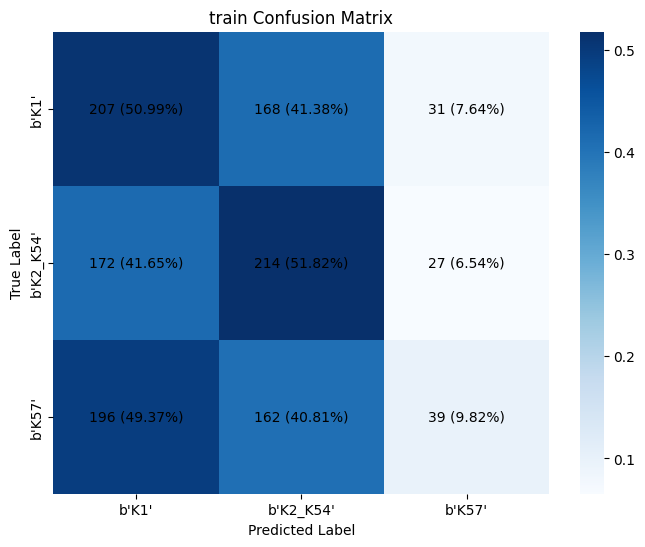

10/10 [==============================] - 0s 4ms/step
val accuracy: 0.308


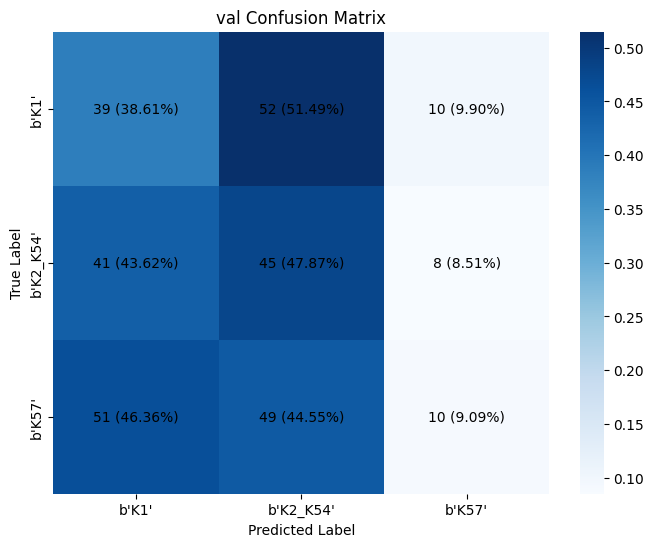

5/5 [==============================] - 0s 6ms/step
test accuracy: 0.288


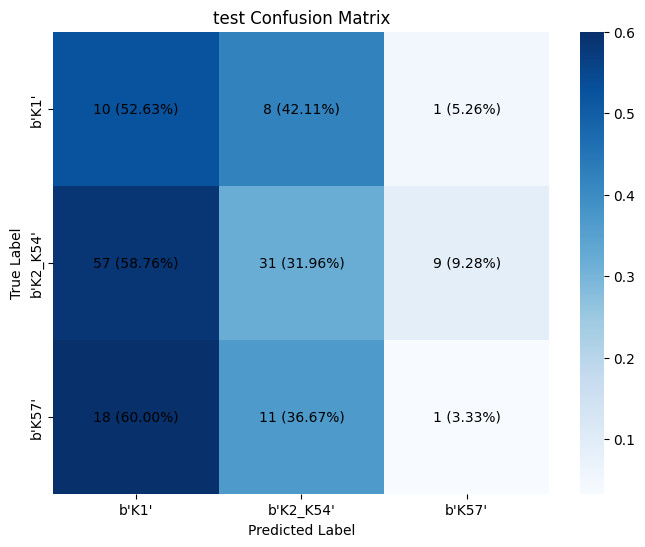

10/10 [==============================] - 0s 8ms/step
Epoch 1/30
28/28 - 6s - loss: 0.6929 - accuracy: 0.5089 - val_loss: 0.6932 - val_accuracy: 0.5179 - 6s/epoch - 216ms/step
Epoch 2/30
28/28 - 1s - loss: 0.6932 - accuracy: 0.5134 - val_loss: 0.6931 - val_accuracy: 0.5045 - 572ms/epoch - 20ms/step
Epoch 3/30
28/28 - 0s - loss: 0.6928 - accuracy: 0.5301 - val_loss: 0.6933 - val_accuracy: 0.5000 - 411ms/epoch - 15ms/step
Epoch 4/30
28/28 - 0s - loss: 0.6935 - accuracy: 0.5045 - val_loss: 0.6933 - val_accuracy: 0.5000 - 364ms/epoch - 13ms/step
Epoch 5/30
28/28 - 0s - loss: 0.6934 - accuracy: 0.4978 - val_loss: 0.6930 - val_accuracy: 0.4911 - 379ms/epoch - 14ms/step
Epoch 6/30
28/28 - 0s - loss: 0.6915 - accuracy: 0.5324 - val_loss: 0.6931 - val_accuracy: 0.5045 - 304ms/epoch - 11ms/step
Epoch 7/30
28/28 - 0s - loss: 0.6928 - accuracy: 0.5078 - val_loss: 0.6930 - val_accuracy: 0.5312 - 326ms/epoch - 12ms/step
Epoch 8/30
28/28 - 0s - loss: 0.6931 - accuracy: 0.5134 - val_loss: 0.6932 - val_

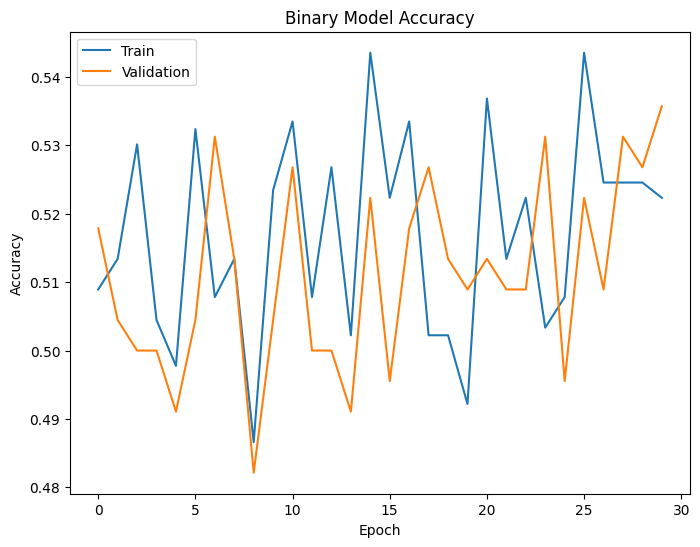

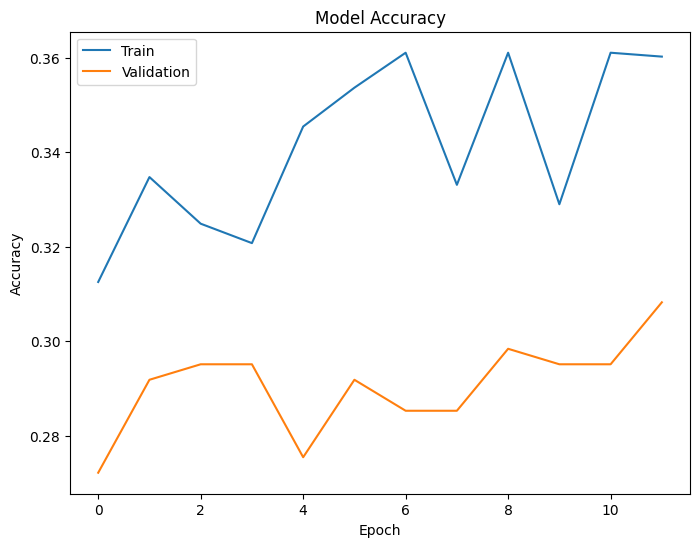

28/28 [==============================] - 0s 5ms/step
train accuracy: 0.579


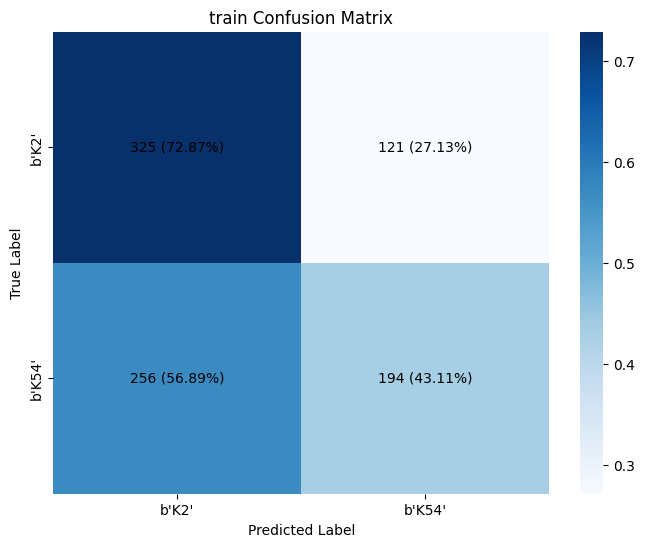

7/7 [==============================] - 0s 6ms/step
val accuracy: 0.536


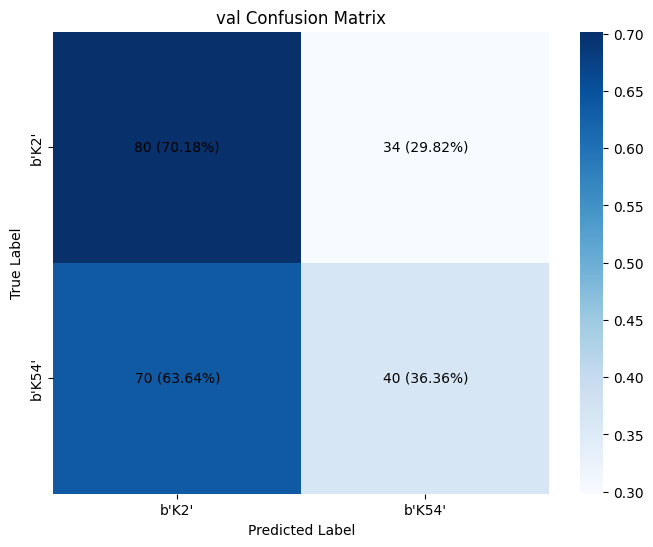

4/4 [==============================] - 0s 8ms/step
test accuracy: 0.505


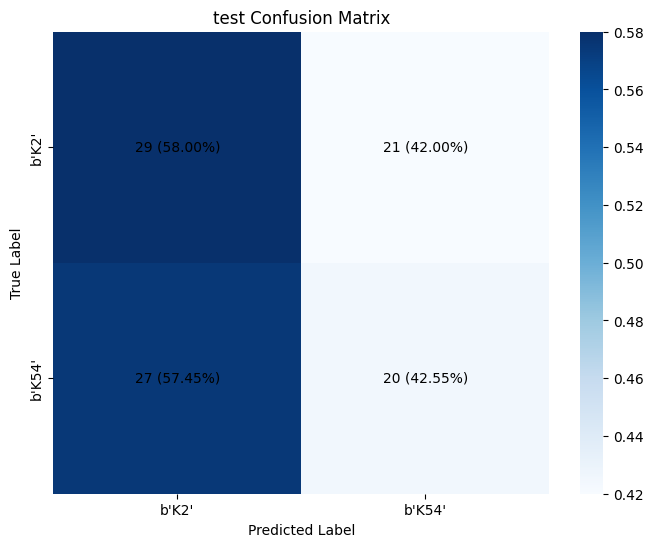

7/7 [==============================] - 0s 5ms/step


In [ ]:
filtered_data = filtered_data_reduced2
ramanshifts = random_values


feature_steps_list = []

# group k2 - k54 into a new column
filtered_data['fenotype_grouped'] = filtered_data['fenotype'].apply(lambda x: 'K2_K54' if x == 'K2' else ('K2_K54' if x == 'K54' else x))


# binary data contains only the spectra of k2 - k54
binary_classes = ['K2_K54', 'K54_K2']
binary_data = filtered_data[filtered_data['fenotype_grouped'].isin(binary_classes)]

# i separate spectra from specific isolates measued on different days as "unseens" (ensuring that an adequate n of spectra remain in the train/val dataset for that isolate)
conditions = [
(filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
(filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
(filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
#(filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

final_condition = conditions[0]
for condition in conditions[1:]:
    final_condition = final_condition | condition


unseens = filtered_data[final_condition]
# train/val dataset
filtered_data2 = filtered_data[~final_condition]


columns_to_drop =  ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date', 'fenotype_grouped']



label = 'fenotype_grouped'


# balanceo
all_classes = filtered_data2[label].unique()

minority_class_size = filtered_data2[label].value_counts().min()

balanced_binary_data_trainval = pd.DataFrame()
balanced_trainval_data = pd.DataFrame()


for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]

    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()



X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()




y_perm_train=tf.random.shuffle(y_train,seed=1000)
y_perm_val=tf.random.shuffle(y_val,seed=1000)
y_perm_test=tf.random.shuffle(y_test,seed=1000)


num_classes_grouped = len(all_classes)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_perm_train)
y_perm_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_perm_test)
y_perm_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_perm_val)
y_perm_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes_grouped))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train.to_numpy(), y_perm_train, batch_size=32, epochs=12, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

calcular = [{'que': 'train', 'X': X_train, 'y': y_perm_train},
            {'que': 'val', 'X': X_val, 'y': y_perm_val},
            {'que': 'test', 'X': X_test, 'y': y_perm_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}

for i in range(len(calcular)):
    y_pred = model.predict(calcular[i]['X'])
    y_pred_int = tf.argmax(y_pred, axis=1)
    y_true_int = tf.argmax(calcular[i]['y'], axis=1)
    accuracy = accuracy_score(y_true_int, y_pred_int)
    print(f"{calcular[i]['que']} accuracy: {accuracy:1.3f}")

    cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

    plt.figure(figsize=(8, 6))
    plt.title(f"{calcular[i]['que']} Confusion Matrix")
    sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(num_classes_grouped)), yticklabels=le.inverse_transform(np.arange(num_classes_grouped)))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_perm_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_perm_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_perm_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)

class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]




if 'K2_K54' in binary_data['fenotype_grouped'].values or 'K54_K2' in binary_data['fenotype_grouped'].values:
    all_classes_bin = 2

    conditions = [
    (binary_data['isolate'] == 'kp382') & (binary_data['date'] == 120723),
    (binary_data['isolate'] == 'Kp188') & (binary_data['date'] == 120723),
    ]

    final_condition = conditions[0]
    for condition in conditions[1:]:
        final_condition = final_condition | condition

    binary_data_unseens = binary_data[final_condition]
    binary_data_trainval = binary_data[~final_condition]


    label = 'fenotype'

    all_classes_ = ['K2', 'K54']

    # balanceo
    minority_class_size = binary_data_trainval[label].value_counts().min()
    balanced_binary_data_trainval = pd.DataFrame()
    for class_name in all_classes_:
        class_samples = binary_data[binary_data[label] == class_name]

        if class_samples.shape[0] > minority_class_size:
            reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, reduced_samples])
        else:
            balanced_binary_data_trainval = pd.concat([balanced_binary_data_trainval, class_samples])

    balanced_y_trainval = balanced_binary_data_trainval[label]
    balanced_binary_data_trainval = balanced_binary_data_trainval.drop(columns=columns_to_drop).copy()



    X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(balanced_binary_data_trainval, balanced_y_trainval, test_size=0.20, random_state=1000)

    y_test_bin = binary_data_unseens['fenotype']
    X_test_bin = binary_data_unseens.drop(columns=columns_to_drop)


    y_train_bin=tf.random.shuffle(y_train_bin,seed=1000)
    y_val_bin=tf.random.shuffle(y_val_bin,seed=1000)
    y_test_bin=tf.random.shuffle(y_test_bin,seed=1000)


    le = LabelEncoder()
    y_train_encoded_bin = le.fit_transform(y_train_bin)
    y_train_bin = tf.keras.utils.to_categorical(y_train_encoded_bin, num_classes=2)
    y_test_encoded_bin = le.transform(y_test_bin)
    y_test_bin = tf.keras.utils.to_categorical(y_test_encoded_bin, num_classes=2)
    y_val_encoded_bin = le.transform(y_val_bin)
    y_val_bin = tf.keras.utils.to_categorical(y_val_encoded_bin, num_classes=2)

    binary_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model_bin = tf.keras.models.Sequential(model.layers[:-1])  # Remove the last layer with 3 units
    model_bin.add(tf.keras.layers.Dense(2, activation='softmax'))  # Add new last layer with 2 units
    model_bin.compile(loss='categorical_crossentropy', optimizer=binary_optimizer, metrics=['accuracy'])

    binary_history = model_bin.fit(X_train_bin.to_numpy(), y_train_bin, batch_size=32, epochs=30, verbose=2, validation_data=(X_val_bin.to_numpy(), y_val_bin))

    plt.figure(figsize=(8, 6))
    plt.plot(binary_history.history['accuracy'])
    plt.plot(binary_history.history['val_accuracy'])
    plt.title('Binary Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    calcular_bin = [{'que': 'train', 'X': X_train_bin, 'y': y_train_bin},
                    {'que': 'val', 'X': X_val_bin, 'y': y_val_bin},
                    {'que': 'test', 'X': X_test_bin, 'y': y_test_bin}]

    class_accuracies_bin = {'train': [], 'val': [], 'test': []}

    for i in range(len(calcular_bin)):
        y_pred_bin = model_bin.predict(calcular_bin[i]['X'])
        y_pred_int_bin = np.argmax(y_pred_bin, axis=1)
        y_true_int_bin = np.argmax(calcular_bin[i]['y'], axis=1)
        accuracy_bin = accuracy_score(y_true_int_bin, y_pred_int_bin)
        print(f"{calcular_bin[i]['que']} accuracy: {accuracy_bin:1.3f}")

        cm_bin = confusion_matrix(y_true_int_bin, y_pred_int_bin, labels=np.arange(all_classes_bin))
        cm_normalized_bin = cm_bin.astype('float') / cm_bin.sum(axis=1, keepdims=True)

        plt.figure(figsize=(8, 6))
        plt.title(f"{calcular_bin[i]['que']} Confusion Matrix")
        sns.heatmap(cm_normalized_bin, annot=False, fmt='.2%', cmap='Blues', xticklabels=le.inverse_transform(np.arange(all_classes_bin)), yticklabels=le.inverse_transform(np.arange(all_classes_bin)))

        for i in range(cm_bin.shape[0]):
            for j in range(cm_bin.shape[1]):
                value = cm_bin[i, j]
                if value != 0 and not np.isnan(cm_normalized_bin[i, j]):
                    text = f"{value} ({cm_normalized_bin[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    class_accuracies_bin[calcular_bin[2]['que']] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]

    y_pred_bin = model_bin.predict(X_test_bin)
    y_pred_int_bin = tf.argmax(y_pred_bin, axis=1)
    y_test_int_bin = tf.argmax(y_test_bin, axis=1)
    accuracy_test_bin = accuracy_score(y_test_int_bin, y_pred_int_bin)

    y_pred_train_bin = model_bin.predict(X_train_bin)
    y_pred_val_bin = model_bin.predict(X_val_bin)

    y_pred_train_int_bin = tf.argmax(y_pred_train_bin, axis=1)
    y_train_int_bin = tf.argmax(y_train_bin, axis=1)
    accuracy_train_bin = accuracy_score(y_train_int_bin, y_pred_train_int_bin)

    y_pred_val_int_bin = tf.argmax(y_pred_val_bin, axis=1)
    y_val_int_bin = tf.argmax(y_val_bin, axis=1)
    accuracy_val_bin = accuracy_score(y_val_int_bin, y_pred_val_int_bin)

    class_accuracies_bin['test'] = [round(cm_normalized_bin[i, i], 2) for i in range(all_classes_bin)]


# 3.4. Comparison between hypermucoviscous (hmvKp) and non-mucoid (nmKp) isolates

## Figure 22

Figure 22: Mean spectra of hmvKp (orange) and nmKp (blue) isolates with their respective standard deviations (a) and the confusion matrix obtained by training the 1-D CNN model with dimensionality reduction to 600 features (b). The overall accuracy was 94%.

<ipython-input-15-399efc20a72f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax22a.set_yticklabels(ax22a.get_yticks(), fontsize=22)


8/8 [==============================] - 0s 9ms/step


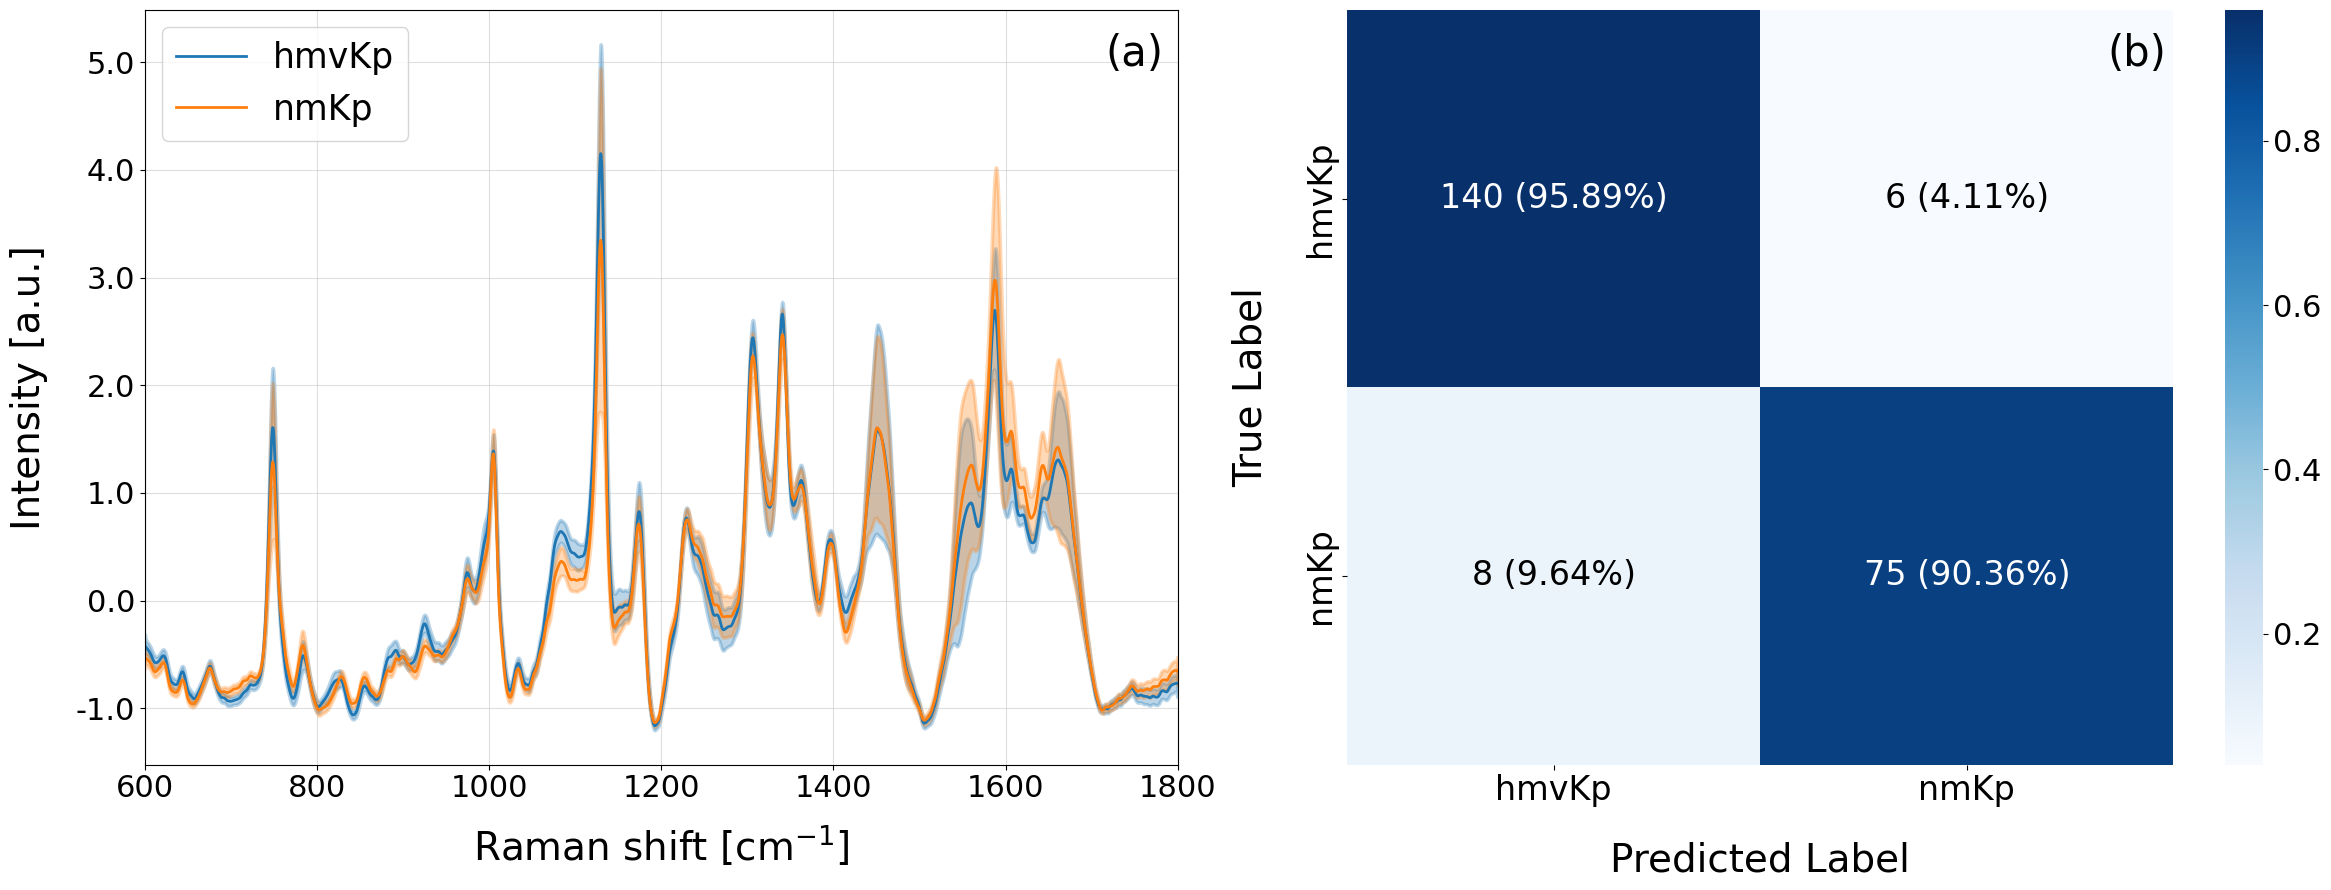

11/11 [==============================] - 0s 8ms/step
Class 0 - Accuracy: 0.94, Recall: 0.96, Precision: 0.95,Specificity: 0.90, F1-Score: 0.95 
Class 1 - Accuracy: 0.94, Recall: 0.90, Precision: 0.93,Specificity: 0.96, F1-Score: 0.91 


In [ ]:
filtered_data = spectra_without_small_range[spectra_without_small_range['date'] != 270623]

# Figure 22: Mean spectra of hmvKp (orange) and nmKp (blue) isolates (a) and the confusion matrix obtained by training the 1-D CNN model with dimensionality reduction to 600 features (b). The overall accuracy was 94%.

fig22, (ax22a, ax22b) = plt.subplots(1, 2, figsize=(24, 9))
ax22a.text(0.93, 0.97, '(a)', transform=ax22a.transAxes, fontsize=30, verticalalignment='top')
ax22b.text(0.92, 0.97, '(b)', transform=ax22b.transAxes, fontsize=30, verticalalignment='top')
alphaVal = 1
linethick = 2.5
# Calculate and plot mean spectra for 'mucoide' categories 'NM' and 'M'
espectros_NM = np.mean(filtered_data[filtered_data['mucoide'] == 'NM'].iloc[:, :-9], axis=0)
espectros_M = np.mean(filtered_data[filtered_data['mucoide'] == 'M'].iloc[:, :-9], axis=0)
ax22a.plot(ramanshifts, espectros_M, lw=2, color='C0', label='hmvKp')
ax22a.plot(ramanshifts, espectros_NM, lw=2, color='C1', label='nmKp')
# Calculate and plot variance of spectra
varianza_espectros_NM = filtered_data[filtered_data['mucoide'] == 'NM'].iloc[:, :-9].var(axis=0)
varianza_espectros_M = filtered_data[filtered_data['mucoide'] == 'M'].iloc[:, :-9].var(axis=0)
ax22a.fill_between(ramanshifts, espectros_M - varianza_espectros_M, espectros_M + varianza_espectros_M, lw=linethick, alpha=0.3, color='C0')
ax22a.fill_between(ramanshifts, espectros_NM - varianza_espectros_NM, espectros_NM + varianza_espectros_NM, lw=linethick, alpha=0.3, color='C1')

ax22a.legend(loc='upper left', prop={'size': 25})
ax22a.grid(alpha=0.4)
ax22a.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=28, labelpad=15)
ax22a.set_ylabel(r'Intensity [a.u.]', fontsize=28, labelpad=20)
ax22a.set_xlim([600, 1800])
ax22a.set_xticks(range(600, 2000, 200))
ax22a.set_xticklabels(range(600, 2000, 200), fontsize=22)
ax22a.set_yticklabels(ax22a.get_yticks(), fontsize=22)



# Load the pre-trained model
model = load_model('/content/drive/MyDrive/klebsiellas/190124_model_mucoid_nonmucoid_600features.h5')

# Define the data and label
filtered_data = filtered_data_reduced
label = 'mucoide'

# Data balancing (undersampling)
all_classes = filtered_data2[label].unique()
minority_class_size = filtered_data2[label].value_counts().min()
balanced_trainval_data = pd.DataFrame()
for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]
    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
        balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])
    else:
        balanced_trainval_data = pd.concat([balanced_trainval_data, class_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()

# Splitting data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()

# Encoding class labels
num_classes_grouped = len(all_classes)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)

# Predictions and confusion matrix calculation
y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_int, y_pred_int, labels=np.arange(num_classes_grouped))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums


# Plotting the confusion matrix
sns_heatmap = sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues',
                          xticklabels=le.inverse_transform(np.arange(num_classes_grouped)),
                          yticklabels=le.inverse_transform(np.arange(num_classes_grouped)),
                          ax=ax22b, annot_kws={'size': 18})

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if value != 0 and not np.isnan(cm_normalized[i, j]):
            text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"

            # Elegir el color del texto basado en el valor de fondo
            text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
            plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=24)


ax22b.set_xlabel('Predicted Label', fontsize=28, labelpad=25)
ax22b.set_ylabel('True Label', fontsize=28, labelpad=25)
plt.xticks(np.arange(num_classes_grouped) + 0.5, ['hmvKp', 'nmKp'], fontsize=24, ha='center')
plt.yticks(np.arange(num_classes_grouped) + 0.5, ['hmvKp', 'nmKp'], fontsize=24, va='center')
cbar = sns_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
plt.tight_layout()
plt.show()


y_pred = model.predict(X_test)
y_pred_int = tf.argmax(y_pred, axis=1)
y_test_int = tf.argmax(y_test, axis=1)
accuracy_test = accuracy_score(y_test_int, y_pred_int)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_train_int = tf.argmax(y_pred_train, axis=1)
y_train_int = tf.argmax(y_train, axis=1)
accuracy_train = accuracy_score(y_train_int, y_pred_train_int)

y_pred_val_int = tf.argmax(y_pred_val, axis=1)
y_val_int = tf.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_int, y_pred_val_int)


calcular = [{'que': 'train', 'X': X_train, 'y': y_train},
            {'que': 'val', 'X': X_val, 'y': y_val},
            {'que': 'test', 'X': X_test, 'y': y_test}]

class_accuracies = {'train': [], 'val': [], 'test': []}


class_accuracies[calcular[2]['que']] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]


y_pred_int_np = np.argmax(y_pred, axis=1)
y_test_int_np = np.argmax(y_test, axis=1)

# Calculate the performance metrics
class_metrics = []
for i in range(num_classes_grouped):
    # True Positive, False Negative, True Negative, False Positive
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + tp
    fp = cm[:, i].sum() - tp

    # Calculating Accuracy, Precision, Recall, Specificity, and F1-Score
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0  # Avoid division by zero
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # One-hot encode true labels for current class
    y_true_class = np.zeros((len(y_test_int),))
    y_true_class[y_test_int == i] = 1

    # Probability scores for current class
    y_score_class = y_pred[:, i]

    # Append metrics for the class
    class_metrics.append({
        'Class': i,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
    })

# Print the calculated metrics for each class
for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Accuracy: {metrics['Accuracy']:.2f}, "
          f"Recall: {metrics['Recall']:.2f}, Precision: {metrics['Precision']:.2f},"
          f"Specificity: {metrics['Specificity']:.2f}, F1-Score: {metrics['F1-Score']:.2f} ")

fig22.savefig('fig22.svg', dpi=300)

y-randomization

In [ ]:
# Initialize empty lists to store feature steps and results
feature_steps_list = []
results = []

# Data separation based on specific isolates and measurement dates
# Ensuring an adequate number of spectra remain in the training/validation dataset for each isolate
conditions = [
    (filtered_data['isolate'] == 'Kp123') & (filtered_data['date'] == 70623),
    (filtered_data['isolate'] == 'kp382') & (filtered_data['date'] == 120723),
    (filtered_data['isolate'] == 'Kp188') & (filtered_data['date'] == 120723),
    (filtered_data['isolate'] == 'Kp010') & (filtered_data['date'] == 110723),
    (filtered_data['isolate'] == 'kpC3') & (filtered_data['date'] == '310523')
]

# Combine conditions using a logical OR operation
final_condition = np.logical_or.reduce(conditions)

# Define unseen dataset and training/validation dataset
unseens = filtered_data[final_condition]
filtered_data2 = filtered_data[~final_condition]


# Label for classification
label = 'mucoide'

# Class balancing
all_classes = filtered_data2[label].unique()
minority_class_size = filtered_data2[label].value_counts().min()
balanced_trainval_data = pd.DataFrame()

for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]
    reduced_samples = class_samples.sample(n=min(minority_class_size, len(class_samples)), random_state=1000)
    balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data = balanced_trainval_data.drop(columns=columns_to_drop).copy()

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000
)

# Preparing the test set
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop).copy()

# Permutation of labels for training, validation, and test sets
y_perm_train = tf.random.shuffle(y_train, seed=1000)
y_perm_val = tf.random.shuffle(y_val, seed=1000)
y_perm_test = tf.random.shuffle(y_test, seed=1000)

# Encoding labels
num_classes_grouped = len(all_classes)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_perm_train)
y_perm_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes_grouped)
y_val_encoded = le.transform(y_perm_val)
y_perm_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes_grouped)
y_test_encoded = le.transform(y_perm_test)
y_perm_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes_grouped)

# Model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Convolution1D(64, 8, padding='same', input_shape=(len(X_train.columns), 1)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes_grouped, activation='softmax')
])

model.summary()

# Model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model training
history = model.fit(
    X_train.to_numpy(), y_perm_train, batch_size=32, epochs=12, verbose=2, validation_data=(X_val.to_numpy(), y_perm_val)
)

# Plotting training history
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Function to evaluate and plot model performance
def evaluate_and_plot(model, data, label_encoder):
    class_accuracies = {}
    for dataset in data:
        X, y, dataset_name = dataset['X'], dataset['y'], dataset['que']
        y_pred = model.predict(X)
        y_pred_int = tf.argmax(y_pred, axis=1)
        y_true_int = tf.argmax(y, axis=1)
        accuracy = accuracy_score(y_true_int, y_pred_int)
        print(f"{dataset_name} accuracy: {accuracy:.3f}")

        cm = confusion_matrix(y_true_int, y_pred_int, labels=np.arange(num_classes_grouped))
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize by row sums

        plt.figure(figsize=(8, 6))
        plt.title(f"{dataset_name} Confusion Matrix")
        sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='Blues',
                    xticklabels=label_encoder.inverse_transform(np.arange(num_classes_grouped)),
                    yticklabels=label_encoder.inverse_transform(np.arange(num_classes_grouped)))

        # Annotating values in the confusion matrix
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                value = cm[i, j]
                if value != 0 and not np.isnan(cm_normalized[i, j]):
                    text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                    plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color='black')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        class_accuracies[dataset_name] = [round(cm_normalized[i, i], 2) for i in range(len(all_classes))]

    return class_accuracies

# Evaluating the model
evaluation_data = [
    {'que': 'train', 'X': X_train, 'y': y_perm_train},
    {'que': 'val', 'X': X_val, 'y': y_perm_val},
    {'que': 'test', 'X': X_test, 'y': y_perm_test}
]

class_accuracies = evaluate_and_plot(model, evaluation_data, le)

# Displaying per-class accuracies
for dataset_name, accuracies in class_accuracies.items():
    print(f"{dataset_name} per-class accuracies: {accuracies}")

## saliency

In [ ]:
# Load preprocessed dataset and trained model
filtered_data = filtered_data_reduced
model = load_model('/content/drive/MyDrive/klebsiellas/190124_model_mucoid_nonmucoid_600features.h5')

# Define label and columns to drop from the dataset
label = 'mucoide'
columns_to_drop = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']


# Balance the dataset
all_classes = filtered_data2[label].unique()
minority_class_size = filtered_data2[label].value_counts().min()
balanced_trainval_data = pd.DataFrame()

for class_name in all_classes:
    class_samples = filtered_data2[filtered_data2[label] == class_name]
    if class_samples.shape[0] > minority_class_size:
        reduced_samples = class_samples.sample(n=minority_class_size, random_state=1000)
    else:
        reduced_samples = class_samples
    balanced_trainval_data = pd.concat([balanced_trainval_data, reduced_samples])

balanced_y_trainval = balanced_trainval_data[label]
balanced_trainval_data.drop(columns=columns_to_drop, inplace=True)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(balanced_trainval_data, balanced_y_trainval, test_size=0.20, random_state=1000)
y_test = unseens[label]
X_test = unseens.drop(columns=columns_to_drop)

# Saliency analysis
original_output = model.predict(X_test.values)
output_diff_data = []
total_iterations = len([filtered_data2[column].mean() for column in reduced_ramanshifts])

for idx in range(total_iterations):
    if idx < 4:
        selected_indices = list(range(idx, idx + 5))
    elif idx > total_iterations - 5:
        selected_indices = list(range(idx - 4, idx + 1))
    else:
        selected_indices = list(range(idx - 4, idx + 5))

    modified_test_data = X_test.copy()
    column_means = filtered_data2.mean(axis=0, numeric_only=True)
    min_mean = column_means.min()
    modified_test_data.iloc[:, selected_indices] = min_mean

    modified_probabilities = model.predict(modified_test_data.values)
    output_difference = np.abs(modified_probabilities - original_output)
    output_difference_mean = np.mean(output_difference, axis=0)
    output_diff_data.append({'feature': X_test.columns[idx], 'output_difference': output_difference_mean})

# Convert list to DataFrame
output_diff_df = pd.DataFrame(output_diff_data)
output_diff_df['feature'] = pd.to_numeric(output_diff_df['feature'])
output_diff_df['average_output_difference'] = output_diff_df['output_difference'].apply(lambda x: np.mean(x))
output_diff_df_ = output_diff_df[['feature', 'average_output_difference']]

# Plotting the saliency analysis results
plt.figure(figsize=(10, 6))
plt.plot(output_diff_df_['feature'], output_diff_df_['average_output_difference'], color='blue')
plt.xlabel('Raman shift [cm$^{-1}$]', fontsize=12)
plt.ylabel('Average Output Difference', fontsize=12)
plt.title('Model Saliency Analysis: Feature Impact on Predictions', fontsize=14)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()
plt.close()

# Save the saliency analysis results to a file
output_diff_df_.to_csv('/content/drive/MyDrive/klebsiellas/310124_output_diff_saliency_M_NM_600features.csv', index=False)

## Figure 23

Figure 23: Saliency of the 1-D CNN model trained to classify hmvKp and nmKp isolates. A continuous dashed line represents a saliency value of 0.18 (a). Features with a saliency value greater than 0.2 are marked in red, along with the mean spectrum of the entire dataset (b).

In [ ]:
# Sort the DataFrame by the 'feature' column in ascending order
output_diff_df_ = output_diff_df_.sort_values(by='feature', ascending=True)

# Create a subplot with 2 horizontal plots
fig23, (ax23a, ax23b) = plt.subplots(1, 2, figsize=(24, 8))

# Add subplot labels
ax23a.text(0.91, 0.97, '(a)', transform=ax23a.transAxes, fontsize=30, verticalalignment='top')
ax23b.text(0.91, 0.97, '(b)', transform=ax23b.transAxes, fontsize=30, verticalalignment='top')

# Plotting parameters
alphaVal = 1
linethick = 2.5

# Plotting the first subplot
ax23a.plot(output_diff_df_.iloc[:, 0], output_diff_df_.iloc[:, 1], color='C0', lw=linethick, alpha=alphaVal)
ax23a.grid(alpha=0.4)
ax23a.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=25, labelpad=15)
ax23a.set_ylabel(r'Intensity [a.u.]', fontsize=25, labelpad=20)
ax23a.set_xlim([600, 1800])
ax23a.set_xticks(range(600, 2000, 200))
ax23a.set_xticklabels(range(600, 2000, 200), fontsize=20)
ax23a.axhline(y=0.17, color='red', linestyle='--', alpha=0.5, lw=2)

# Ensure that y-tick labels are consistent with ax22a (assuming ax22a exists in your code)
yticklabels_ax22a = [item.get_text() for item in ax22a.get_yticklabels()]

# Set the same y-tick labels for ax23a
ax23a.set_yticklabels(yticklabels_ax22a, fontsize=20)

# Sort output_diff_df_ by 'average_output_difference' in descending order
output_diff_df_ = output_diff_df_.sort_values(by='average_output_difference', ascending=False)

# Filter to retain rows with 'average_output_difference' greater than 0.18
output_diff_df_top28 = output_diff_df_[output_diff_df_['average_output_difference'] > 0.18]

# Retaining specific columns in filtered_data_reduced
columns = ['filename', 'isolate', 'specie', 'mucoide', 'spectrum_number', 'intense', 'fenotype', 'number', 'date']
filtered_data_reduced2 = filtered_data_reduced.copy()
filtered_data_reduced2[columns] = filtered_data_reduced[columns]

# Extracting features to keep based on output_diff_df_top28
columns_to_keep = output_diff_df_top28['feature'].values

# Plotting the second subplot
ax23b.plot(reduced_ramanshifts, filtered_data_reduced2.iloc[:, :-9].mean(axis=0), lw=linethick, alpha=alphaVal)
ax23b.scatter(pd.DataFrame(columns_to_keep), filtered_data_reduced2[columns_to_keep].mean(axis=0), color='red', s=17, lw=linethick, alpha=alphaVal)
ax23b.grid(alpha=0.4)
ax23b.set_xlabel(r'Raman shift [cm$^{-1}$]', fontsize=25, labelpad=15)
ax23b.set_ylabel(r'Intensity [a.u.]', fontsize=25, labelpad=20)
ax23b.set_xlim([600, 1800])
ax23b.set_xticklabels(range(600, 2000, 200), fontsize=20)

# Ensure that y-tick labels are consistent with ax22a (assuming ax22a exists in your code)
ax23b.set_yticklabels(ax23b.get_yticks(), fontsize=20)

# Display the plot
plt.show()

# Save the figure in SVG format with a specified dpi
fig23.savefig('fig23.svg', dpi=300)